# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [151]:
 # define your regions here
presel = {
        "mu": {
            "tagger>0.50": "THWW>0.5",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>20",
#             "lepmiso": "(lep_pt<55) | ( (lep_pt>55) & (lep_misolation<0.02))",
        },
        "ele": {
            "tagger>0.50": "THWW>0.5",
#             "fj_pt": "fj_pt>250",
#             "msoftdrop": "fj_mass>40",
#             "met": "met_pt>20",
#             "lepmiso": "(lep_pt<120) | ( (lep_pt>120) & (lep_misolation<0.02))",
        },
}

channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",    
    "Data",

    # TODO: make sure it's WZQQ is NLO in next iteration
#     "DYJets",
#     "WZQQ",
    
    "WZQQorDYJets",
]

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2017", "2016", "2018"]

# years = ["2017"]

In [152]:
events_dict = {}

In [153]:
samples_dir = {
#     "2016":    "../eos/Feb9_2016",
#     "2016APV": "../eos/Feb9_2016APV",
#     "2017":    "../eos/Feb9_2017",    
#     "2018":    "../eos/Feb9_2018",
    
    # new jobs
    "2016":    "../eos/May31_hww_2016",
    "2016APV": "../eos/May31_hww_2016APV",
    "2017":    "../eos/May31_hww_2017",    
    "2018":    "../eos/May31_hww_2018",    
}

from make_stacked_hists import make_events_dict

events_dict = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 1745 events
INFO:root:Will fill the VBF dataframe with the remaining 854 events
INFO:root:tot event weight 7.6048678973173125 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 87 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1 events
INFO:root:tot event weight 1.6639318904239442 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 1953 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 127 events
INFO:root:tot event weight 38.74263155700244 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine

INFO:root:Will fill the QCD dataframe with the remaining 7 events
INFO:root:tot event weight 0.004734034471534267 

INFO:root:Finding SingleMuon_Run2017E samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2017B samples and should combine them under Data
INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 914 events
INFO:root:Will fill the Diboson dataframe with the remaining 119 events
INFO:root:tot event weight 56.01981476328125 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 762441 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 5455 events
INFO:root:tot event weight 28.786086262476736 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under S

INFO:root:tot event weight 21.678391836424407 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 42 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1 events
INFO:root:tot event weight 2.8216819641525093 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 33953 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2708 events
INFO:root:tot event weight 1348.8783830753957 

INFO:root:Finding QCD_Pt_470to600 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 778 events
INFO:root:Will fill the QCD dataframe with the remaining 26 events
INFO:root:tot event weight 28.115962724169812 

INFO:root:Finding HZJ_HT

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 256 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 11 events
INFO:root:tot event weight 0.8177063278255872 

INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 29696 events
INFO:root:Will fill the Data dataframe with the remaining 1581 events
INFO:root:tot event weight 1581.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 19040 events
INFO:root:Will fill the SingleTop dataframe with the remaining 307 events
INFO:root:tot event weight 0.9981815621110091 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 1339

INFO:root:Applying tagger>0.50 selection on 60793 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2191 events
INFO:root:tot event weight 0.8074278307670862 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 14875 events
INFO:root:Will fill the ttH dataframe with the remaining 3022 events
INFO:root:tot event weight 5.412215704001309 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 2027 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 55 events
INFO:root:tot event weight 4.107855055545378 

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event 

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 1726 events
INFO:root:Will fill the SingleTop dataframe with the remaining 84 events
INFO:root:tot event weight 16.845322570594167 

INFO:root:Finding SingleElectron_Run2016H samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 19607 events
INFO:root:Will fill the Data dataframe with the remaining 900 events
INFO:root:tot event weight 900.0 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 2111 events
INFO:root:Will fill the ggF dataframe with the remaining 991 events
INFO:root:tot event weight 7.120795865441716 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 120699 events
INFO:root

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 112129 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 843 events
INFO:root:tot event weight 2.934070794122016 

INFO:root:Finding EWKWminus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 38 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 2 events
INFO:root:tot event weight 0.040736012483233004 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 146 events
INFO:root:Will fill the QCD dataframe with the remaining 7 events
INFO:root:tot event weight 428.4124456110917 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 sel

INFO:root:Will fill the SingleTop dataframe with the remaining 250 events
INFO:root:tot event weight 6.3804566708643815 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 92 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1 events
INFO:root:tot event weight 0.022461527357381817 

INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 91268 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5966 events
INFO:root:tot event weight 73.29637065870591 

INFO:root:Finding EWKZ_ZToLL samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 168 events
INFO:root:Will fill the EWKvjets dataframe with the remaini

INFO:root:Will fill the QCD dataframe with the remaining 48 events
INFO:root:tot event weight 0.30810333458779354 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 6085 events
INFO:root:Will fill the QCD dataframe with the remaining 149 events
INFO:root:tot event weight 5.458510481921726 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 2644 events
INFO:root:Will fill the QCD dataframe with the remaining 43 events
INFO:root:tot event weight 77.70859891213229 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 575 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 45 events
INFO:root:tot event we

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 51342 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3295 events
INFO:root:tot event weight 168.32783630417805 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 330497 events
INFO:root:Will fill the TTbar dataframe with the remaining 9571 events
INFO:root:tot event weight 500.3831276487714 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 9217 events
INFO:root:Will fill the SingleTop dataframe with the remaining 128 events
INFO:root:tot event weight 4.355633214741731 

INFO:root:Finding ST_s-channel_4f_hadronicDecays sa

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 48 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1 events
INFO:root:tot event weight 0.378404645593656 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 119 events
INFO:root:Will fill the Diboson dataframe with the remaining 5 events
INFO:root:tot event weight 1.2380142549470847 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 818 events
INFO:root:Will fill the TTbar dataframe with the remaining 47 events
INFO:root:tot event weight 2.4544536230438885 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 975 events
INFO:roo

INFO:root:Will fill the Diboson dataframe with the remaining 29 events
INFO:root:tot event weight 3.0253963504397117 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 700 events
INFO:root:Will fill the QCD dataframe with the remaining 6 events
INFO:root:tot event weight 0.006975192928531824 

INFO:root:Finding SingleElectron_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 13459 events
INFO:root:Will fill the Data dataframe with the remaining 758 events
INFO:root:tot event weight 758.0 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 860 events
INFO:root:Will fill the VBF dataframe with the remaining 457 events
INFO:root:tot event weight 5.258700412513424 

INF

INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 1332 events
INFO:root:Will fill the Diboson dataframe with the remaining 265 events
INFO:root:tot event weight 41.83492787939296 

INFO:root:Finding SingleMuon_Run2016D_HIPM samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 11331 events
INFO:root:Will fill the Data dataframe with the remaining 712 events
INFO:root:tot event weight 712.0 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 86587 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1924 events
INFO:root:tot event weight 9.630085305204457 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection 

INFO:root:Will fill the EWKvjets dataframe with the remaining 99 events
INFO:root:tot event weight 32.44157784091633 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 6612 events
INFO:root:Will fill the ZH dataframe with the remaining 3357 events
INFO:root:tot event weight 0.035796387770670984 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 360 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 19 events
INFO:root:tot event weight 4.385256091972612 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 28 events
INFO:root:Will fill the WZQQo

INFO:root:tot event weight 3.298052165923587 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 64445 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 2237 events
INFO:root:tot event weight 158.12296487356926 

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 32586 events
INFO:root:Will fill the Data dataframe with the remaining 1596 events
INFO:root:tot event weight 1596.0 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 94 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 10 events
INFO:root:tot event weight 1.414462567362556 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine the

INFO:root:Applying tagger>0.50 selection on 5879 events
INFO:root:Will fill the ttH dataframe with the remaining 1087 events
INFO:root:tot event weight 6.465917724495714 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 512 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 17 events
INFO:root:tot event weight 1.9343111760979812 

INFO:root:Finding EGamma_Run2018C samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 15261 events
INFO:root:Will fill the Data dataframe with the remaining 807 events
INFO:root:tot event weight 807.0 

INFO:root:Finding EGamma_Run2018D samples and should combine them under Data
INFO:root:Applying tagger>0.50 selection on 69925 events
INFO:root:Will fill the Data dataframe with the remaining 3589 events
INFO:root:tot event weight 3589.0 

INFO:root:Finding QCD_Pt_800to1

INFO:root:tot event weight 561.8888933703042 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 6077 events
INFO:root:Will fill the SingleTop dataframe with the remaining 324 events
INFO:root:tot event weight 78.12549636126042 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 7341 events
INFO:root:Will fill the ggF dataframe with the remaining 3878 events
INFO:root:tot event weight 45.85320951308111 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-650ToInf samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 116461 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 2213 events
INFO:root:tot event weight 1.25876

INFO:root:tot event weight 3.4413860517620565 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 47342 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 1000 events
INFO:root:tot event weight 6.860334363035587 

INFO:root:Finding EWKWminus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 110 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 9 events
INFO:root:tot event weight 1.0144943886873479 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying tagger>0.50 selection on 107 events
INFO:root:Will fill the QCD dataframe with the remaining 2 events
INFO:root:tot event weight 570.5067791122835 

INFO:root:Finding WJet

In [154]:
for year in years:
    # electron channel
    df = pd.read_parquet(f"fake_{year}_ele.parquet")
    for selection in presel["ele"]:
        df = df.query(presel["ele"][selection])

    events_dict[year]["ele"]["Fake"] = df
    
    # muon channel
    events_dict[year]["mu"]["Fake"] = 0

In [ ]:
# for LP
for ch in channels:
    out = make_events_dict(["2017"], channels, "../eos/May23_LP_2017", ["TTbar"], presel)
    for selection in presel[ch]:
        df = df.query(presel[ch][selection])

    events_dict["2017"][ch]["TTbar_LP"] = df

In [9]:
def get_soverb(ev, presel, categories_sel, years, channels, precision=0, usefake=False):

    mass_window = [50, 150]

    num_sig = {
        "ggF": 0,
        "VBF": 0,
    }
    
    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data",
        "WZQQorDYJets"
    ]

    
    if usefake:
        dominant_backgrounds = ["WJetsLNu", "TTbar", "Fake", "WZQQorDYJets"]        
        
        samples += ["Fake"]
        num_bkg = {
            "WJetsLNu": 0, 
            "TTbar": 0, 
            "Fake": 0,
            "WZQQorDYJets": 0,
            "Others": 0,
        }
    else:
        dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "WZQQorDYJets"]
        
        samples += ["QCD"]        
        num_bkg = {
            "WJetsLNu": 0, 
            "TTbar": 0, 
            "QCD": 0,
            "WZQQorDYJets": 0,
            "Others": 0,
        }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0


    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = ev[year][ch][sample]                    

                if (ch == "mu") and (sample=="Fake"):
                        continue
                
                for region, sel in presel.items():
                    df = df.query(sel)

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)


#                 if sample == "QCD":
#                     threshold = 30
#                     avg_good_weight = df["event_weight"][df["event_weight"]<threshold].mean()
                    
#                     df["event_weight"][df["event_weight"]>threshold] = avg_good_weight

                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            if precision == 0:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
            elif precision == 1:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.1f}%")                
            elif precision == 2:
                print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.2f}%")
        else:
            if precision == 0:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
            elif precision == 1:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.1f}%")
            elif precision == 2:
                print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.2f}%")

In [10]:
presel = {
    "SR": "THWW>0.924",
}
categories_sel = {}
get_soverb(events_dict, presel, categories_sel, years, channels)

SR (RUN2):
------------------------
s/sqrt(b) in [50,150]: 1.73
------------------------
Signal: 62.17
- VBF: 29%
- ggF: 71%
------------------------
Background: 1542.35
- QCD: 2%
- WZQQorDYJets: 3%
- Others: 10%
- TTbar: 36%
- WJetsLNu: 49%


In [146]:
def make_composition_table(ev, presel, add_soverb=False, use_Fake=False):

    from collections import OrderedDict
    
    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "WJetsLNu",
        "TTbar",
        "SingleTop",
        "Diboson",
        "EWKvjets",
        "WZQQorDYJets",
    ]
    if use_Fake:    
        all_MCsamples += ["Fake"]
        bkg = ["TTbar", "WJetsLNu", "Fake", "Others"]        
    else:
        all_MCsamples += ["QCD"]
        bkg = ["TTbar", "WJetsLNu", "QCD", "Others"]        
    
    sig = ["VBF", "ggF"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    if add_soverb:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}")
    else:
        print("\\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset.}")
        
    if add_soverb:
        print("\\begin{tabular}{c|cc|cccc|c}")
    else:
        print("\\begin{tabular}{c|cc|cccc}")

    if add_soverb:    
        print("& \\multicolumn{2}{c|}{Signal yield} & \\multicolumn{4}{c|}{Background yield} & \\multicolumn{1}{c}{$s/\sqrt{b}$} \\\\\n")
        print("& VBF & ggF & \\ttbar & W$+$jets & QCD & Other & \\\\\n")        
    else:
        print("& \\multicolumn{2}{c|}{Signal yield} & \\multicolumn{4}{c}{Background yield} \\\\\n")
        print("& VBF & ggF & \\ttbar & W$+$jets & QCD & Other \\\\\n")        
    print("\\hline")
    print("\\hline")

    for region, sel in presel.items():

        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,
        })

        if use_Fake:            
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "QCD": 0,
                "Others": 0,    
            })
        else:
            bkg_dict = OrderedDict({
                "TTbar": 0,
                "WJetsLNu": 0, 
                "Fake": 0,
                "Others": 0,    
            })            

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years:
            for ch in channels:
                for sample in all_MCsamples:

                    try:
                        df = ev[year][ch][sample]
                    except:
                        continue

                    if (ch == "mu") and (sample=="Fake"):
                        continue

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["event_weight"].sum()                    
                        sig_dict[sample] += df["event_weight"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["event_weight"].sum()
                        bkg_dict[sample] += df["event_weight"].sum()
                    else:
                        tot_bkg += df["event_weight"].sum()                        
                        bkg_dict["Others"] += df["event_weight"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
                    ######################## soverb end

        texdata = "\multirow{2}{*}{" + region + "} & \multicolumn{2}{c|}{"
        texdata += str(round(tot_sig))
        
        if add_soverb:
            texdata += "} & \multicolumn{4}{c|}{"
            texdata += str(round(tot_bkg))
            texdata += "} & \multicolumn{1}{c}{"            
#             texdata += str(round(s/(b**0.5),3))
            texdata += "\multirow{2}{*}{" + str(round(s/(b**0.5),3)) + "}"
            
            texdata += "} \\\\\n"
        else:
            texdata += "} & \multicolumn{4}{c}{"
            texdata += str(round(tot_bkg))
            texdata += "} \\\\\n"
        
#         texdata += "\\cline{2-9} \n"
        
        for sample in sig_dict:
            texdata += f" & {(100*sig_dict[sample]/tot_sig):.0f}\%"
        for sample in bkg_dict:
            texdata += f" & {(100*bkg_dict[sample]/tot_bkg):.0f}\%"
        
        if add_soverb:
            texdata += " & "

        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{region}")
    print("\\end{center}")
    print("\\end{table}")      

In [150]:
presel = {
    "Pre-selection": f"THWW>0", # dummy
    
#     "Signal region": f"(THWW>0.97) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.5) & (n_bjets_T>0)",
#     "W+Jets control region": f"(fj_ParT_score_finetuned<0.97) & (fj_ParT_score_finetuned>0.50) & (n_bjets_T==0) & (met_pt>100)",

#     "VBF category": "(THWW>0.925 & n_bjets_T==0) & (mjj>1000) & (deta>3.5)",    
#     "ggF category $p_T \in [250, 300]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300)",
#     "ggF category $p_T \in [300, 450]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450)",
#     "ggF category $p_T \in [450, \\mathrm{Inf}]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450)",
    
#     "W+Jets control region (w/o MET cut)": f"(THWW<0.925) & (THWW>0.80) & (n_bjets_T==0)",
#     "W+Jets control region (MET$>$50\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>50)",
#     "W+Jets control region (MET$>$100\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>100)",
#     "W+Jets control region (MET$>$150\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>150)",
#     "W+Jets control region (MET$>$200\GeV)": f"(THWW<0.97) & (THWW>0.50) & (n_bjets_T==0) & (met_pt>200)",
#     "THWW>0": f"THWW>0",
#     "THWW>0.1": f"THWW>0.1",
#     "THWW>0.3": f"THWW>0.3",
#     "THWW>0.5": f"THWW>0.5",
#     "THWW>0.7": f"THWW>0.7",
#     "THWW>0.9": f"THWW>0.9",
    
}

make_composition_table(events_dict, presel, add_soverb=True, use_Fake=True)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different processes in the search regions for the full Run2 dataset. The last column includes $s/\sqrt{b}$ in a mass window of 100-150\GeV in the mass observable (the Higgs reconstructed mass).}
\begin{tabular}{c|cc|cccc|c}
& \multicolumn{2}{c|}{Signal yield} & \multicolumn{4}{c|}{Background yield} & \multicolumn{1}{c}{$s/\sqrt{b}$} \\

& VBF & ggF & \ttbar & W$+$jets & QCD & Other & \\

\hline
\hline
\multirow{2}{*}{Pre-selection} & \multicolumn{2}{c|}{447} & \multicolumn{4}{c|}{769436} & \multicolumn{1}{c}{\multirow{2}{*}{0.522}} \\
 & 27\% & 73\% & 41\% & 41\% & 0\% & 18\% &  \\

\hline
\hline
\end{tabular}
\label{region}
\end{center}
\end{table}


In [11]:
def make_composition_table_sig(ev, presel):

    from collections import OrderedDict

    all_MCsamples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH", 
        "HTauTau"
    ]

    sig = ["VBF", "ggF"]         
    bkg = ["ttH", "WH", "ZH", "HTauTau"]

    mass_window = [50, 150]
    
    # make table
    print("\\begin{table}[!ht]")
    print("\\begin{center}")
    
    print("\\caption{Event yield contribution from different Higgs processes at pre-selection level and in the signal-like region, defined by a high tagger score, for the full Run2 dataset. The contribution of H(tau-tau) decays is negligible in both regions.}")
            
    print("\\begin{tabular}{c|cc|cccc}")

    print("& \\multicolumn{2}{c|}{Higgs Signal yields} & \\multicolumn{4}{c}{Higgs Background yields} \\\\\n")
    print("& VBF & ggF & \\ttH & WH & ZH & HTauTau \\\\\n")        
    print("\\hline")
    print("\\hline")

    for region, sel in presel.items():

        sig_dict = OrderedDict({
            "VBF": 0,
            "ggF": 0,             
        })

        bkg_dict = OrderedDict({
            "ttH": 0,
            "WH": 0, 
            "ZH": 0,
            "HTauTau": 0,
        })

        tot_sig, tot_bkg = 0, 0
        s, b = 0, 0   # in mass window [100, 150]
        for year in years:
            for ch in channels:
                for sample in all_MCsamples:

                    try:
                        df = ev[year][ch][sample]
                    except:
                        continue

                    df = df.query(sel)  

                    if sample in sig_dict:
                        tot_sig += df["event_weight"].sum()                    
                        sig_dict[sample] += df["event_weight"].sum()
                    elif sample in bkg_dict:
                        tot_bkg += df["event_weight"].sum()
                        bkg_dict[sample] += df["event_weight"].sum()
                    else:
                        tot_bkg += df["event_weight"].sum()                        
                        bkg_dict["Others"] += df["event_weight"].sum()                    

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in sig_dict:                
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
                    ######################## soverb end


        texdata = region
        for sample in sig_dict:
            texdata += f" & {(sig_dict[sample]):.0f}"
        for sample in bkg_dict:
            texdata += f" & {(bkg_dict[sample]):.0f}"
        
        texdata += " \\\\\n"
        print(texdata)
        print("\\hline")

    print("\\hline")
    print("\\end{tabular}")
    print("\\label{region}")
    print("\\end{center}")
    print("\\end{table}")      

In [64]:
presel = {
    "Pre-selection": f"THWW>0", # dummy

#     "SR using pt flatten: score> 85": f"({tagger}>0.91) & (n_bjets_T==0)",
    r"$T_{HWW}^{\ell\nu qq} > 0.925$": f"{tagger}>0.925",

#     "Signal region": f"(THWW>0.98) & (n_bjets_T==0)",    
#     "Top control region": f"(THWW>0.5) & (n_bjets_T>0)",
#     "W+Jets control region": f"(THWW<0.97) & (fj_ParT_score_finetuned>0.50) & (n_bjets_T==0) & (met_pt>100)",

#     "VBF category": "(THWW>0.925 & n_bjets_T==0) & (mjj>1000) & (deta>3.5)",    
#     "ggF category $p_T \in [250, 300]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300)",
#     "ggF category $p_T \in [300, 450]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450)",
#     "ggF category $p_T \in [450, \\mathrm{Inf}]$": "(THWW>0.95 & n_bjets_T==0) & ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450)",
    
}

make_composition_table_sig(events_dict, presel)

\begin{table}[!ht]
\begin{center}
\caption{Event yield contribution from different Higgs processes at pre-selection level and in the signal-like region, defined by a high tagger score, for the full Run2 dataset. The contribution of H(tau-tau) decays is negligible in both regions.}
\begin{tabular}{c|cc|cccc}
& \multicolumn{2}{c|}{Higgs Signal yields} & \multicolumn{4}{c}{Higgs Background yields} \\

& VBF & ggF & \ttH & WH & ZH & HTauTau \\

\hline
\hline
Pre-selection & 37 & 96 & 13 & 16 & 9 & 0 \\

\hline
$T_{HWW}^{\ell\nu qq} > 0.925$ & 18 & 44 & 5 & 7 & 4 & 0 \\

\hline
\hline
\end{tabular}
\label{region}
\end{center}
\end{table}


# Stacked hists

In [13]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [156]:
vars_to_plot = [
    
    ############## AN start
    "FirstFatjet_pt",
    "fj_lsf3",
    "fj_mass",
    "fj_ParT_mass",
    "fj_pt",
    "ht",    
    "lep_fj_dr",    
    "lep_isolation_ele",
    "lep_isolation_ele_highpt",
    "lep_isolation_ele_lowpt",
    "lep_isolation_mu",
    "lep_isolation_mu_highpt",
    "lep_isolation_mu_lowpt",
    "lep_isolation",
    "lep_misolation_ele",
    "lep_misolation_ele_highpt",
    "lep_misolation_ele_lowpt",    
    "lep_misolation_mu",
    "lep_misolation_mu_highpt",
    "lep_misolation_mu_lowpt",
    "lep_misolation",
    "lep_pt",
    "met_fj_dphi",
    "met_pt",
    "NumFatjets",
    "NumOtherJets",
    "rec_higgs_m",    
    "rec_W_lnu_m",
    "rec_W_qq_m",
    "SecondFatjet_pt",
    ############## AN end
    
#     "THWW",
#     "lep_met_mt",
]

samples_to_plot = [
    "ggF", 
    "VBF",
    "ttH",
    "WH",
    "ZH",
    
#     "QCD",
    "Fake",

    "SingleTop",
    "Diboson",
#     "EWKvjets",

    "Data",

    "WJetsLNu",
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",    
    
#     "DYJets",
#     "WZQQ",
    "WZQQorDYJets",  
    
    "TTbar",
#     "TTbar_LP",
    
#     "TTbar_allmatched",
#     "TTbar_unmatched",
]

# samples_to_plot = ["QCD"]

In [175]:
tagger = "THWW"
# tagger = "fj_ParT_score"

WP1 = 0.5
# tagger_cut = 0.9   # VBF
# tagger_cut = 0.95  # ggF
WP2 = 0.92

presel = {
    "Pre-selection": f"({tagger}>0.5)",   # dummy    
#     "Pre-selection": f"({tagger}>{WP1})",   # dummy
    
#     "SR": f"{tagger}>{WP2} & (n_bjets_T==0)",
#     "Top CR": f"({tagger}>0.5) & (n_bjets_T>0)",
#     "WJets CR": f"({tagger}<{WP1}) & ({tagger}>0.75) & (n_bjets_T==0)",
}

categories_sel = {
#     "VBF": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     "ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( ({tagger}>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
years = ["2018"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

import utils

massbin = 5
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),            
        )       
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
            storage=hist2.storage.Weight(),            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
                if ch=="mu":
                    if sample=="Fake":
                        continue
                region, sel = list(presel.items())[0]

#                 if "TTbar" in sample:
#                     df = ev[year][ch]["TTbar"]
                    
#                     if "TTbar_allmatched" in sample:
#                         df = df[df["fj_isTop_W_lep_b"]==1]                        
#                     else:
#                         df = df[df["fj_isTop_W_lep_b"]!=1]                        
                
#                 else:
#                 df = events_dict[year][ch][sample]
        
                
#                 if sample == "WZQQ":
#                     continue  
#                 if sample == "DYJets":
#                     df = ev[year][ch][sample]
#                     df = pd.concat([df, ev[year][ch]["WZQQ"]])
#                 else:
#                     df = ev[year][ch][sample]


#                 if "WJetsLNu" in sample:
#                     df = events_dict[year][ch]["WJetsLNu"]
                    
#                     if "unmatched" in sample:
#                         df = df[df["fj_V_isMatched"]!=1]
#                     else:
#                         df = df[df["fj_V_isMatched"]==1]
                
#                 else:
                df = events_dict[year][ch][sample]
        
                
                df = df.query(sel)
                                     
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
#                 if sample == "QCD":
#                     threshold = 30
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     avg_good_weight = df["event_weight"][df["event_weight"]<threshold].mean()
                    
#                     df["event_weight"][df["event_weight"]>threshold] = avg_good_weight
                    

                if "lep_isolation_ele" in var:
                    if ch=="ele":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)]                            

                        x = df["lep_isolation"]
                    else:
                        continue
                        
                elif "lep_isolation_mu" in var:
                    if ch=="mu":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_isolation"]

                    else:
                        continue
                    
                elif "lep_misolation" in var:
                    if ch == "mu":
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                    else:
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)] 

                    x = df["lep_misolation"]

                else:
                    x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

#                 if sample == "TTbar_allmatched":
# #                     w *= 0.915 # at WP=0.924
#                     w *= 0.958 # at WP=0.5

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Fake, has 5 bins with negative yield.. will set them to 0
Fake, has 3 bins with negative yield.. will set them to 0
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0
Fake, has 3 bins with negative yield.. will set them to 0
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0
Fake, has 2 bins with negative yield.. will set them to 0
Fake, has 7 bins with negative yield.. will set them to 0
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0
Fake, has 8 bins with negative yield.. will set them to 0
SingleTop, has 1 bins with negative yield.. will set them to 0
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0
SingleTop, has 3 bins with negative yield.. will set them to 0
WZQQorDYJets, has 7 bins with negative yield.. will set them to 0
Fake, has 2 bins with negative yield.. will set them to 0
WZQQor

Will plot FirstFatjet_pt histogram
Will plot fj_lsf3 histogram
Will plot fj_mass histogram
Will plot fj_ParT_mass histogram
Will plot fj_pt histogram
Will plot ht histogram
Will plot lep_fj_dr histogram
Will plot lep_isolation_ele histogram
Will plot lep_isolation_ele_highpt histogram
Will plot lep_isolation_ele_lowpt histogram
Will plot lep_isolation_mu histogram
Will plot lep_isolation_mu_highpt histogram
Will plot lep_isolation_mu_lowpt histogram
Will plot lep_isolation histogram
Will plot lep_misolation_ele histogram
Will plot lep_misolation_ele_highpt histogram
Will plot lep_misolation_ele_lowpt histogram
Will plot lep_misolation_mu histogram
Will plot lep_misolation_mu_highpt histogram
Will plot lep_misolation_mu_lowpt histogram
Will plot lep_misolation histogram


../python/utils.py:638: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax, rax, sax, dax) = plt.subplots(


Will plot lep_pt histogram
Will plot met_fj_dphi histogram
Will plot met_pt histogram
Will plot NumFatjets histogram
Will plot NumOtherJets histogram
Will plot rec_higgs_m histogram
Will plot rec_W_lnu_m histogram
Will plot rec_W_qq_m histogram
Will plot SecondFatjet_pt histogram


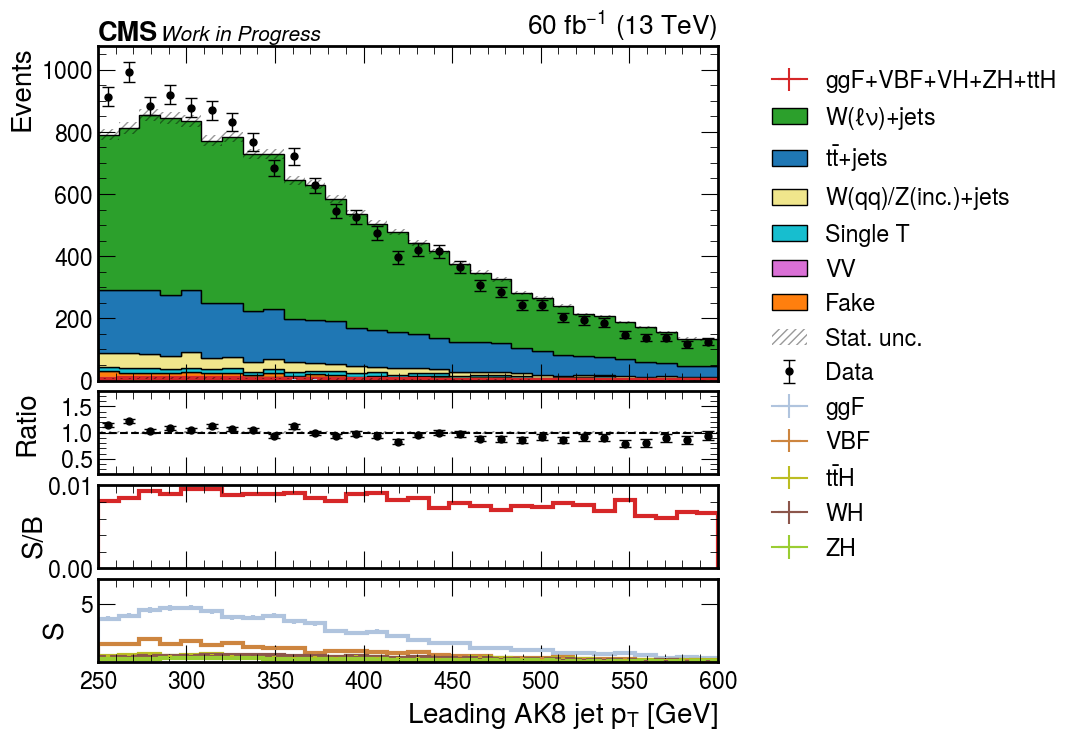

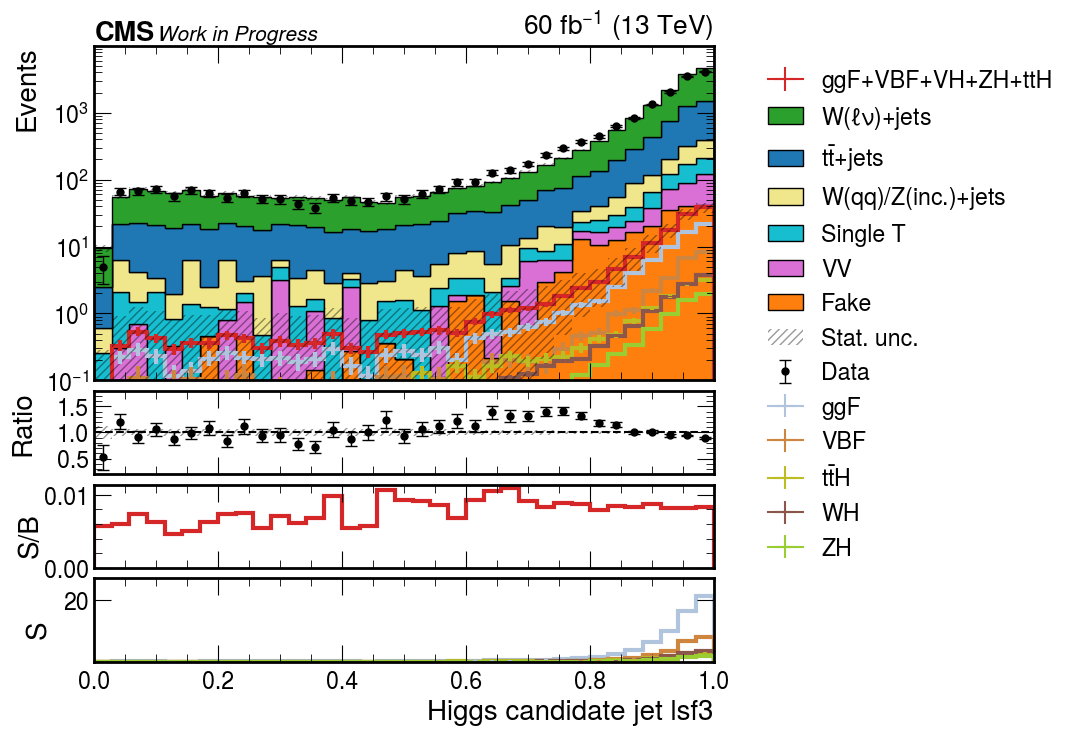

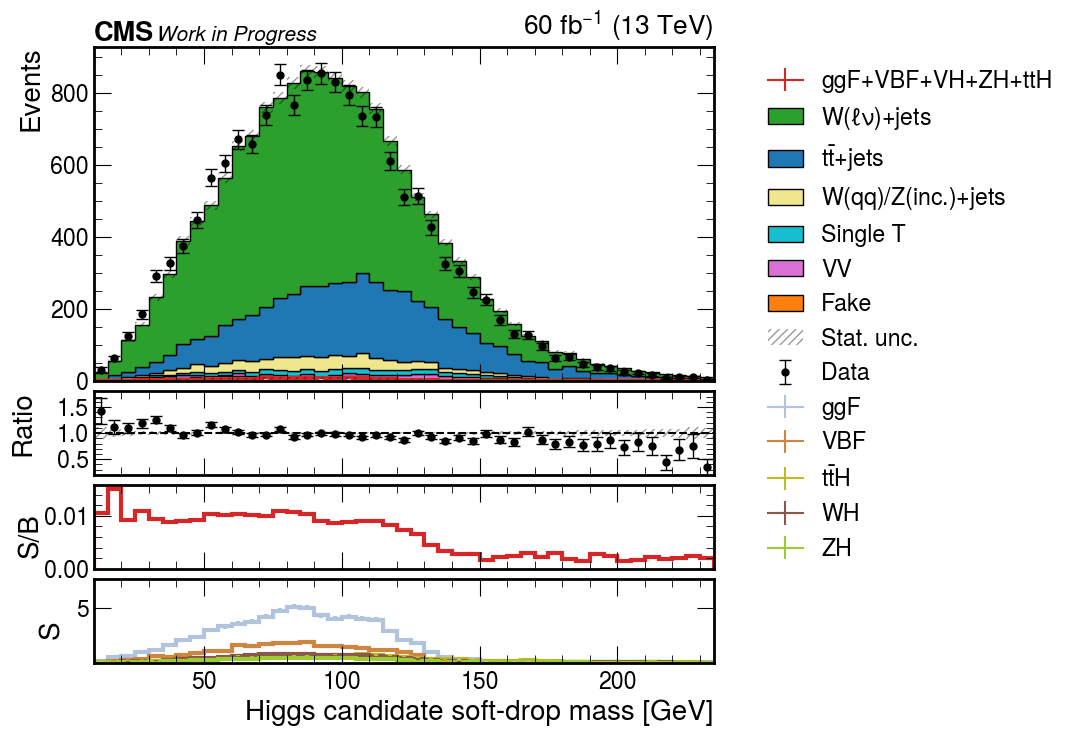

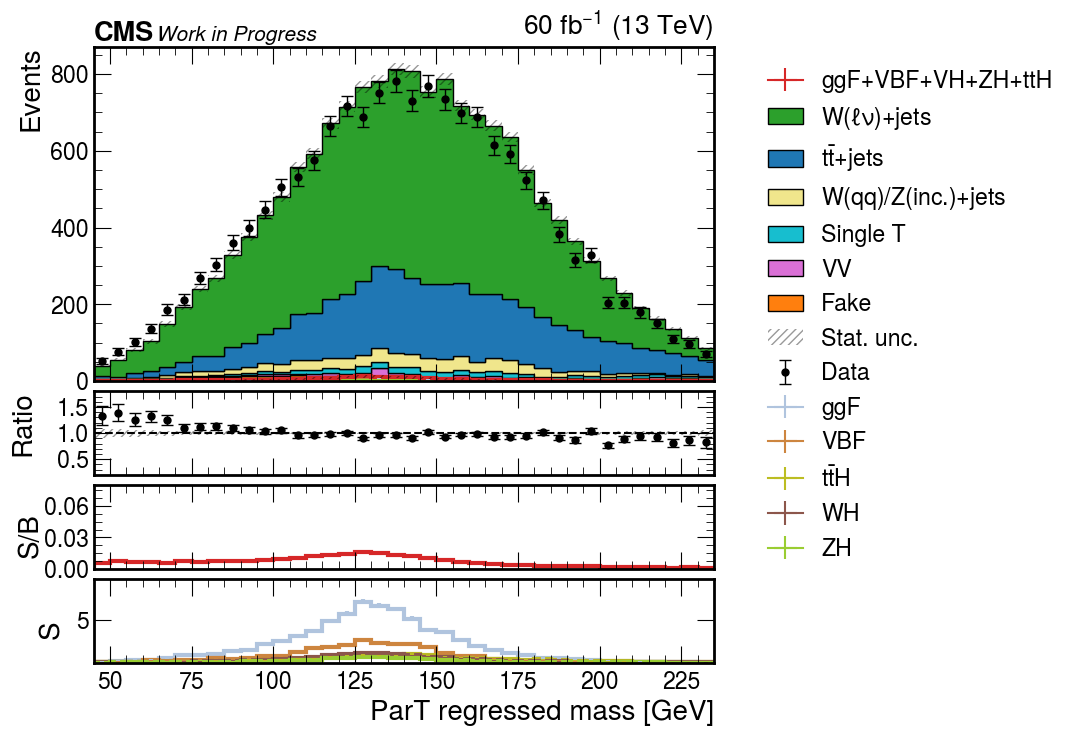

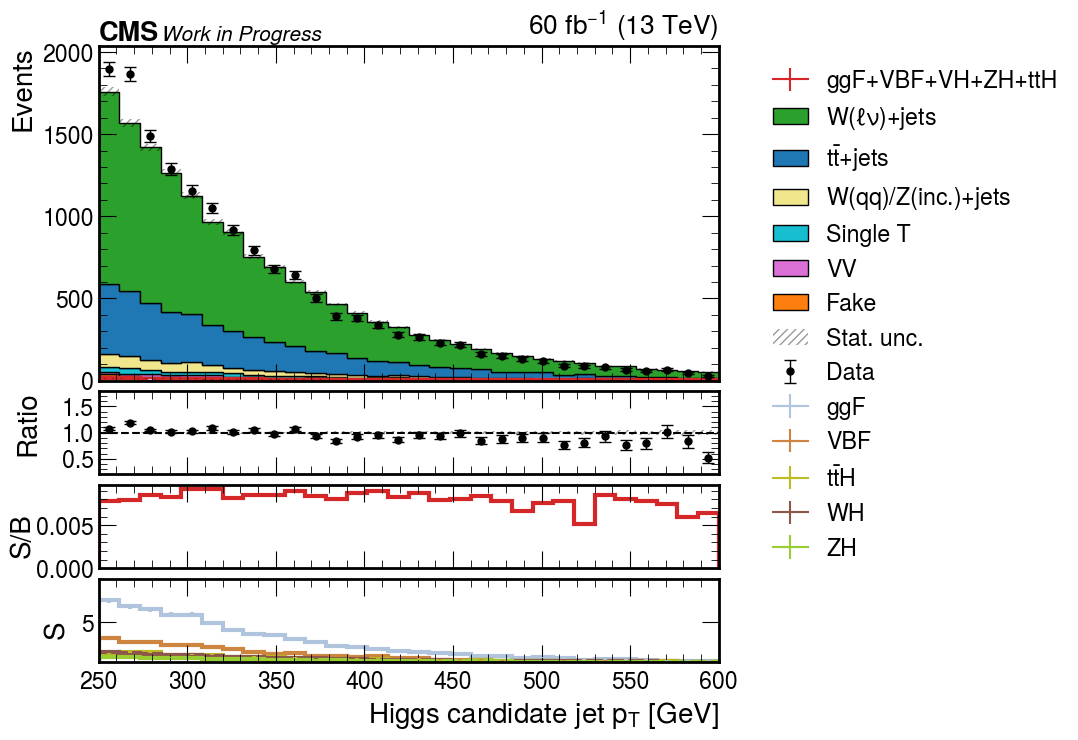

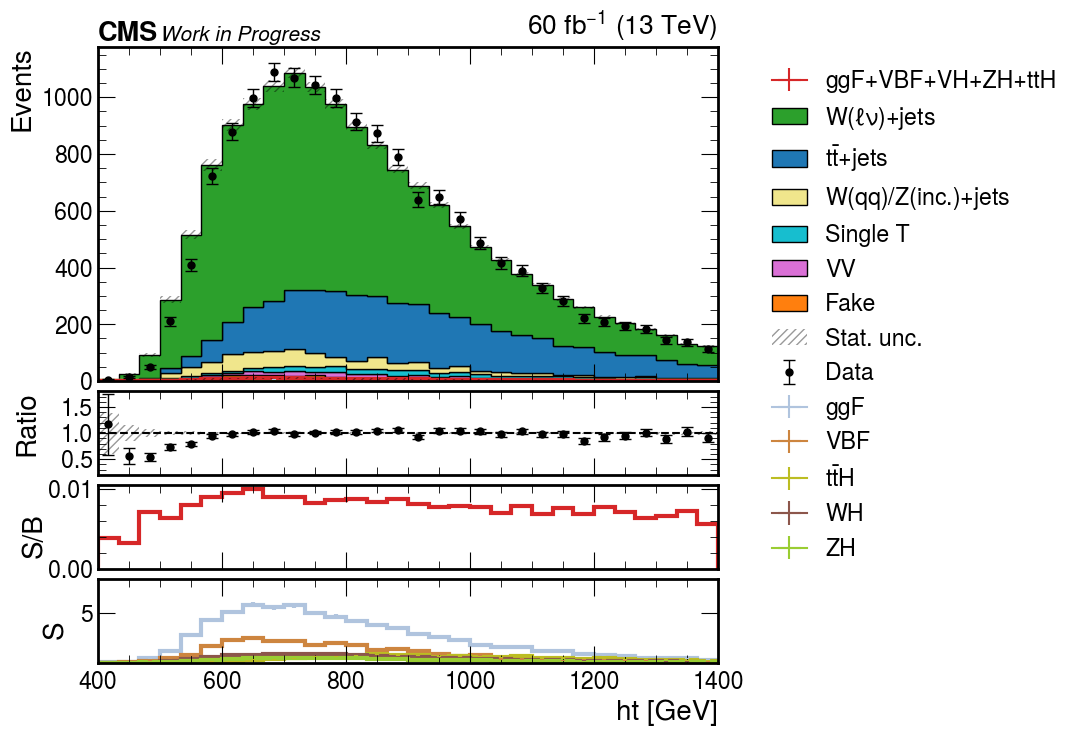

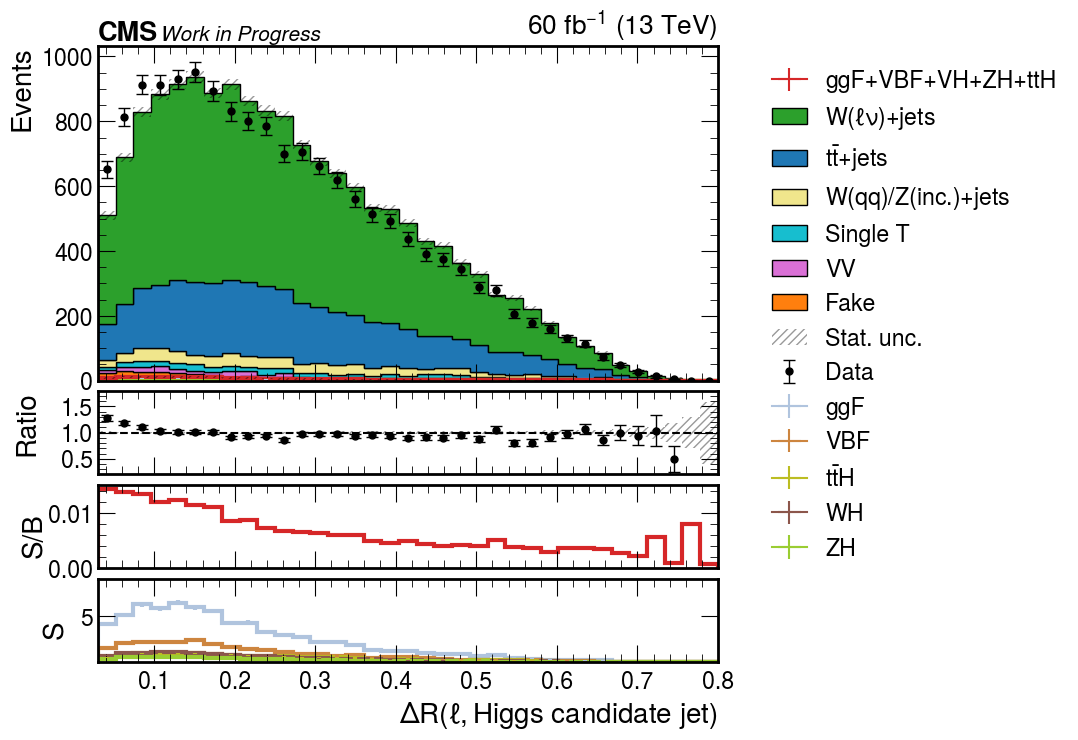

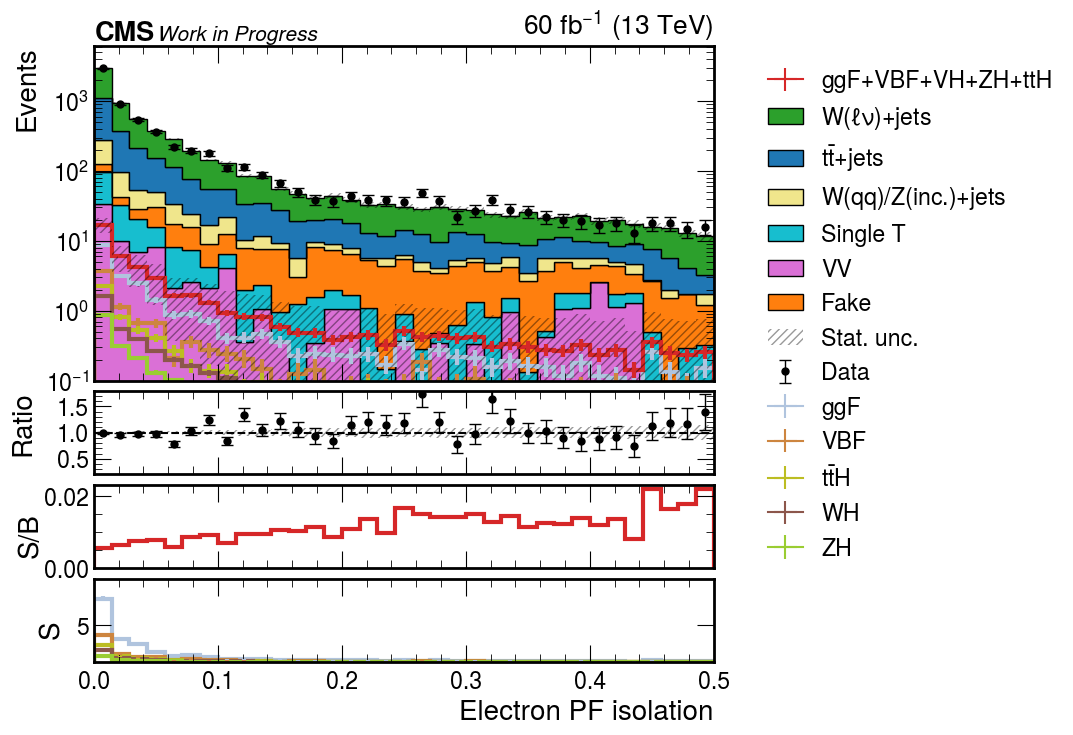

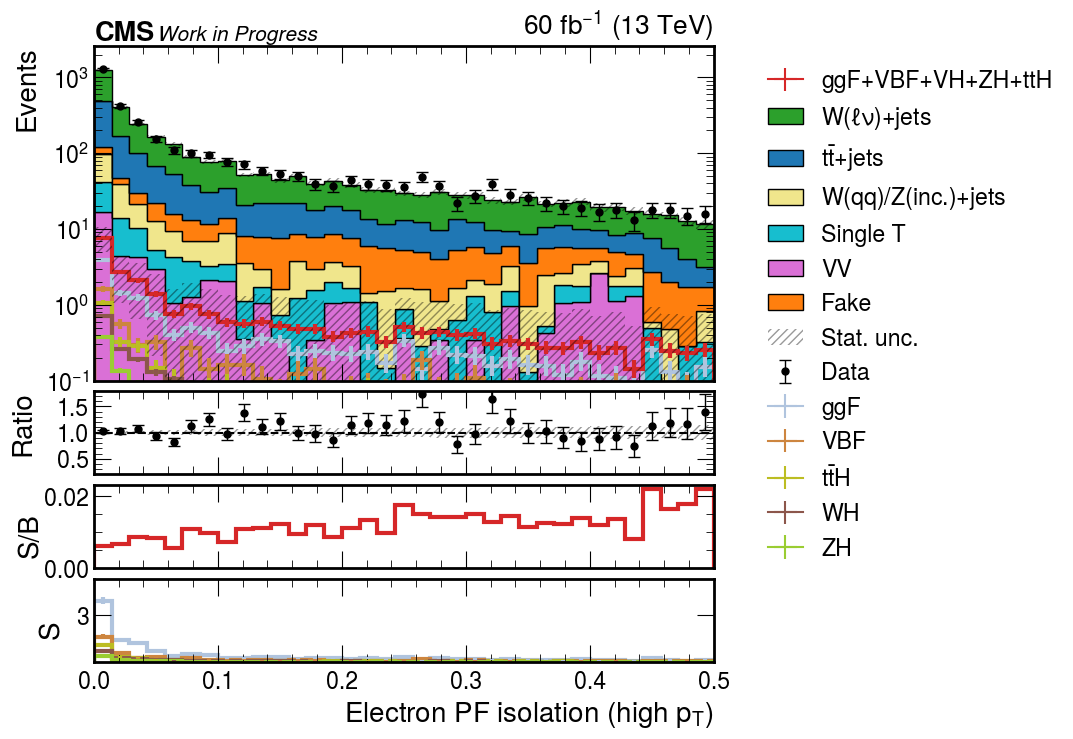

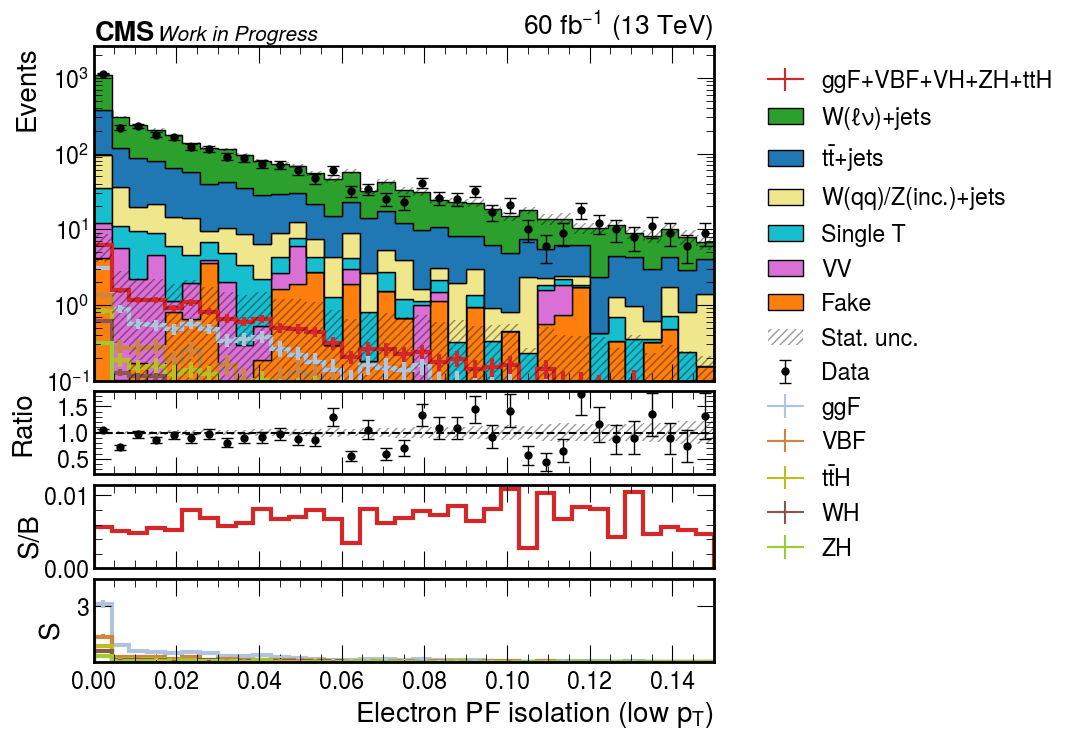

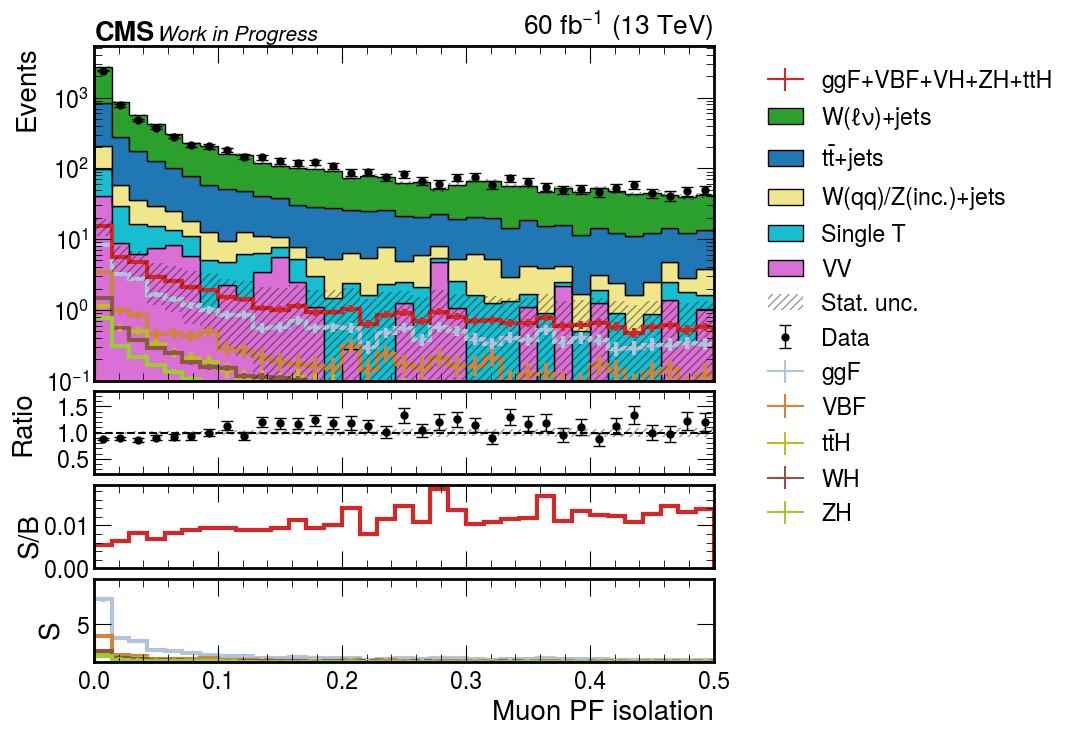

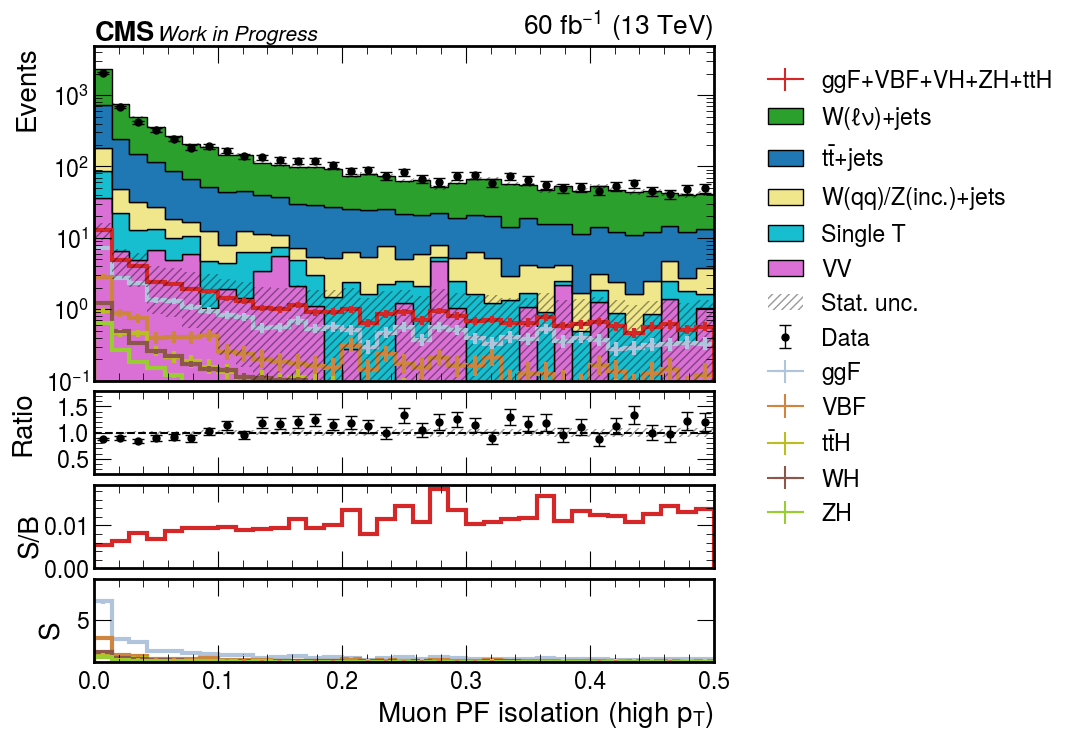

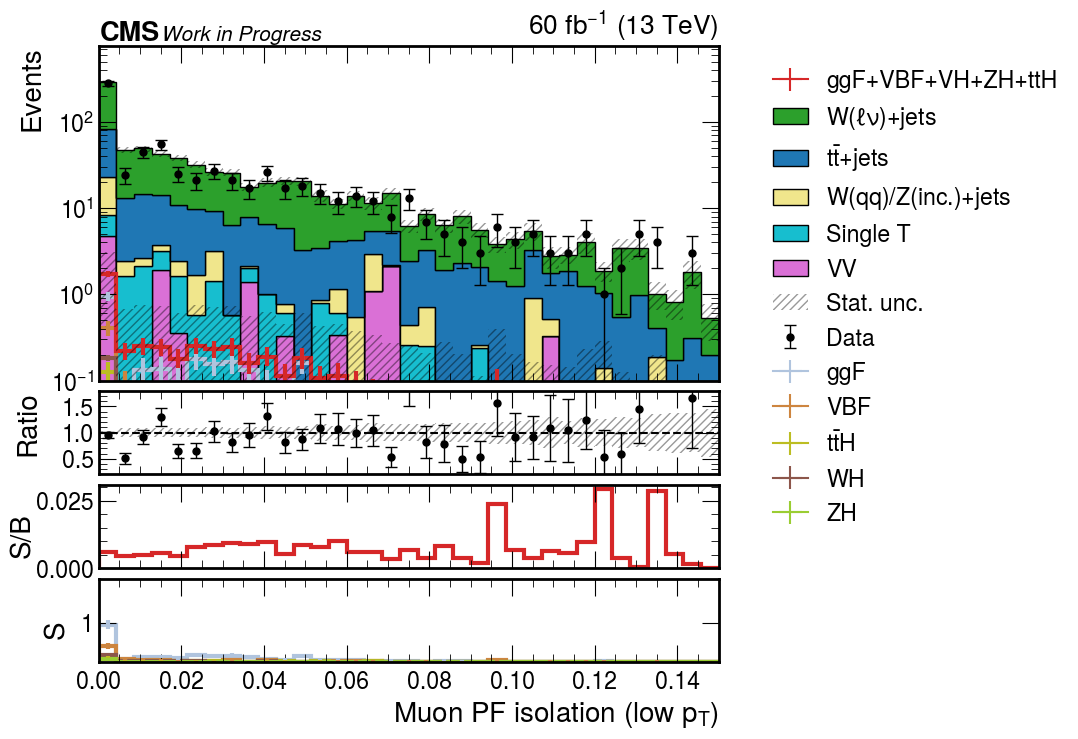

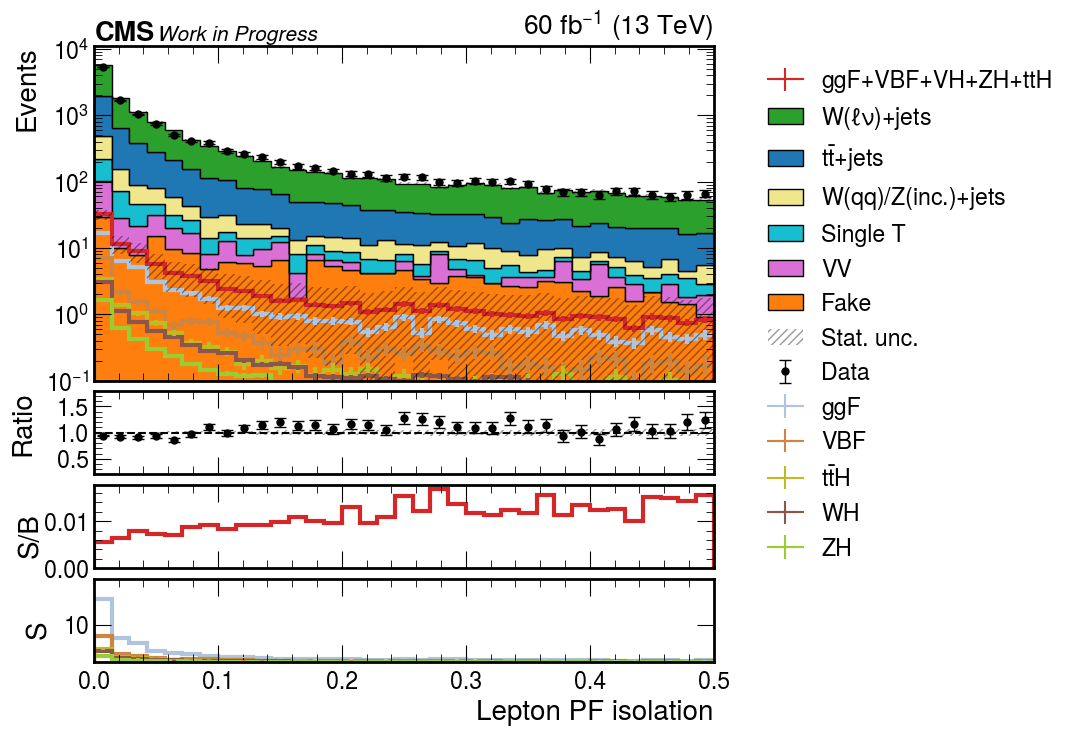

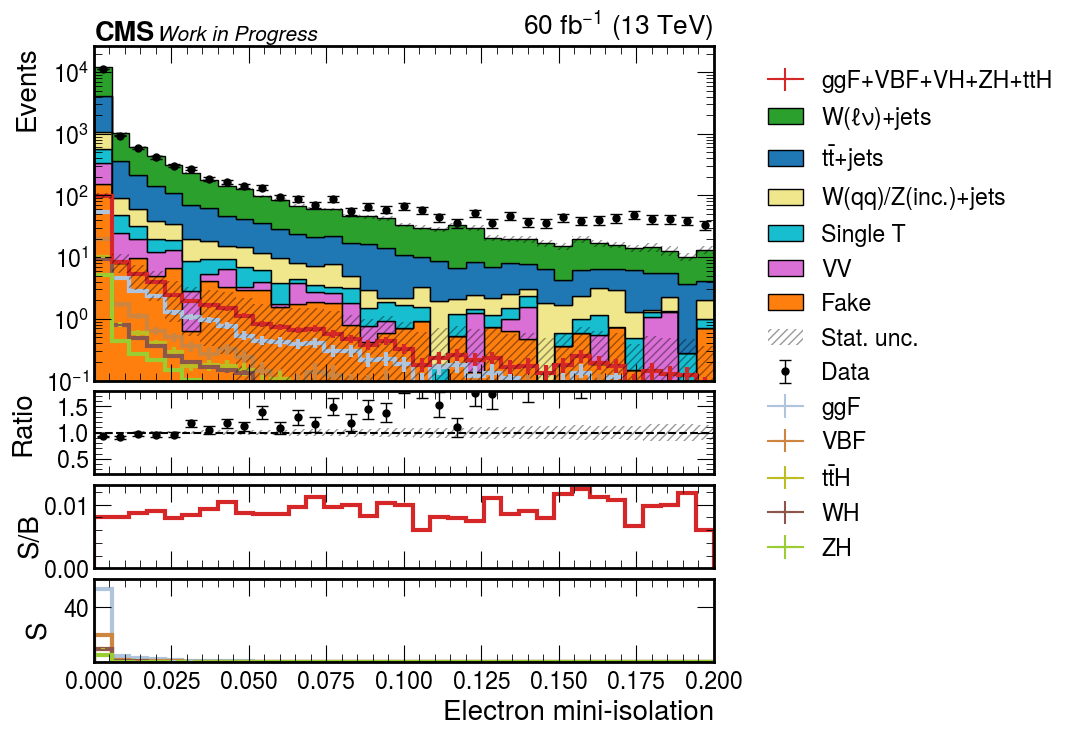

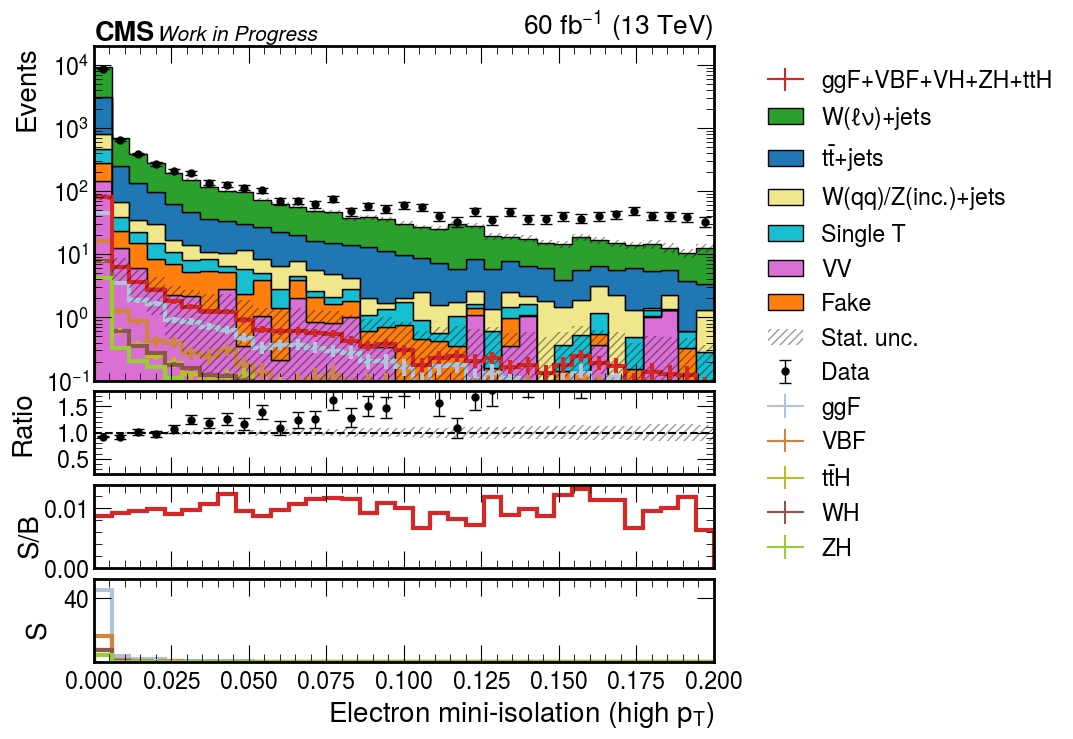

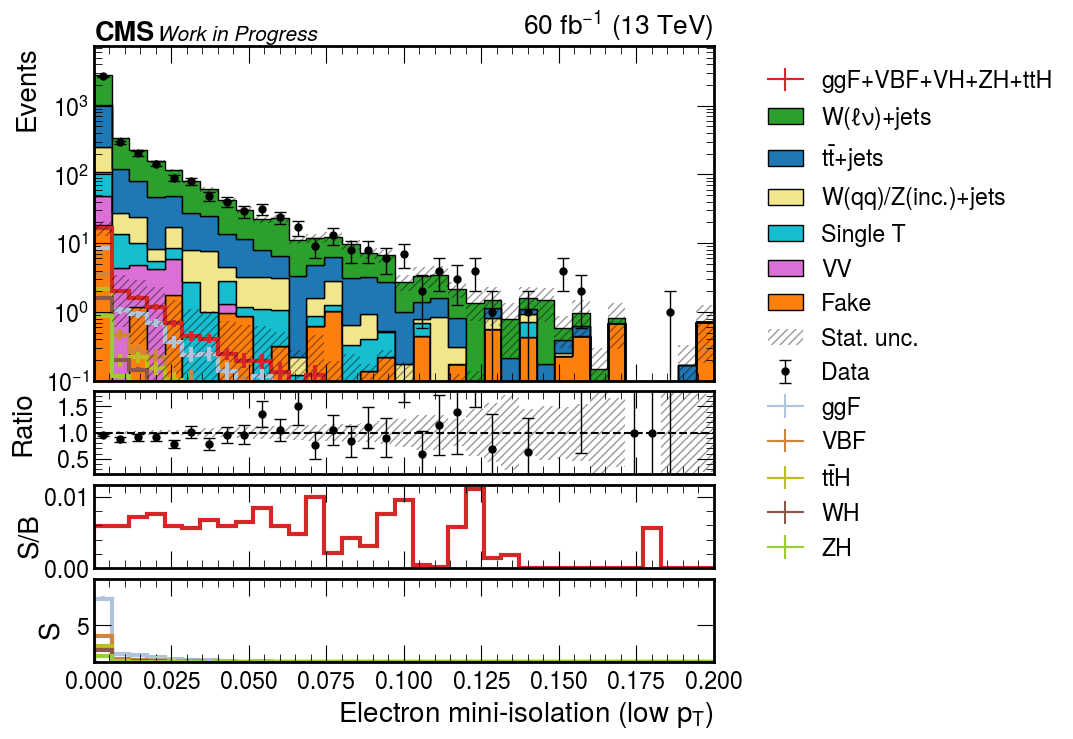

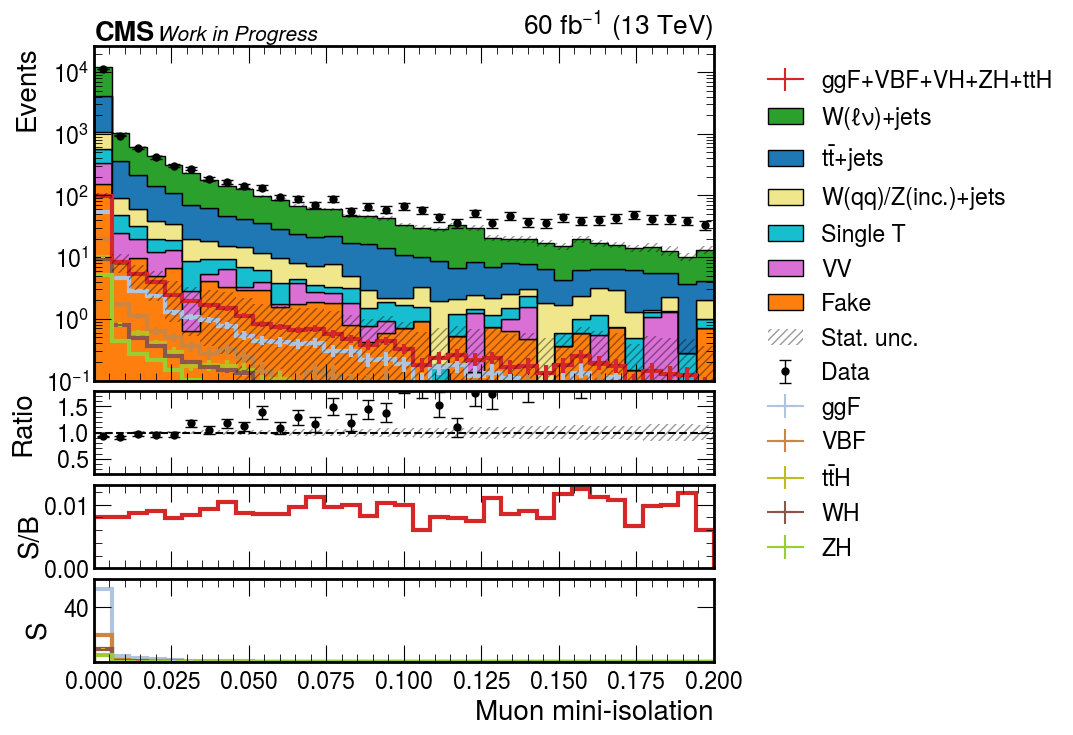

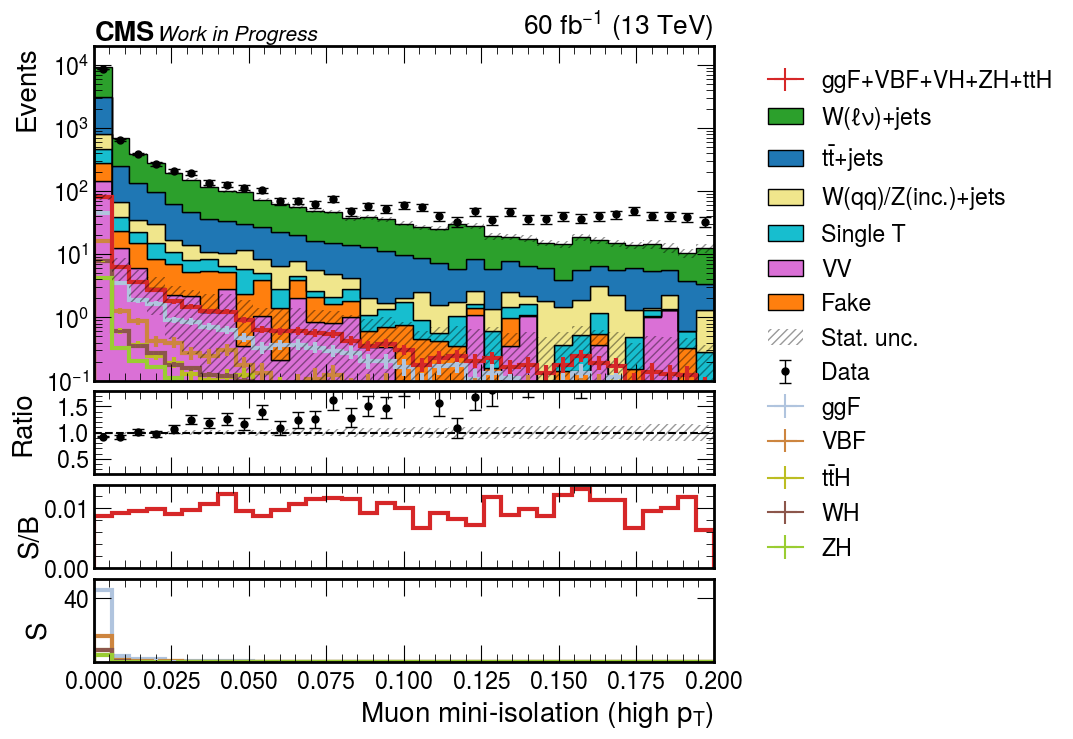

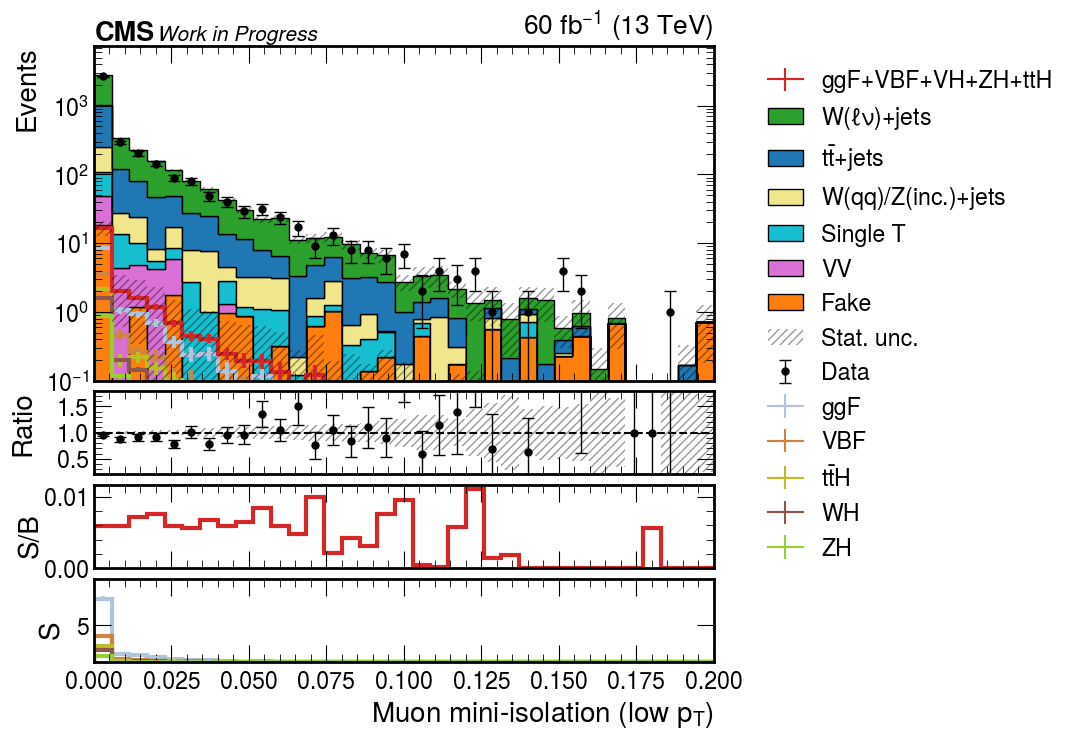

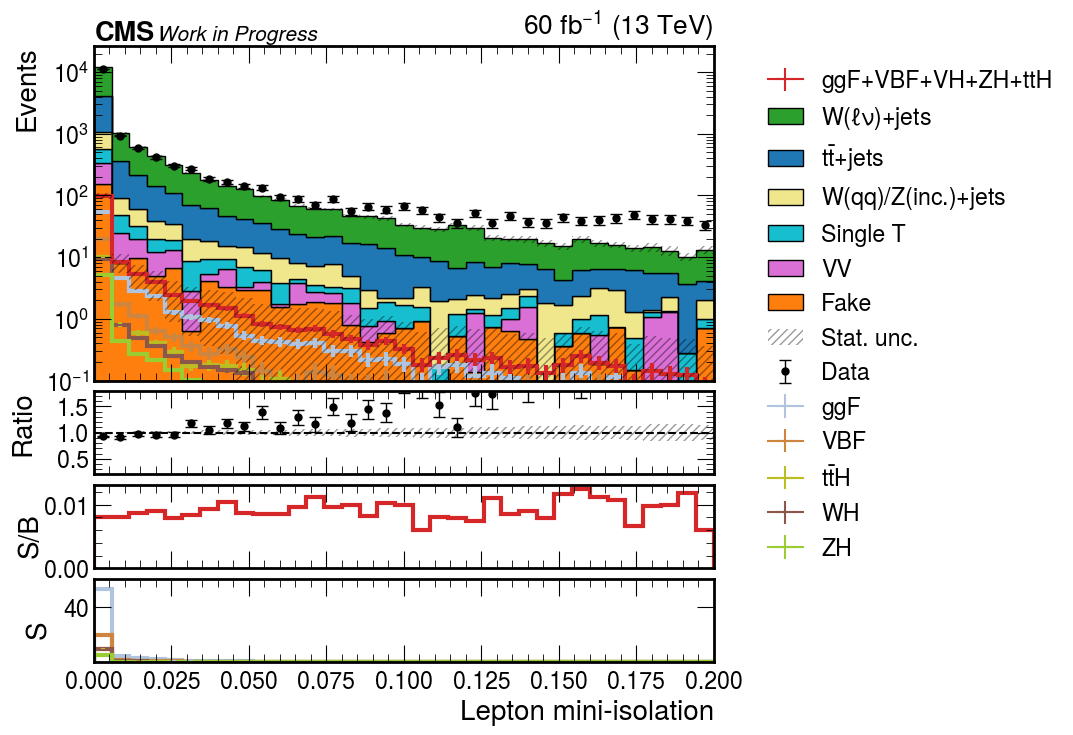

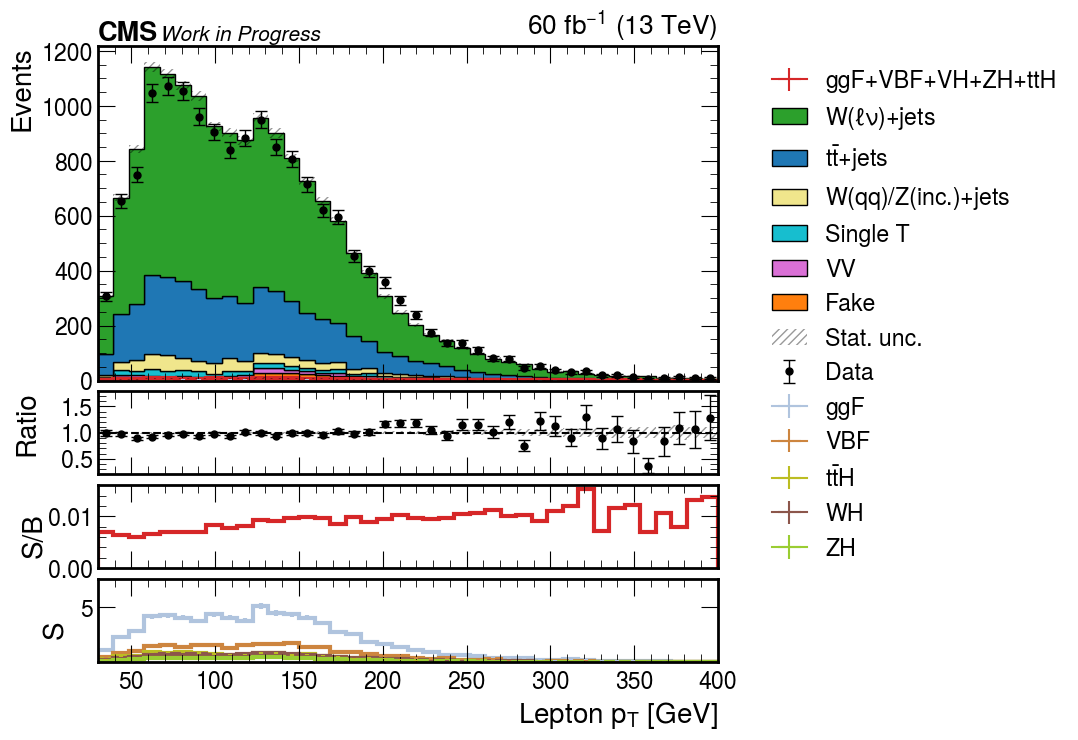

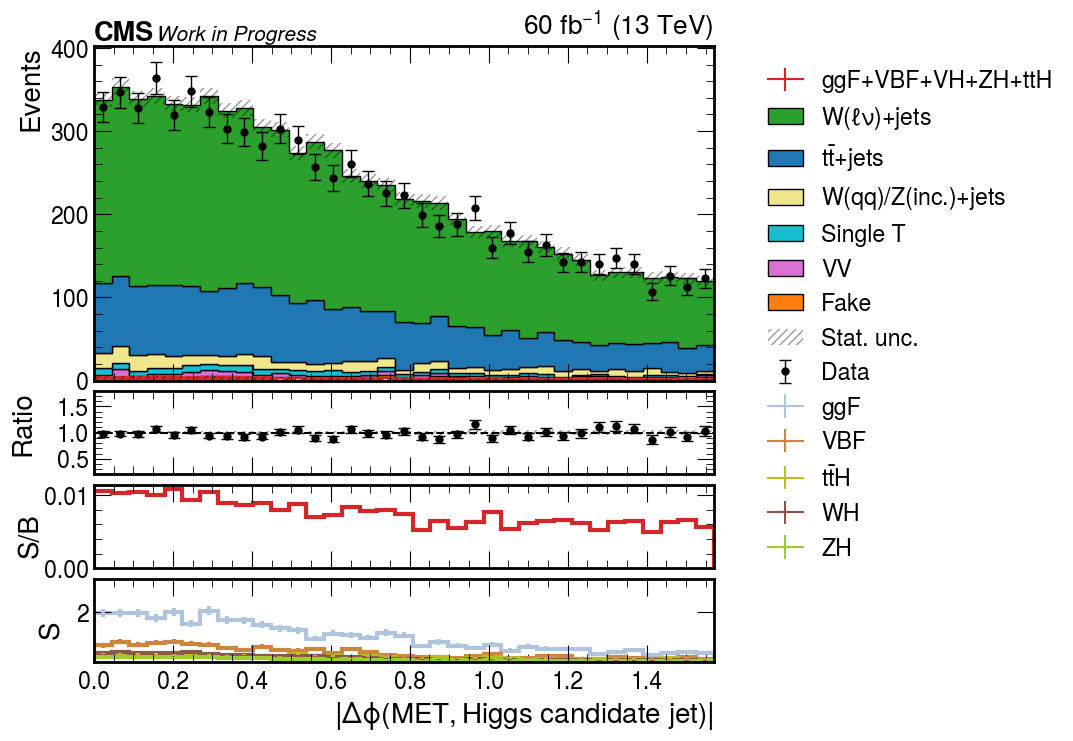

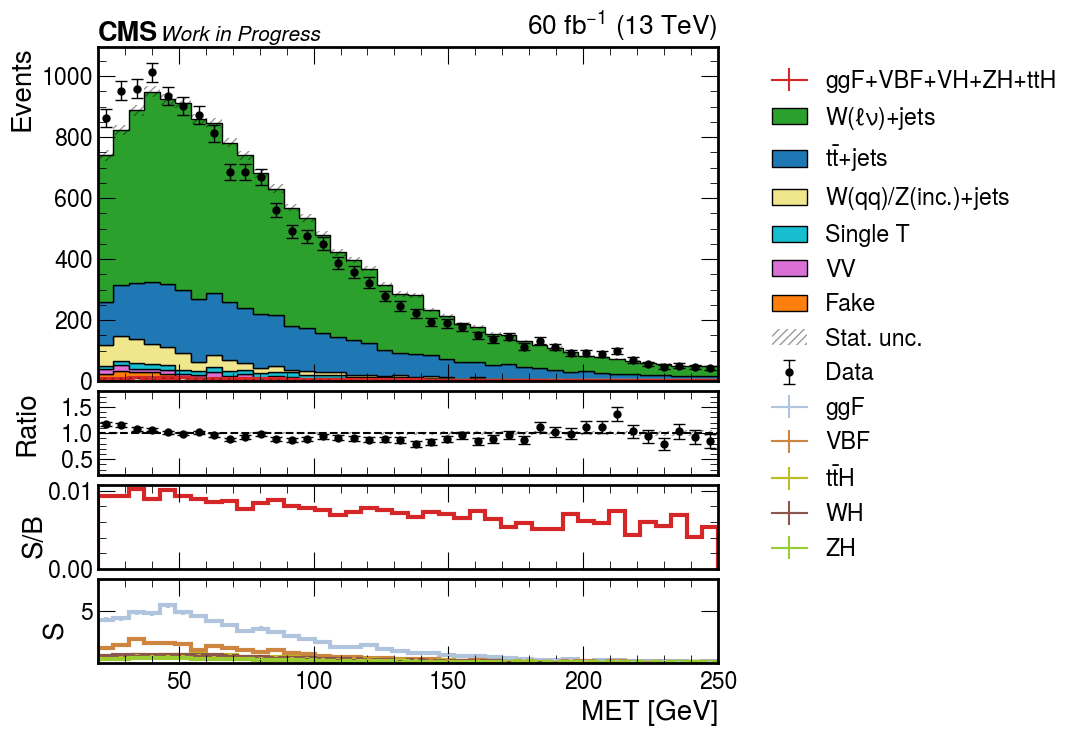

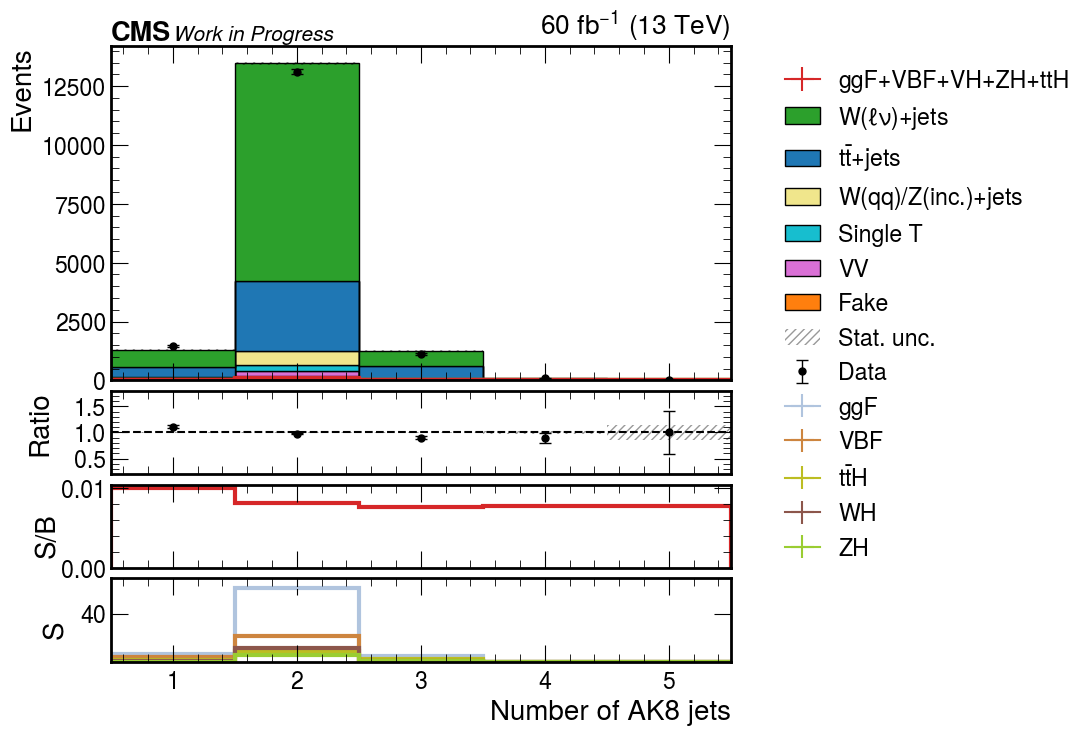

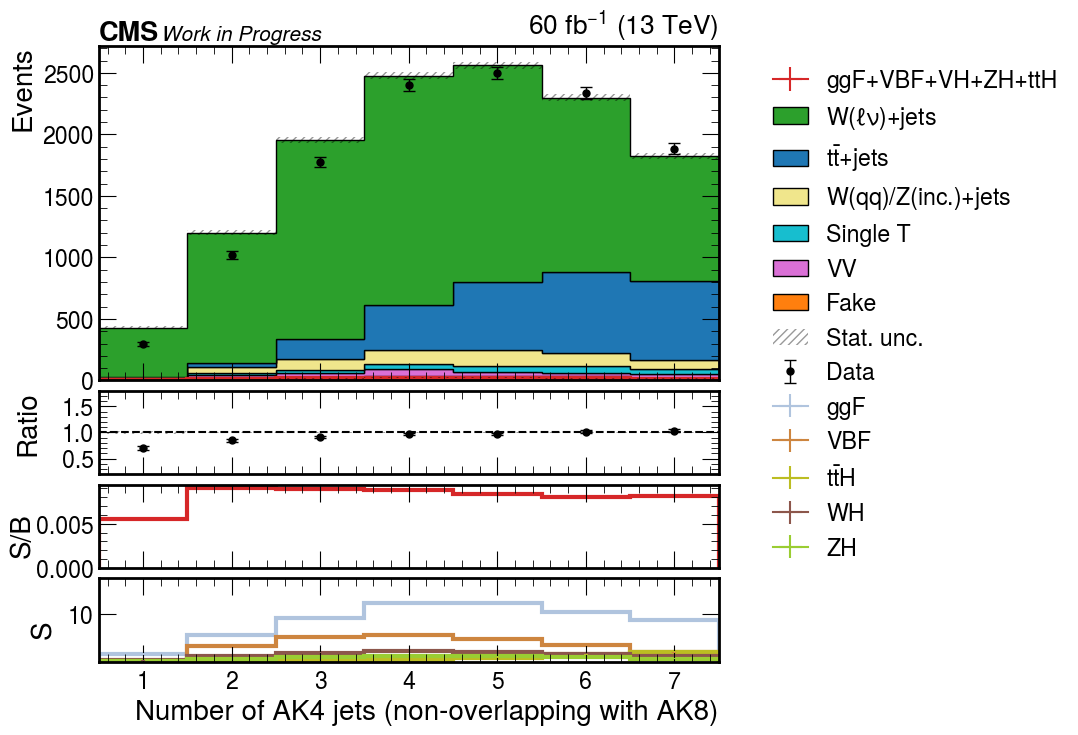

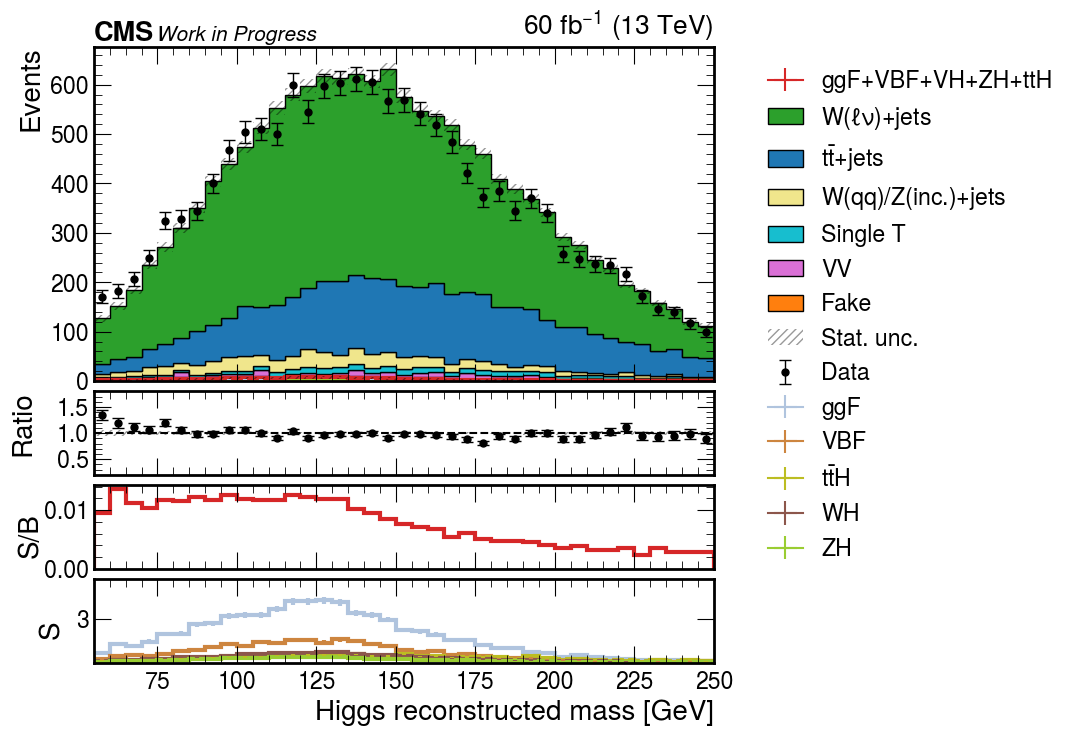

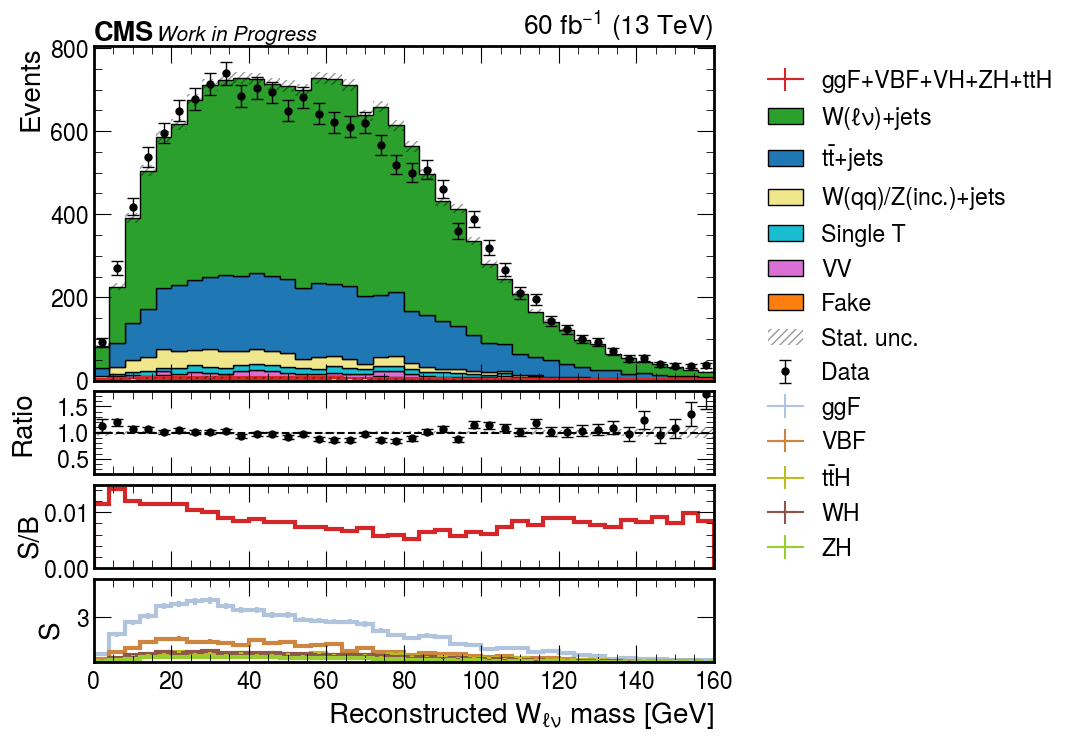

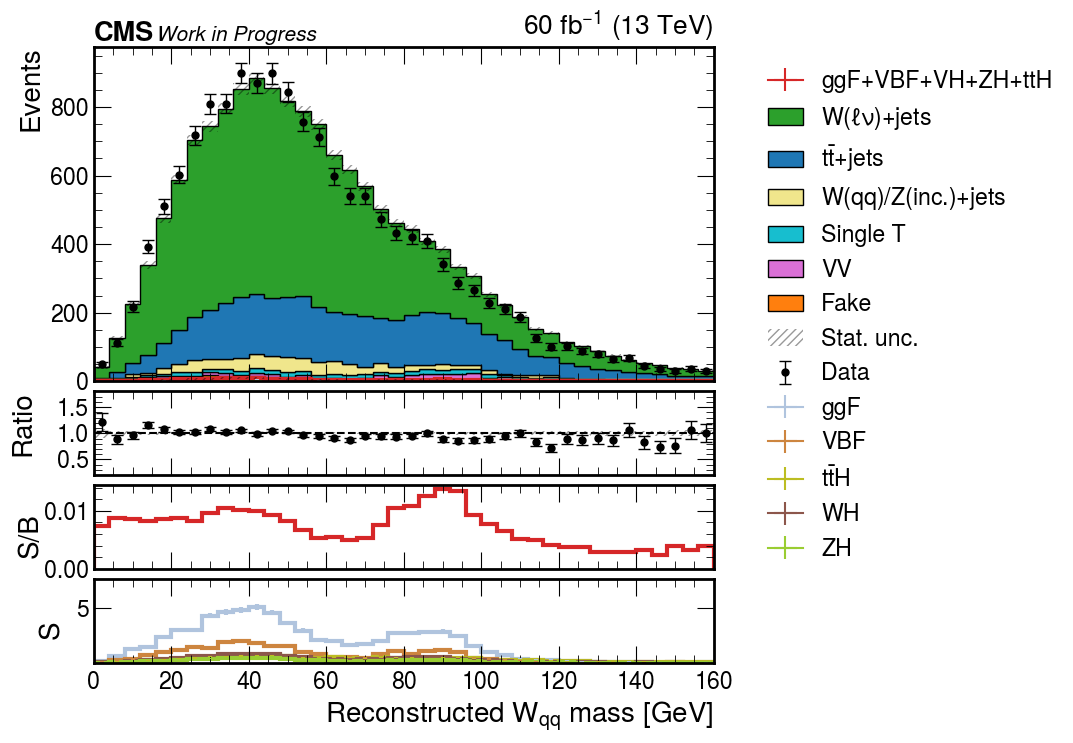

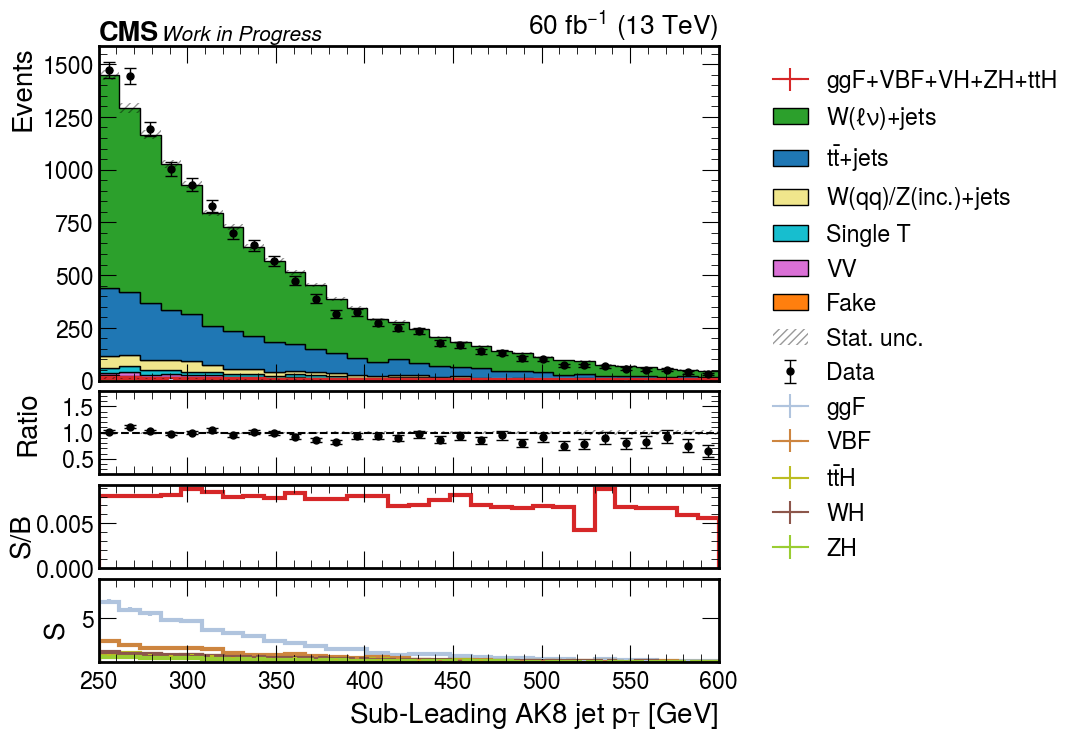

In [176]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=5
    else:
        mult=10
else:
    add_soverb=True
    blind_region=False
    mult=1
    
if "CR" in region:
    blind_region = False
    mult = 1

    
if "VBF" in categories_sel:
    mult = 5
    
if len(years) > 1:
    from utils import plot_hists as plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/WJetsCR/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/TopCR/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utils import plot_hists_sb as plot_hists

    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"
# from utils import plot_hists as plot_hists

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2_noTHWWcut/fakes/"

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}
    
plot_hists(hists, years, channels, vars_to_plot,
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
#             text_=f"{nice_ch[ch]} channel",
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",
            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
          )
# print()
# if "QCD" in samples_to_plot:
#     get_soverb(events_dict, presel, categories_sel, years, channels, precision=1)
# else:
#     get_soverb(events_dict, presel, categories_sel, years, channels, precision=1, usefake=True)    

In [229]:
tagger = "THWW"

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

massbin = 10
tagger_cuts = [
    0,
    0.1,
#     0.2,
    0.3,
#     0.4,
    0.5,
#     0.6,
    0.7,
#     0.8,
    0.9,
]
hists_M = {}

for tagger_cut in tagger_cuts:

    hists_M[tagger_cut] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
        storage=hist2.storage.Weight(),            
    )       

    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]

                df = events_dict[year][ch][sample]
                
                df = df[df["THWW"]>tagger_cut]

                x = df[var]
                w = df["event_weight"]
                
                hists_M[tagger_cut].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     

    fix_neg_yields(hists_M[tagger_cut])

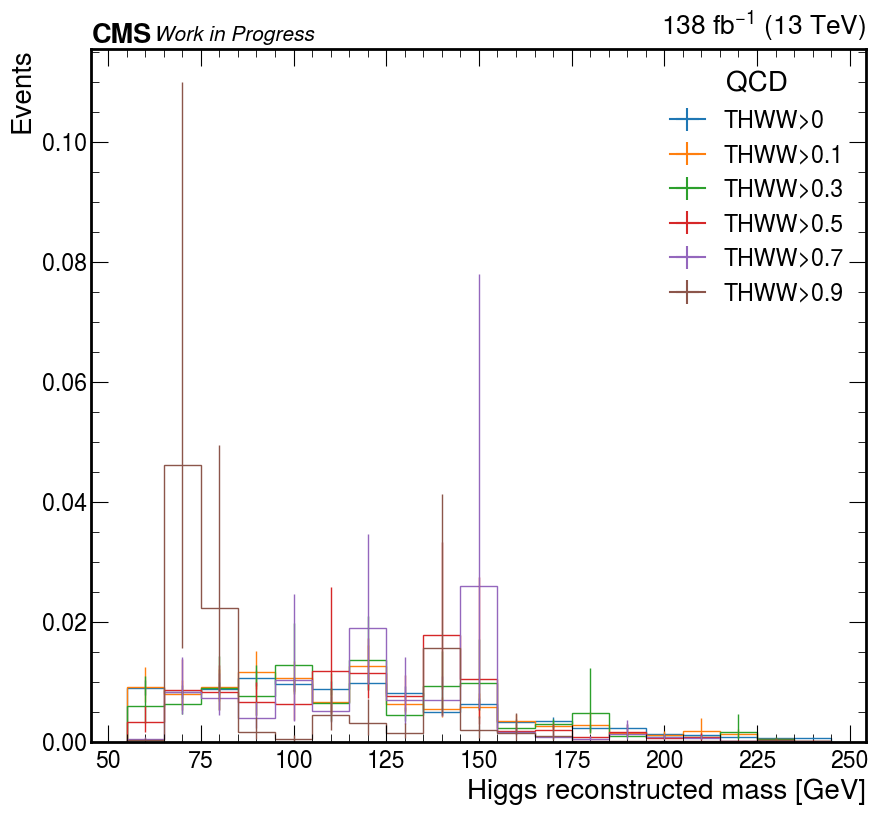

In [253]:
# different regions
samples = [
#     "WJetsLNu",
#     "TTbar",
    "QCD",
]

for sample in samples:

    fig, ax = plt.subplots(figsize=(10, 9))

    for tagger_cut in hists_M:
#         if tagger_cut>0.4:
#             continue
            
        hep.histplot(
            hists_M[tagger_cut][{"samples": sample}],
            ax=ax,
            density=True,
            linewidth=1,
            label=f"THWW>{tagger_cut}",
            flow="none",
        )


    ax.set_xlabel(hists_M[tagger_cut].axes.label[1])
    ax.legend(title=sample)
    ax.set_ylabel("Events")

    lum_=0
    for year in years:
        lum = 0
        for ch in channels:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.0f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [40]:
df = pd.read_parquet("/Users/fmokhtar/Downloads/outfiles/0-1_ele.parquet")

In [41]:
for key in df:
    print(key)

lep_pt
lep_eta
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
ht
n_bjets_L
n_bjets_M
n_bjets_T
fj_lsf3
NumFatjets
NumOtherJets
FirstFatjet_pt
FirstFatjet_eta
FirstFatjet_phi
FirstFatjet_msd
SecondFatjet_pt
SecondFatjet_eta
SecondFatjet_phi
SecondFatjet_msd
rec_higgs_m
rec_higgs_pt
rec_W_qq_m
rec_W_qq_pt
rec_W_lnu_m
rec_W_lnu_pt
fj_genH_pt
fj_genH_jet
fj_genV_dR
fj_genVstar
genV_genVstar_dR
fj_nquarks
fj_ncquarks
fj_lepinprongs
fj_H_VV_4q
fj_H_VV_elenuqq
fj_H_VV_munuqq
fj_H_VV_taunuqq
fj_H_VV_lep
fj_H_VV_isVlepton
fj_H_VV_isVstarlepton
fj_H_VV
fj_H_VV_isMatched
gen_Vlep_pt
genlep_dR_fj
fj_genRes_mass
genlep_dR_fjpt
fj_isggF
fj_genjetmass
fj_genjetpt
weight_ewkcorr
weight_qcdcorr
weight_altqcdcorr
weight_scale0
weight_scale1
weight_scale3
weight_scale5
weight_scale7
weight_scale8
weight_scale4
weight_pdf0
weight_pdf1
weight_pdf2
weight_pdf3
weight_pdf4
weight_pdf5
weight_pdf6
weight_pdf7
weight_pdf8
weight_pdf9
weight_pdf10
weight_pdf11
weight_pdf12
weight_

In [15]:
! ls ../eos/Feb9_2017/QCD_Pt_1000to1400/outfiles/0-15_ele.parquet

0-15.pkl            165-180.pkl         255-270.pkl         330-345.pkl
0-15_ele.parquet    165-180_ele.parquet 255-270_ele.parquet 330-345_ele.parquet
0-15_mu.parquet     165-180_mu.parquet  255-270_mu.parquet  330-345_mu.parquet
105-120.pkl         180-195.pkl         270-285.pkl         45-60.pkl
105-120_ele.parquet 180-195_ele.parquet 270-285_ele.parquet 45-60_ele.parquet
105-120_mu.parquet  180-195_mu.parquet  270-285_mu.parquet  45-60_mu.parquet
120-135.pkl         195-210.pkl         285-300.pkl         60-75.pkl
120-135_ele.parquet 195-210_ele.parquet 285-300_ele.parquet 60-75_ele.parquet
120-135_mu.parquet  195-210_mu.parquet  285-300_mu.parquet  60-75_mu.parquet
135-150.pkl         210-225.pkl         30-45.pkl           75-90.pkl
135-150_ele.parquet 210-225_ele.parquet 30-45_ele.parquet   75-90_ele.parquet
135-150_mu.parquet  210-225_mu.parquet  30-45_mu.parquet    75-90_mu.parquet
15-30.pkl           225-240.pkl         300-315.pkl         90-105.pkl
15-30_ele.parquet   225

In [16]:
df = pd.read_parquet("../eos/Feb9_2017/QCD_Pt_1000to1400/outfiles/0-15_ele.parquet")

In [19]:
df["fj_pt"]

0      686.997925
1     1299.212524
2     1020.104614
3      430.419830
4     1020.620789
5     1277.179565
6     1553.065796
7     1585.515991
8     1091.156372
9     1116.250244
10     999.326660
11    1455.434204
12    1128.448975
13     937.976013
14     893.440186
15    1266.838745
Name: fj_pt, dtype: float32

In [20]:
df["fj_eta"]

0    -0.994873
1     0.832031
2     1.378174
3     1.572021
4    -1.097656
5    -1.471436
6     1.185547
7    -1.442139
8     0.603394
9     0.498413
10    1.180908
11    0.530396
12    1.121826
13   -1.193604
14    0.798706
15   -0.561157
Name: fj_eta, dtype: float32

In [21]:
df["fj_phi"]

0    -2.451172
1     0.786743
2    -2.538086
3    -1.435059
4     0.043030
5     2.795410
6     1.931396
7     2.848145
8     2.800293
9    -0.027325
10    0.835938
11    2.435059
12    0.935547
13   -1.933838
14   -2.079590
15   -1.020996
Name: fj_phi, dtype: float32

In [26]:
df["fj_mass"]

0     116.233372
1     328.750886
2     370.511916
3     100.815493
4     136.133319
5     198.030987
6     457.777069
7     331.145072
8     265.046692
9     246.085946
10    127.447556
11    258.836696
12    366.989057
13    302.134231
14      0.182835
15    307.161488
Name: fj_mass, dtype: float64

In [452]:
w = np.concatenate([df["lep_pt"].values.reshape(-1,1), df["fj_isggF"].values.reshape(-1,1)], axis=1)

In [455]:
w.shape

(205, 2)

In [456]:
a = {}

In [161]:
 df.loc[:, df.columns.str.contains("pdf")]

weight_pdf0  weight_pdf1  weight_pdf2  weight_pdf3  weight_pdf4  \
2             1.0     1.000854     0.999420     1.002441     0.998871   
9             1.0     0.999329     0.999237     0.998352     1.003235   
10            1.0     0.998413     0.997772     0.999268     1.004089   
11            1.0     0.997833     0.998383     1.002014     1.001526   
16            1.0     0.992706     1.011902     0.990753     0.994843   
...           ...          ...          ...          ...          ...   
4727          1.0     0.998535     0.998047     0.998718     1.003418   
4729          1.0     1.000366     0.998840     1.002319     0.998566   
4731          1.0     0.999481     0.999023     0.997711     1.004395   
4735          1.0     1.000916     0.999298     1.001526     0.998199   
4738          1.0     1.001770     0.996735     0.998871     1.001831   

      weight_pdf5  weight_pdf6  weight_pdf7  weight_pdf8  weight_pdf9  ...  \
2        1.005310     0.999298     1.003601     1.003235     1.000183  ...   
9        0.993744     1.001465     0.997894     0.997833     0.996094  ...   
10       0.997894     1.002625     1.002136     1.002136     1.001221  ...   
11       0.997437     1.000916     0.996887     0.997986     0.999603  ...   
16       1.000854     1.006653     1.015930     1.015137     0.987701  ...   
...           ...          ...          ...          ...          ...  ...   
4727     0.997284     1.002136     0.999634     0.999847     1.001465  ...   
4729     1.004761     1.000244     1.002441     1.003357     0.998444  ...   
4731     0.995148     1.001526     1.000061     1.000610     0.998596  ...   
4735     1.004517     0.999084     1.000305     1.000793     1.000427  ...   
4738     1.001892     1.002747     1.001831     1.005615     0.998260  ...   

      weight_pdf93  weight_pdf94  weight_pdf95  weight_pdf96  weight_pdf97  \
2         1.000000      1.000183      1.000427      0.999878      0.999969   
9         0.999054      1.000183      1.000671      0.999634      1.000549   
10        0.999756      1.000061      1.000366      0.999847      1.000244   
11        0.999817      1.000183      1.000366      0.999847      1.000244   
16        1.000488      1.005310      1.001831      0.993835      0.999817   
...            ...           ...           ...           ...           ...   
4727      0.999725      1.000122      1.000427      0.999786      1.000305   
4729      0.999756      1.000244      1.000366      0.999664      0.999695   
4731      0.999298      1.000000      1.000549      0.999664      1.000366   
4735      0.999908      1.000244      1.000488      0.999847      0.999939   
4738      0.999756      1.000000      1.000061      0.999908      1.000061   

      weight_pdf98  weight_pdf99  weight_pdf100  weight_pdf101  weight_pdf102  
2         0.999939      1.000305            1.0       0.953278       1.044189  
9         1.000305      1.000244            1.0       0.951813       1.047424  
10        0.999939      1.000183            1.0       0.964233       1.040344  
11        0.999847      1.000183            1.0       0.958893       1.049622  
16        0.999756      1.003174            1.0       0.968262       1.058899  
...            ...           ...            ...            ...            ...  
4727      0.999939      1.000183            1.0       0.961395       1.046387  
4729      1.000000      1.000366            1.0       0.957153       1.042664  
4731      1.000183      1.000244            1.0       0.955902       1.040771  
4735      0.999908      1.000305            1.0       0.952576       1.047546  
4738      1.000061      1.000183            1.0       0.960449       1.040771  

[1434 rows x 103 columns]

In [273]:
 df.loc[:, df.columns.str.contains("scale")]

weight_scale0  weight_scale1  weight_scale3  weight_scale5  \
2          1.167725       1.166687       1.006165       0.995850   
9          1.267029       1.187561       1.077271       0.938354   
10         1.129700       1.132446       1.017456       0.985352   
11         1.278687       1.208496       1.068237       0.942932   
16         1.147217       1.134705       1.024353       0.980072   
...             ...            ...            ...            ...   
4727       1.246704       1.183411       1.063904       0.947998   
4729       1.177246       1.184082       1.006409       0.995178   
4731       1.052063       1.087402       1.004089       0.992920   
4735       1.237488       1.197327       1.039795       0.966797   
4738       1.093567       1.092590       1.019104       0.985352   

      weight_scale7  weight_scale8  weight_scale4  
2          0.848999       0.841797            1.0  
9          0.851349       0.792694            1.0  
10         0.865570       0.843018            1.0  
11         0.830566       0.778015            1.0  
16         0.866211       0.841827            1.0  
...             ...            ...            ...  
4727       0.841705       0.792389            1.0  
4729       0.842255       0.831390            1.0  
4731       0.886353       0.864349            1.0  
4735       0.836151       0.804718            1.0  
4738       0.883942       0.861633            1.0  

[1434 rows x 7 columns]

In [274]:
 df.loc[:, df.columns.str.contains("pdf")]

weight_pdf0  weight_pdf1  weight_pdf2  weight_pdf3  weight_pdf4  \
2             1.0     1.000854     0.999420     1.002441     0.998871   
9             1.0     0.999329     0.999237     0.998352     1.003235   
10            1.0     0.998413     0.997772     0.999268     1.004089   
11            1.0     0.997833     0.998383     1.002014     1.001526   
16            1.0     0.992706     1.011902     0.990753     0.994843   
...           ...          ...          ...          ...          ...   
4727          1.0     0.998535     0.998047     0.998718     1.003418   
4729          1.0     1.000366     0.998840     1.002319     0.998566   
4731          1.0     0.999481     0.999023     0.997711     1.004395   
4735          1.0     1.000916     0.999298     1.001526     0.998199   
4738          1.0     1.001770     0.996735     0.998871     1.001831   

      weight_pdf5  weight_pdf6  weight_pdf7  weight_pdf8  weight_pdf9  ...  \
2        1.005310     0.999298     1.003601     1.003235     1.000183  ...   
9        0.993744     1.001465     0.997894     0.997833     0.996094  ...   
10       0.997894     1.002625     1.002136     1.002136     1.001221  ...   
11       0.997437     1.000916     0.996887     0.997986     0.999603  ...   
16       1.000854     1.006653     1.015930     1.015137     0.987701  ...   
...           ...          ...          ...          ...          ...  ...   
4727     0.997284     1.002136     0.999634     0.999847     1.001465  ...   
4729     1.004761     1.000244     1.002441     1.003357     0.998444  ...   
4731     0.995148     1.001526     1.000061     1.000610     0.998596  ...   
4735     1.004517     0.999084     1.000305     1.000793     1.000427  ...   
4738     1.001892     1.002747     1.001831     1.005615     0.998260  ...   

      weight_pdf93  weight_pdf94  weight_pdf95  weight_pdf96  weight_pdf97  \
2         1.000000      1.000183      1.000427      0.999878      0.999969   
9         0.999054      1.000183      1.000671      0.999634      1.000549   
10        0.999756      1.000061      1.000366      0.999847      1.000244   
11        0.999817      1.000183      1.000366      0.999847      1.000244   
16        1.000488      1.005310      1.001831      0.993835      0.999817   
...            ...           ...           ...           ...           ...   
4727      0.999725      1.000122      1.000427      0.999786      1.000305   
4729      0.999756      1.000244      1.000366      0.999664      0.999695   
4731      0.999298      1.000000      1.000549      0.999664      1.000366   
4735      0.999908      1.000244      1.000488      0.999847      0.999939   
4738      0.999756      1.000000      1.000061      0.999908      1.000061   

      weight_pdf98  weight_pdf99  weight_pdf100  weight_pdf101  weight_pdf102  
2         0.999939      1.000305            1.0       0.953278       1.044189  
9         1.000305      1.000244            1.0       0.951813       1.047424  
10        0.999939      1.000183            1.0       0.964233       1.040344  
11        0.999847      1.000183            1.0       0.958893       1.049622  
16        0.999756      1.003174            1.0       0.968262       1.058899  
...            ...           ...            ...            ...            ...  
4727      0.999939      1.000183            1.0       0.961395       1.046387  
4729      1.000000      1.000366            1.0       0.957153       1.042664  
4731      1.000183      1.000244            1.0       0.955902       1.040771  
4735      0.999908      1.000305            1.0       0.952576       1.047546  
4738      1.000061      1.000183            1.0       0.960449       1.040771  

[1434 rows x 103 columns]

In [294]:
nominal = df["event_weight"]
nominal

2       0.007575
9       0.008623
10      0.008213
11      0.008169
16      0.007928
          ...   
4727    0.006962
4729    0.007942
4731    0.006816
4735    0.009402
4738    0.007878
Name: event_weight, Length: 1434, dtype: float64

In [295]:
pdfweights = nominal.values.reshape(-1,1) * df.loc[:, df.columns.str.contains("pdf")].values
pdfweights

array([[0.00757504, 0.00758152, 0.00757065, ..., 0.00757504, 0.00722112,
        0.00790978],
       [0.00862349, 0.0086177 , 0.00861691, ..., 0.00862349, 0.00820794,
        0.00903245],
       [0.00821303, 0.0082    , 0.00819473, ..., 0.00821303, 0.00791928,
        0.00854438],
       ...,
       [0.00681601, 0.00681248, 0.00680936, ..., 0.00681601, 0.00651544,
        0.00709391],
       [0.00940242, 0.00941103, 0.00939582, ..., 0.00940242, 0.00895651,
        0.00984947],
       [0.00787773, 0.00789168, 0.00785201, ..., 0.00787773, 0.00756616,
        0.00819892]])

In [296]:
nominal = (nominal * df["rec_higgs_m"]).values.reshape(-1,1)
pdfweights = pdfweights * df["rec_higgs_m"].values.reshape(-1,1)

In [297]:
abs_unc = np.linalg.norm((pdfweights - nominal), axis=1)
abs_unc

array([0.06647062, 0.07915931, 0.04285413, ..., 0.04296059, 0.10354782,
       0.06159112])

In [298]:
                                    rel_unc = np.clip(abs_unc / nominal, 0, 1)
                                    shape_up = nominal * (1 + rel_unc)
                                    shape_down = nominal * (1 - rel_unc)

In [299]:
shape_up

array([[1.07132703, 1.08401573, 1.04771055, ..., 1.04781701, 1.10840424,
        1.06644754],
       [1.17193979, 1.18462849, 1.1483233 , ..., 1.14842976, 1.20901699,
        1.16706029],
       [0.8300606 , 0.8427493 , 0.80644412, ..., 0.80655058, 0.86713781,
        0.82518111],
       ...,
       [0.74597601, 0.75866471, 0.72235953, ..., 0.72246598, 0.78305321,
        0.74109651],
       [1.57539711, 1.58808581, 1.55178063, ..., 1.55188709, 1.61247432,
        1.57051762],
       [1.10245206, 1.11514076, 1.07883558, ..., 1.07894204, 1.13952927,
        1.09757257]])

In [300]:
shape_down

array([[0.9383858 , 0.9256971 , 0.96200228, ..., 0.96189582, 0.90130859,
        0.94326529],
       [1.03899855, 1.02630986, 1.06261504, ..., 1.06250858, 1.00192135,
        1.04387805],
       [0.69711937, 0.68443067, 0.72073585, ..., 0.72062939, 0.66004216,
        0.70199886],
       ...,
       [0.61303477, 0.60034608, 0.63665126, ..., 0.6365448 , 0.57595757,
        0.61791427],
       [1.44245588, 1.42976718, 1.46607236, ..., 1.4659659 , 1.40537867,
        1.44733537],
       [0.96951083, 0.95682213, 0.99312731, ..., 0.99302085, 0.93243362,
        0.97439032]])

In [301]:
                                    scaleweights = df.loc[:, df.columns.str.contains("weight_scale")]

                                    shape_up = np.max(scaleweights.values, axis=1) * nominal
                                    shape_down = np.min(scaleweights.values, axis=1) * nominal

In [302]:
scaleweights

weight_scale0  weight_scale1  weight_scale3  weight_scale5  \
2          1.167725       1.166687       1.006165       0.995850   
9          1.267029       1.187561       1.077271       0.938354   
10         1.129700       1.132446       1.017456       0.985352   
11         1.278687       1.208496       1.068237       0.942932   
16         1.147217       1.134705       1.024353       0.980072   
...             ...            ...            ...            ...   
4727       1.246704       1.183411       1.063904       0.947998   
4729       1.177246       1.184082       1.006409       0.995178   
4731       1.052063       1.087402       1.004089       0.992920   
4735       1.237488       1.197327       1.039795       0.966797   
4738       1.093567       1.092590       1.019104       0.985352   

      weight_scale7  weight_scale8  weight_scale4  
2          0.848999       0.841797            1.0  
9          0.851349       0.792694            1.0  
10         0.865570       0.843018            1.0  
11         0.830566       0.778015            1.0  
16         0.866211       0.841827            1.0  
...             ...            ...            ...  
4727       0.841705       0.792389            1.0  
4729       0.842255       0.831390            1.0  
4731       0.886353       0.864349            1.0  
4735       0.836151       0.804718            1.0  
4738       0.883942       0.861633            1.0  

[1434 rows x 7 columns]

In [364]:
import pickle as pkl
with open("../eos/Feb9_2017/GluGluHToWW_Pt-200ToInf_M-125/outfiles/0-2.pkl", "rb") as f:
    a = pkl.load(f)

In [365]:
a["GluGluHToWW_Pt-200ToInf_M-125"]["2017"]["sumgenweight"]

16978.705

In [360]:
a["GluGluHToWW_Pt-200ToInf_M-125"]["2017"]["sumpdfweight"]

{0: 16978.705,
 1: 16972.668,
 2: 16950.975,
 3: 16982.086,
 4: 17010.162,
 5: 16957.492,
 6: 17012.752,
 7: 16976.244,
 8: 16988.38,
 9: 16976.111,
 10: 16966.482,
 11: 16981.006,
 12: 16996.727,
 13: 17003.068,
 14: 17018.746,
 15: 17008.344,
 16: 17002.402,
 17: 17004.562,
 18: 16945.709,
 19: 16951.676,
 20: 16971.754,
 21: 16952.465,
 22: 16970.363,
 23: 16995.77,
 24: 16942.256,
 25: 16978.186,
 26: 16967.586,
 27: 16966.332,
 28: 16973.941,
 29: 16933.223,
 30: 16979.48,
 31: 16936.568,
 32: 16979.168,
 33: 16972.174,
 34: 16944.045,
 35: 16982.473,
 36: 17004.48,
 37: 16958.326,
 38: 16977.016,
 39: 16967.615,
 40: 16962.074,
 41: 16971.023,
 42: 16980.611,
 43: 16968.348,
 44: 16980.664,
 45: 16966.668,
 46: 16949.71,
 47: 16978.395,
 48: 16983.203,
 49: 16960.979,
 50: 16968.727,
 51: 16979.383,
 52: 16992.639,
 53: 16981.14,
 54: 16976.984,
 55: 16966.67,
 56: 16974.955,
 57: 16982.457,
 58: 16987.736,
 59: 16984.033,
 60: 16977.338,
 61: 16975.074,
 62: 16990.867,
 63: 1698

In [351]:
df.loc[:, df.columns.str.contains("pdf")]

weight_pdf0  weight_pdf1  weight_pdf2  weight_pdf3  weight_pdf4  \
2             1.0     1.000854     0.999420     1.002441     0.998871   
9             1.0     0.999329     0.999237     0.998352     1.003235   
10            1.0     0.998413     0.997772     0.999268     1.004089   
11            1.0     0.997833     0.998383     1.002014     1.001526   
16            1.0     0.992706     1.011902     0.990753     0.994843   
...           ...          ...          ...          ...          ...   
4727          1.0     0.998535     0.998047     0.998718     1.003418   
4729          1.0     1.000366     0.998840     1.002319     0.998566   
4731          1.0     0.999481     0.999023     0.997711     1.004395   
4735          1.0     1.000916     0.999298     1.001526     0.998199   
4738          1.0     1.001770     0.996735     0.998871     1.001831   

      weight_pdf5  weight_pdf6  weight_pdf7  weight_pdf8  weight_pdf9  ...  \
2        1.005310     0.999298     1.003601     1.003235     1.000183  ...   
9        0.993744     1.001465     0.997894     0.997833     0.996094  ...   
10       0.997894     1.002625     1.002136     1.002136     1.001221  ...   
11       0.997437     1.000916     0.996887     0.997986     0.999603  ...   
16       1.000854     1.006653     1.015930     1.015137     0.987701  ...   
...           ...          ...          ...          ...          ...  ...   
4727     0.997284     1.002136     0.999634     0.999847     1.001465  ...   
4729     1.004761     1.000244     1.002441     1.003357     0.998444  ...   
4731     0.995148     1.001526     1.000061     1.000610     0.998596  ...   
4735     1.004517     0.999084     1.000305     1.000793     1.000427  ...   
4738     1.001892     1.002747     1.001831     1.005615     0.998260  ...   

      weight_pdf93  weight_pdf94  weight_pdf95  weight_pdf96  weight_pdf97  \
2         1.000000      1.000183      1.000427      0.999878      0.999969   
9         0.999054      1.000183      1.000671      0.999634      1.000549   
10        0.999756      1.000061      1.000366      0.999847      1.000244   
11        0.999817      1.000183      1.000366      0.999847      1.000244   
16        1.000488      1.005310      1.001831      0.993835      0.999817   
...            ...           ...           ...           ...           ...   
4727      0.999725      1.000122      1.000427      0.999786      1.000305   
4729      0.999756      1.000244      1.000366      0.999664      0.999695   
4731      0.999298      1.000000      1.000549      0.999664      1.000366   
4735      0.999908      1.000244      1.000488      0.999847      0.999939   
4738      0.999756      1.000000      1.000061      0.999908      1.000061   

      weight_pdf98  weight_pdf99  weight_pdf100  weight_pdf101  weight_pdf102  
2         0.999939      1.000305            1.0       0.953278       1.044189  
9         1.000305      1.000244            1.0       0.951813       1.047424  
10        0.999939      1.000183            1.0       0.964233       1.040344  
11        0.999847      1.000183            1.0       0.958893       1.049622  
16        0.999756      1.003174            1.0       0.968262       1.058899  
...            ...           ...            ...            ...            ...  
4727      0.999939      1.000183            1.0       0.961395       1.046387  
4729      1.000000      1.000366            1.0       0.957153       1.042664  
4731      1.000183      1.000244            1.0       0.955902       1.040771  
4735      0.999908      1.000305            1.0       0.952576       1.047546  
4738      1.000061      1.000183            1.0       0.960449       1.040771  

[1434 rows x 103 columns]

In [366]:
dd = a["GluGluHToWW_Pt-200ToInf_M-125"]["2017"]["sumpdfweight"]
dd

{0: 16978.705,
 1: 16972.668,
 2: 16950.975,
 3: 16982.086,
 4: 17010.162,
 5: 16957.492,
 6: 17012.752,
 7: 16976.244,
 8: 16988.38,
 9: 16976.111,
 10: 16966.482,
 11: 16981.006,
 12: 16996.727,
 13: 17003.068,
 14: 17018.746,
 15: 17008.344,
 16: 17002.402,
 17: 17004.562,
 18: 16945.709,
 19: 16951.676,
 20: 16971.754,
 21: 16952.465,
 22: 16970.363,
 23: 16995.77,
 24: 16942.256,
 25: 16978.186,
 26: 16967.586,
 27: 16966.332,
 28: 16973.941,
 29: 16933.223,
 30: 16979.48,
 31: 16936.568,
 32: 16979.168,
 33: 16972.174,
 34: 16944.045,
 35: 16982.473,
 36: 17004.48,
 37: 16958.326,
 38: 16977.016,
 39: 16967.615,
 40: 16962.074,
 41: 16971.023,
 42: 16980.611,
 43: 16968.348,
 44: 16980.664,
 45: 16966.668,
 46: 16949.71,
 47: 16978.395,
 48: 16983.203,
 49: 16960.979,
 50: 16968.727,
 51: 16979.383,
 52: 16992.639,
 53: 16981.14,
 54: 16976.984,
 55: 16966.67,
 56: 16974.955,
 57: 16982.457,
 58: 16987.736,
 59: 16984.033,
 60: 16977.338,
 61: 16975.074,
 62: 16990.867,
 63: 1698

In [367]:
aa = {}
for k,v in dd.items():
    aa[f"weight_pdf{k}"] = [v]

In [378]:
aa = pd.DataFrame.from_dict(aa)
aa

weight_pdf0   weight_pdf1   weight_pdf2   weight_pdf3   weight_pdf4  \
0  16978.705078  16972.667969  16950.974609  16982.085938  17010.162109   

    weight_pdf5   weight_pdf6   weight_pdf7   weight_pdf8   weight_pdf9  ...  \
0  16957.492188  17012.751953  16976.244141  16988.380859  16976.111328  ...   

   weight_pdf93  weight_pdf94  weight_pdf95  weight_pdf96  weight_pdf97  \
0  16972.619141  16979.884766  16983.521484  16975.066406  16983.308594   

   weight_pdf98  weight_pdf99  weight_pdf100  weight_pdf101  weight_pdf102  
0  16979.707031  16981.162109   16978.705078    16179.62793   17807.695312  

[1 rows x 103 columns]

In [379]:
df.loc[:, df.columns.str.contains("pdf")].values * aa.values

array([[16978.705 , 16987.172 , 16941.146 , ..., 16978.705 , 15423.677 ,
        18594.607 ],
       [16978.705 , 16961.273 , 16938.043 , ..., 16978.705 , 15399.976 ,
        18652.213 ],
       [16978.705 , 16945.734 , 16913.21  , ..., 16978.705 , 15600.9375,
        18526.133 ],
       ...,
       [16978.705 , 16963.863 , 16934.422 , ..., 16978.705 , 15466.141 ,
        18533.742 ],
       [16978.705 , 16988.207 , 16939.076 , ..., 16978.705 , 15412.32  ,
        18654.387 ],
       [16978.705 , 17002.709 , 16895.623 , ..., 16978.705 , 15539.711 ,
        18533.742 ]], dtype=float32)

In [375]:
df.loc[:, df.columns.str.contains("pdf")]

weight_pdf0  weight_pdf1  weight_pdf2  weight_pdf3  weight_pdf4  \
2             1.0     1.000854     0.999420     1.002441     0.998871   
9             1.0     0.999329     0.999237     0.998352     1.003235   
10            1.0     0.998413     0.997772     0.999268     1.004089   
11            1.0     0.997833     0.998383     1.002014     1.001526   
16            1.0     0.992706     1.011902     0.990753     0.994843   
...           ...          ...          ...          ...          ...   
4727          1.0     0.998535     0.998047     0.998718     1.003418   
4729          1.0     1.000366     0.998840     1.002319     0.998566   
4731          1.0     0.999481     0.999023     0.997711     1.004395   
4735          1.0     1.000916     0.999298     1.001526     0.998199   
4738          1.0     1.001770     0.996735     0.998871     1.001831   

      weight_pdf5  weight_pdf6  weight_pdf7  weight_pdf8  weight_pdf9  ...  \
2        1.005310     0.999298     1.003601     1.003235     1.000183  ...   
9        0.993744     1.001465     0.997894     0.997833     0.996094  ...   
10       0.997894     1.002625     1.002136     1.002136     1.001221  ...   
11       0.997437     1.000916     0.996887     0.997986     0.999603  ...   
16       1.000854     1.006653     1.015930     1.015137     0.987701  ...   
...           ...          ...          ...          ...          ...  ...   
4727     0.997284     1.002136     0.999634     0.999847     1.001465  ...   
4729     1.004761     1.000244     1.002441     1.003357     0.998444  ...   
4731     0.995148     1.001526     1.000061     1.000610     0.998596  ...   
4735     1.004517     0.999084     1.000305     1.000793     1.000427  ...   
4738     1.001892     1.002747     1.001831     1.005615     0.998260  ...   

      weight_pdf93  weight_pdf94  weight_pdf95  weight_pdf96  weight_pdf97  \
2         1.000000      1.000183      1.000427      0.999878      0.999969   
9         0.999054      1.000183      1.000671      0.999634      1.000549   
10        0.999756      1.000061      1.000366      0.999847      1.000244   
11        0.999817      1.000183      1.000366      0.999847      1.000244   
16        1.000488      1.005310      1.001831      0.993835      0.999817   
...            ...           ...           ...           ...           ...   
4727      0.999725      1.000122      1.000427      0.999786      1.000305   
4729      0.999756      1.000244      1.000366      0.999664      0.999695   
4731      0.999298      1.000000      1.000549      0.999664      1.000366   
4735      0.999908      1.000244      1.000488      0.999847      0.999939   
4738      0.999756      1.000000      1.000061      0.999908      1.000061   

      weight_pdf98  weight_pdf99  weight_pdf100  weight_pdf101  weight_pdf102  
2         0.999939      1.000305            1.0       0.953278       1.044189  
9         1.000305      1.000244            1.0       0.951813       1.047424  
10        0.999939      1.000183            1.0       0.964233       1.040344  
11        0.999847      1.000183            1.0       0.958893       1.049622  
16        0.999756      1.003174            1.0       0.968262       1.058899  
...            ...           ...            ...            ...            ...  
4727      0.999939      1.000183            1.0       0.961395       1.046387  
4729      1.000000      1.000366            1.0       0.957153       1.042664  
4731      1.000183      1.000244            1.0       0.955902       1.040771  
4735      0.999908      1.000305            1.0       0.952576       1.047546  
4738      1.000061      1.000183            1.0       0.960449       1.040771  

[1434 rows x 103 columns]

In [330]:
df.loc[:, df.columns.str.contains("pdf")] * a["GluGluHToWW_Pt-200ToInf_M-125"]["2017"]["sumpdfweight"]

weight_pdf0  weight_pdf1  weight_pdf2  weight_pdf3  weight_pdf4  \
2             NaN          NaN          NaN          NaN          NaN   
9             NaN          NaN          NaN          NaN          NaN   
10            NaN          NaN          NaN          NaN          NaN   
11            NaN          NaN          NaN          NaN          NaN   
16            NaN          NaN          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
4727          NaN          NaN          NaN          NaN          NaN   
4729          NaN          NaN          NaN          NaN          NaN   
4731          NaN          NaN          NaN          NaN          NaN   
4735          NaN          NaN          NaN          NaN          NaN   
4738          NaN          NaN          NaN          NaN          NaN   

      weight_pdf5  weight_pdf6  weight_pdf7  weight_pdf8  weight_pdf9  ...  \
2             NaN          NaN          NaN          NaN          NaN  ...   
9             NaN          NaN          NaN          NaN          NaN  ...   
10            NaN          NaN          NaN          NaN          NaN  ...   
11            NaN          NaN          NaN          NaN          NaN  ...   
16            NaN          NaN          NaN          NaN          NaN  ...   
...           ...          ...          ...          ...          ...  ...   
4727          NaN          NaN          NaN          NaN          NaN  ...   
4729          NaN          NaN          NaN          NaN          NaN  ...   
4731          NaN          NaN          NaN          NaN          NaN  ...   
4735          NaN          NaN          NaN          NaN          NaN  ...   
4738          NaN          NaN          NaN          NaN          NaN  ...   

      weight_pdf93  weight_pdf94  weight_pdf95  weight_pdf96  weight_pdf97  \
2              NaN           NaN           NaN           NaN           NaN   
9              NaN           NaN           NaN           NaN           NaN   
10             NaN           NaN           NaN           NaN           NaN   
11             NaN           NaN           NaN           NaN           NaN   
16             NaN           NaN           NaN           NaN           NaN   
...            ...           ...           ...           ...           ...   
4727           NaN           NaN           NaN           NaN           NaN   
4729           NaN           NaN           NaN           NaN           NaN   
4731           NaN           NaN           NaN           NaN           NaN   
4735           NaN           NaN           NaN           NaN           NaN   
4738           NaN           NaN           NaN           NaN           NaN   

      weight_pdf98  weight_pdf99  weight_pdf100  weight_pdf101  weight_pdf102  
2              NaN           NaN            NaN            NaN            NaN  
9              NaN           NaN            NaN            NaN            NaN  
10             NaN           NaN            NaN            NaN            NaN  
11             NaN           NaN            NaN            NaN            NaN  
16             NaN           NaN            NaN            NaN            NaN  
...            ...           ...            ...            ...            ...  
4727           NaN           NaN            NaN            NaN            NaN  
4729           NaN           NaN            NaN            NaN            NaN  
4731           NaN           NaN            NaN            NaN            NaN  
4735           NaN           NaN            NaN            NaN            NaN  
4738           NaN           NaN            NaN            NaN            NaN  

[1434 rows x 103 columns]

In [154]:
sigs = ["ttH", "ggF"]

sigs.remove("ttH")

sigs

['ggF']

In [153]:
df["weight_mu_trigger_iso_muonDown"]

3       0.028445
7       0.052837
28      0.040397
32      0.049795
37      0.049190
          ...   
8363    1.033517
8365    1.104879
8375    0.984960
8384    0.970902
8385    0.925926
Name: weight_mu_trigger_iso_muonDown, Length: 4780, dtype: float64

In [128]:
df["weight_ele"]

2       0.424706
9       0.483488
10      0.460476
11      0.458006
16      0.444509
          ...   
4727    0.390308
4729    0.445272
4731    0.382150
4735    0.527160
4738    0.441677
Name: weight_ele, Length: 1434, dtype: float64

In [129]:
df["weight_ele_id_electronDown"]

2       0.424706
9       0.478808
10      0.456105
11      0.448535
16      0.441271
          ...   
4727    0.387480
4729    0.430883
4731    0.379381
4735    0.527160
4738    0.441677
Name: weight_ele_id_electronDown, Length: 1434, dtype: float64

In [132]:
df.loc[:,df.columns.str.contains("weight_pdf")]

weight_pdf0  weight_pdf1  weight_pdf2  weight_pdf3  weight_pdf4  \
2             1.0     1.000854     0.999420     1.002441     0.998871   
9             1.0     0.999329     0.999237     0.998352     1.003235   
10            1.0     0.998413     0.997772     0.999268     1.004089   
11            1.0     0.997833     0.998383     1.002014     1.001526   
16            1.0     0.992706     1.011902     0.990753     0.994843   
...           ...          ...          ...          ...          ...   
4727          1.0     0.998535     0.998047     0.998718     1.003418   
4729          1.0     1.000366     0.998840     1.002319     0.998566   
4731          1.0     0.999481     0.999023     0.997711     1.004395   
4735          1.0     1.000916     0.999298     1.001526     0.998199   
4738          1.0     1.001770     0.996735     0.998871     1.001831   

      weight_pdf5  weight_pdf6  weight_pdf7  weight_pdf8  weight_pdf9  ...  \
2        1.005310     0.999298     1.003601     1.003235     1.000183  ...   
9        0.993744     1.001465     0.997894     0.997833     0.996094  ...   
10       0.997894     1.002625     1.002136     1.002136     1.001221  ...   
11       0.997437     1.000916     0.996887     0.997986     0.999603  ...   
16       1.000854     1.006653     1.015930     1.015137     0.987701  ...   
...           ...          ...          ...          ...          ...  ...   
4727     0.997284     1.002136     0.999634     0.999847     1.001465  ...   
4729     1.004761     1.000244     1.002441     1.003357     0.998444  ...   
4731     0.995148     1.001526     1.000061     1.000610     0.998596  ...   
4735     1.004517     0.999084     1.000305     1.000793     1.000427  ...   
4738     1.001892     1.002747     1.001831     1.005615     0.998260  ...   

      weight_pdf93  weight_pdf94  weight_pdf95  weight_pdf96  weight_pdf97  \
2         1.000000      1.000183      1.000427      0.999878      0.999969   
9         0.999054      1.000183      1.000671      0.999634      1.000549   
10        0.999756      1.000061      1.000366      0.999847      1.000244   
11        0.999817      1.000183      1.000366      0.999847      1.000244   
16        1.000488      1.005310      1.001831      0.993835      0.999817   
...            ...           ...           ...           ...           ...   
4727      0.999725      1.000122      1.000427      0.999786      1.000305   
4729      0.999756      1.000244      1.000366      0.999664      0.999695   
4731      0.999298      1.000000      1.000549      0.999664      1.000366   
4735      0.999908      1.000244      1.000488      0.999847      0.999939   
4738      0.999756      1.000000      1.000061      0.999908      1.000061   

      weight_pdf98  weight_pdf99  weight_pdf100  weight_pdf101  weight_pdf102  
2         0.999939      1.000305            1.0       0.953278       1.044189  
9         1.000305      1.000244            1.0       0.951813       1.047424  
10        0.999939      1.000183            1.0       0.964233       1.040344  
11        0.999847      1.000183            1.0       0.958893       1.049622  
16        0.999756      1.003174            1.0       0.968262       1.058899  
...            ...           ...            ...            ...            ...  
4727      0.999939      1.000183            1.0       0.961395       1.046387  
4729      1.000000      1.000366            1.0       0.957153       1.042664  
4731      1.000183      1.000244            1.0       0.955902       1.040771  
4735      0.999908      1.000305            1.0       0.952576       1.047546  
4738      1.000061      1.000183            1.0       0.960449       1.040771  

[1434 rows x 103 columns]

In [119]:
# df["weight_scale{i}"]
scaleweights = df.loc[:,df.columns.str.contains("weight_scale")]
scaleweights

weight_scale0  weight_scale1  weight_scale3  weight_scale5  \
2          1.167725       1.166687       1.006165       0.995850   
9          1.267029       1.187561       1.077271       0.938354   
10         1.129700       1.132446       1.017456       0.985352   
11         1.278687       1.208496       1.068237       0.942932   
16         1.147217       1.134705       1.024353       0.980072   
...             ...            ...            ...            ...   
4727       1.246704       1.183411       1.063904       0.947998   
4729       1.177246       1.184082       1.006409       0.995178   
4731       1.052063       1.087402       1.004089       0.992920   
4735       1.237488       1.197327       1.039795       0.966797   
4738       1.093567       1.092590       1.019104       0.985352   

      weight_scale7  weight_scale8  weight_scale4  
2          0.848999       0.841797            1.0  
9          0.851349       0.792694            1.0  
10         0.865570       0.843018            1.0  
11         0.830566       0.778015            1.0  
16         0.866211       0.841827            1.0  
...             ...            ...            ...  
4727       0.841705       0.792389            1.0  
4729       0.842255       0.831390            1.0  
4731       0.886353       0.864349            1.0  
4735       0.836151       0.804718            1.0  
4738       0.883942       0.861633            1.0  

[1434 rows x 7 columns]

In [120]:
shape_up = np.max(scaleweights.values, axis=1)
shape_up

array([1.1677246, 1.2670288, 1.1324463, ..., 1.0874023, 1.2374878,
       1.0935669], dtype=float32)

In [121]:
shape_down = np.min(scaleweights.values, axis=1)
shape_down

array([0.8417969 , 0.7926941 , 0.8430176 , ..., 0.86434937, 0.804718  ,
       0.8616333 ], dtype=float32)

In [108]:
event_weight

2       0.424706
9       0.483488
10      0.460476
11      0.458006
16      0.444509
          ...   
4727    0.390308
4729    0.445272
4731    0.382150
4735    0.527160
4738    0.441677
Name: weight_ele, Length: 1434, dtype: float64

In [109]:
df.loc[:, df.columns.str.contains("weight_scale")]

weight_scale0  weight_scale1  weight_scale3  weight_scale5  \
2          1.167725       1.166687       1.006165       0.995850   
9          1.267029       1.187561       1.077271       0.938354   
10         1.129700       1.132446       1.017456       0.985352   
11         1.278687       1.208496       1.068237       0.942932   
16         1.147217       1.134705       1.024353       0.980072   
...             ...            ...            ...            ...   
4727       1.246704       1.183411       1.063904       0.947998   
4729       1.177246       1.184082       1.006409       0.995178   
4731       1.052063       1.087402       1.004089       0.992920   
4735       1.237488       1.197327       1.039795       0.966797   
4738       1.093567       1.092590       1.019104       0.985352   

      weight_scale7  weight_scale8  weight_scale4  
2          0.848999       0.841797            1.0  
9          0.851349       0.792694            1.0  
10         0.865570       0.843018            1.0  
11         0.830566       0.778015            1.0  
16         0.866211       0.841827            1.0  
...             ...            ...            ...  
4727       0.841705       0.792389            1.0  
4729       0.842255       0.831390            1.0  
4731       0.886353       0.864349            1.0  
4735       0.836151       0.804718            1.0  
4738       0.883942       0.861633            1.0  

[1434 rows x 7 columns]

In [133]:
event_weight = df["weight_ele"]

scaleweights = df.loc[:, df.columns.str.contains("weight_scale")]

shape_up = np.max(scaleweights.values*event_weight.values.reshape(-1,1), axis=1)
shape_down = np.min(scaleweights.values*event_weight.values.reshape(-1,1), axis=1)

In [134]:
shape_up

array([0.49593967, 0.6125937 , 0.52146385, ..., 0.41555056, 0.65235448,
       0.48300295])

In [135]:
shape_down

array([0.3575162 , 0.38325838, 0.388189  , ..., 0.33031092, 0.42421542,
       0.3805633 ])

In [136]:
event_weight

2       0.424706
9       0.483488
10      0.460476
11      0.458006
16      0.444509
          ...   
4727    0.390308
4729    0.445272
4731    0.382150
4735    0.527160
4738    0.441677
Name: weight_ele, Length: 1434, dtype: float64

In [96]:
                                try:
                                    pdfweights = df.loc[:, df.columns.str.contains("pdf")]
                                except KeyError:
                                    pdfweights = nominal

                                abs_unc = np.linalg.norm((pdfweights.values - np.array(nominal).reshape(-1, 1)), axis=1)
                                # cap at 100% uncertainty
                                rel_unc = np.clip(abs_unc / nominal, 0, 1)
                                shape_up = nominal * (1 + rel_unc)
                                shape_down = nominal * (1 - rel_unc)


In [91]:
nominal = df["rec_higgs_m"] * df["event_weight"]
pdfweights = df.loc[:, df.columns.str.contains("pdf")]

abs_unc = np.linalg.norm((pdfweights.values - np.array(nominal).reshape(-1,1)), axis=1)
# cap at 100% uncertainty
rel_unc = np.clip(abs_unc / nominal, 0, 1)
shape_up = nominal * (1 + rel_unc)
shape_down = nominal * (1 - rel_unc)


In [89]:
shape_up

2       1.086380
9       2.181199
10      1.527180
11      1.349188
16      1.666793
          ...   
4727    1.203827
4729    1.090468
4731    1.359011
4735    3.017853
4738    1.405480
Length: 1434, dtype: float64

In [90]:
shape_down

2       0.923333
9       0.029739
10      0.000000
11      0.000000
16      0.450952
          ...   
4727    0.000000
4729    0.000000
4731    0.000000
4735    0.000000
4738    0.666483
Length: 1434, dtype: float64

In [77]:
whists.values.shape

(1434, 103)

In [83]:
np.array(nominal).reshape(-1,1)

array([[1.00485642],
       [1.10546917],
       [0.76358998],
       ...,
       [0.67950539],
       [1.50892649],
       [1.03598145]])

In [84]:
whists.values - np.array(nominal).reshape(-1,1)

array([[-0.00485642, -0.00400192, -0.00543625, ..., -0.00485642,
        -0.05157883,  0.03933304],
       [-0.10546917, -0.10614056, -0.10623211, ..., -0.10546917,
        -0.15365643, -0.05804485],
       [ 0.23641002,  0.2348231 ,  0.23418223, ...,  0.23641002,
         0.20064341,  0.27675425],
       ...,
       [ 0.32049461,  0.31997581,  0.31951805, ...,  0.32049461,
         0.27639671,  0.36126609],
       [-0.50892649, -0.50801097, -0.5096284 , ..., -0.50892649,
        -0.55635081, -0.46138011],
       [-0.03598145, -0.03421143, -0.03924683, ..., -0.03598145,
        -0.07553223,  0.00479004]])

In [55]:
shape_down

2      NaN
9      NaN
10     NaN
11     NaN
16     NaN
        ..
4727   NaN
4729   NaN
4731   NaN
4735   NaN
4738   NaN
Length: 1434, dtype: float64

In [486]:
# check for one of the pdf weights
df = events_dict["2017"]["ele"]["ggF"]

whists = df["weight_pdf1"] * df["rec_higgs_m"]

# pdf uncertainty is the norm of each variation (corresponding to 103 eigenvectors) - nominal
nom_vals = df["weight_ele"] * df["rec_higgs_m"]

abs_unc = np.linalg.norm(
    (whists - nom_vals), axis=0
)  # / np.sqrt(103)
# cap at 100% uncertainty
rel_unc = np.clip(abs_unc / nom_vals, 0, 1)
shape_up = nom_vals * (1 + rel_unc)
shape_down = nom_vals * (1 - rel_unc)

In [487]:
nom_vals

0       42.590912
1       51.262391
2       56.338753
3       44.484595
4       52.779884
          ...    
4735    84.600183
4736    62.990513
4737    30.505425
4738    58.083824
4739    47.840186
Length: 4693, dtype: float64

In [488]:
shape_up

0        85.181825
1       102.524782
2       112.677506
3        88.969191
4       105.559768
           ...    
4735    169.200367
4736    125.981026
4737     61.010849
4738    116.167647
4739     95.680372
Length: 4693, dtype: float64

In [489]:
shape_down

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4735    0.0
4736    0.0
4737    0.0
4738    0.0
4739    0.0
Length: 4693, dtype: float64

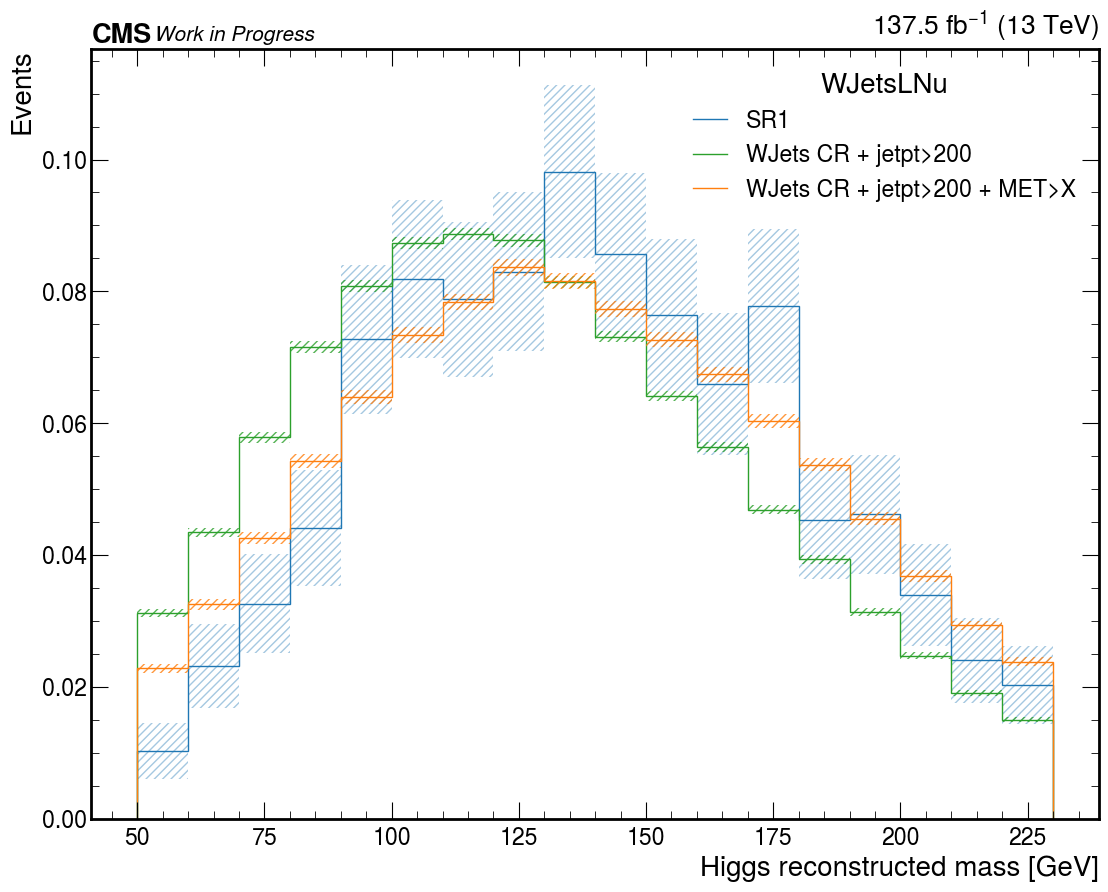

In [243]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))
color_region = {
    "SR1": "tab:blue",
    "SR2": "tab:orange",
    "WJets CR": "tab:green",
    "Top CR": "tab:green", 
    
    "WJets CR + jetpt>200": "tab:green",
    "WJets CR + jetpt>250": "tab:orange",
    "WJets CR + jetpt>300": "tab:blue",
    
    "WJets CR + jetpt>200 + MET>X": "tab:orange",
    "WJets CR + jetpt>250 + MET>X": "tab:green",
    "WJets CR + jetpt>300 + MET>X": "tab:red",

}

errps = {
    "SR1": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR1"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "SR2": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["SR2"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
    },
    "WJets CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "Top CR": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },  
    "WJets CR + jetpt>200": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>250": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },
    "WJets CR + jetpt>300": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },   
    "WJets CR + jetpt>200 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>200 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>250 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>250 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
    
    "WJets CR + jetpt>300 + MET>X": {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": color_region["WJets CR + jetpt>300 + MET>X"],
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.8,
    },       
        
    
}

if False:
    bkg = h[{"region": ["SR1", "SR2"]}].project("var")
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
    #         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
    #         density=True,
        linewidth=1,
        label="Signal Region (SR1+SR2)",
        flow="none",
    )

    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps["SR1"],        
        label="Stat. unc.",
    )    
    
for region in presel:
    if "SR2" in region:
        continue

    bkg = h[{"region": region}].project("var")    
    
    bkg2 = bkg.values()/bkg.values().sum()
    hep.histplot(
#         bkg,
        bkg2,
        bins=bkg.axes[0].edges,        
        ax=ax,
#         density=True,
        linewidth=1,
        label=region,
        flow="none",
        color=color_region[region]
    )
    
    ax.stairs(
        values=(bkg + np.sqrt(bkg))/bkg.values().sum(),
        baseline=(bkg - np.sqrt(bkg))/bkg.values().sum(),
        edges=bkg.axes[0].edges,
        **errps[region],        
#         label="Stat. unc.",
    )
    


ax.set_xlabel(bkg.axes.label[0])
ax.legend(title=" + ".join(sample for sample in samples), loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.015)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [550]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
#     "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
#     "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

# samples = ["ggF", "VBF", "VH", "ttH"]
samples = ["ggF", "QCD"]
# samples = ["WJetsLNu", "DYJets"]

# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "DYJets"):
#                     threshold = 50
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    samples=sample,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} DYJets events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

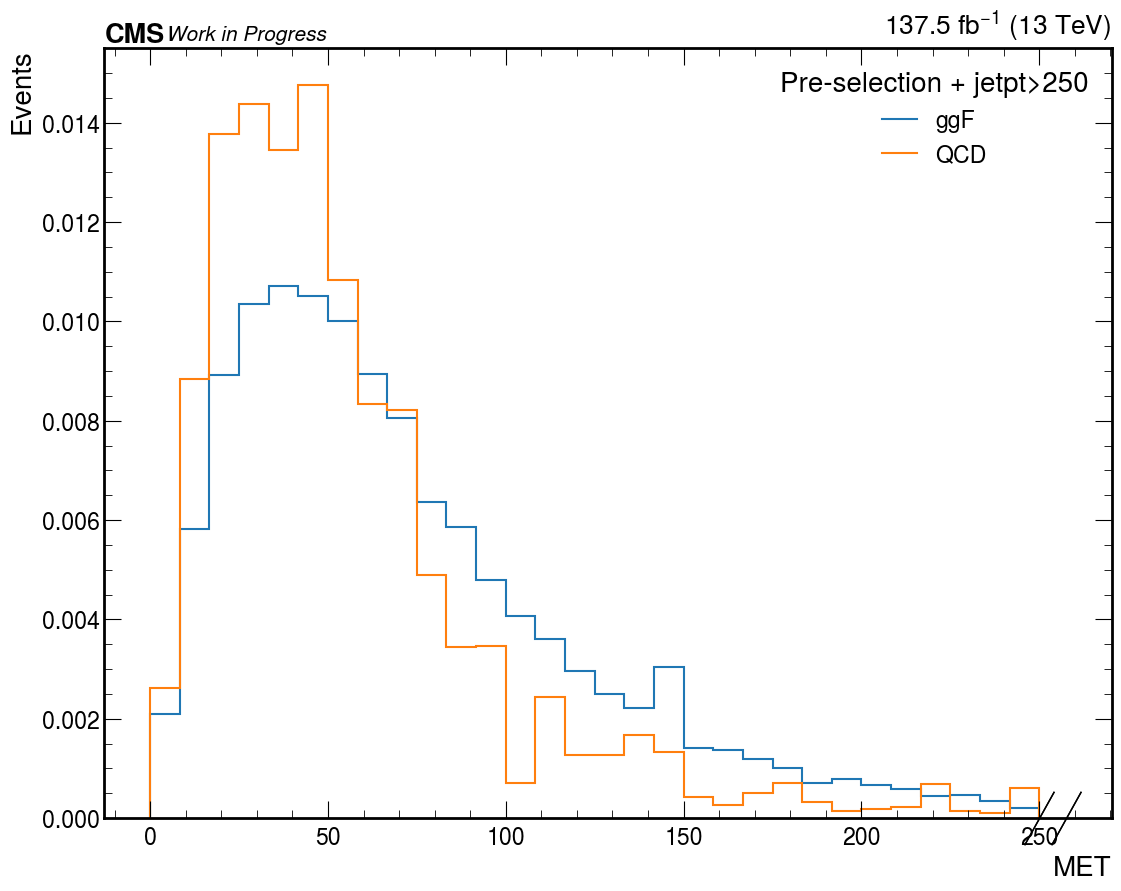

In [553]:
region = "Pre-selection + jetpt>250"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for sample in samples:
    hep.histplot(h[{"region": region, "samples": sample}].project("var"),
        label=sample,
        density=True,
#         yerr=True,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

In [655]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    
    "Pre-selection + jetpt>200": f"{tagger}>0.5",    
    "Pre-selection + jetpt>250": f"{tagger}>0.5 & fj_pt>250",  
    "Pre-selection + jetpt>300": f"{tagger}>0.5 & fj_pt>300",
        
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}


years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "met_pt"

samples = ["ggF", "VBF", "VH", "ttH"]
# samples = ["QCD"]
# samples = ["WJetsLNu"]
# samples = ["TTbar"]

h = hist2.Hist(
    hist2.axis.StrCategory([], name="channels", growth=True),        
    hist2.axis.StrCategory([], name="region", growth=True),    
#     hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    hist2.axis.Regular(30, 0, 250, name="var", label=r"MET", overflow=True),
    
)
ev = events_dict["new_corrections200"]
channels = ["ele", "mu"]

num, den = 0, 0
threshold = 0
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

#                 if (sample == "QCD"):
#                     threshold = 200
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                    
                h.fill(
                    channels=ch,
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1                             

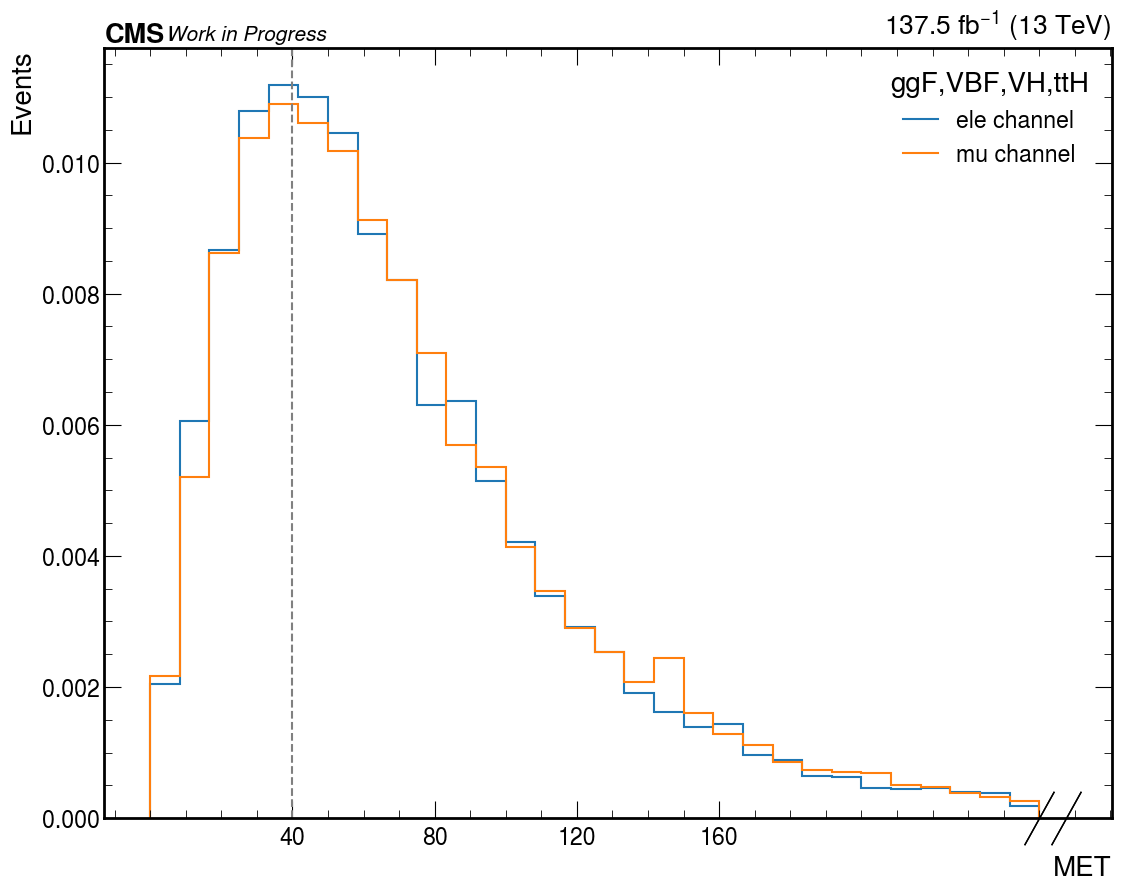

In [656]:
region = "Pre-selection + jetpt>200"
# region = "SR1"

# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for ch in channels:
    hep.histplot(h[{"region": region, "channels": ch}].project("var"),
        label=ch + " channel",
        density=True,
#         yerr=True,
    )
ax.legend(title=",".join(samples), loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")
ax.axvline(x=40, linestyle="--", color="grey")

ax.set_xticks([40, 80, 120, 160])
lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/z.pdf")     

# WJetsLNu corrections

In [646]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
    "Pre-selection": f"{tagger}>0.5",    
    
#     "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}<0.98) & ({tagger}>0.97) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0)",
    
#     "WJets CR + jetpt>200": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200",   
#     "WJets CR + jetpt>250": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
      
#     "WJets CR + jetpt>200 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>200", 
#     "WJets CR + jetpt>250 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>250", 
#     "WJets CR + jetpt>300 + MET>X": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & fj_pt>300", 
    
#     "Top CR": f"({tagger}>0.50) & (n_bjets_T>=0)",      
    

}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="corr", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )  
    
for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for corr_ in ["old_corrections", "new_corrections"]:

                df = events_dict[corr_][year][ch]["WJetsLNu"]

                df = df.query(sel)    

                h.fill(
                    corr=corr_,
                    var=df[var],
                    weight=df["event_weight"],
                )

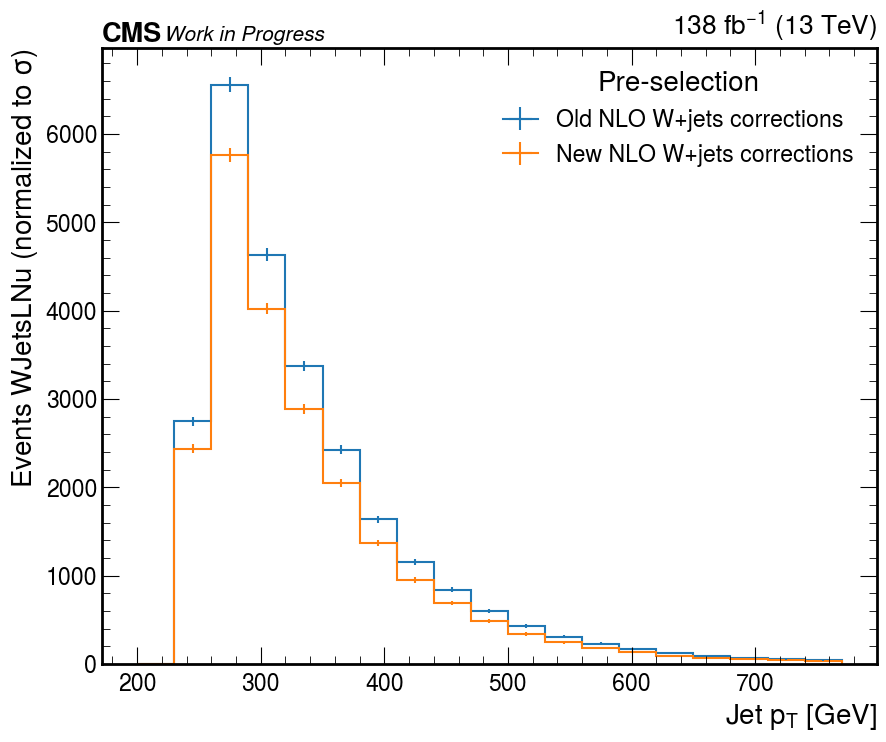

In [661]:
# different corrections

lab_dict = {
    "old_corrections": r"Old NLO W+jets corrections",
    "new_corrections": r"New NLO W+jets corrections",
}

fig, ax = plt.subplots(figsize=(10, 8))
for corr in ["old_corrections", "new_corrections"]:
    hep.histplot(h[{"corr": corr}].project("var"),
        label=lab_dict[corr],
        density=False,
        yerr=True,
        flow=None,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel(r"Events WJetsLNu (normalized to $\sigma$)")
# ax.set_ylim(0, 0.013)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.0f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN/wjetscorr.pdf")     

In [161]:
samples_to_plot = [
    'WJetsToLNu_HT-70To100',
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',    
]

In [181]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"fj_pt>0",       

    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      

corr = "new_corrections_wjets"
ev = events_dict[corr]

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            try:
                df = ev[year][ch][sample]
                df = df.query(sel)
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                x = df[var]                            
                if len(x)==0:
                    x = 0   
                w = df["event_weight"]
                
            except:
                print(f"{sample} does not exist in {corr}")
                x = 0
                w = 0
                
            h.fill(
                samples=sample, var=x, weight=w,
            )

WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets


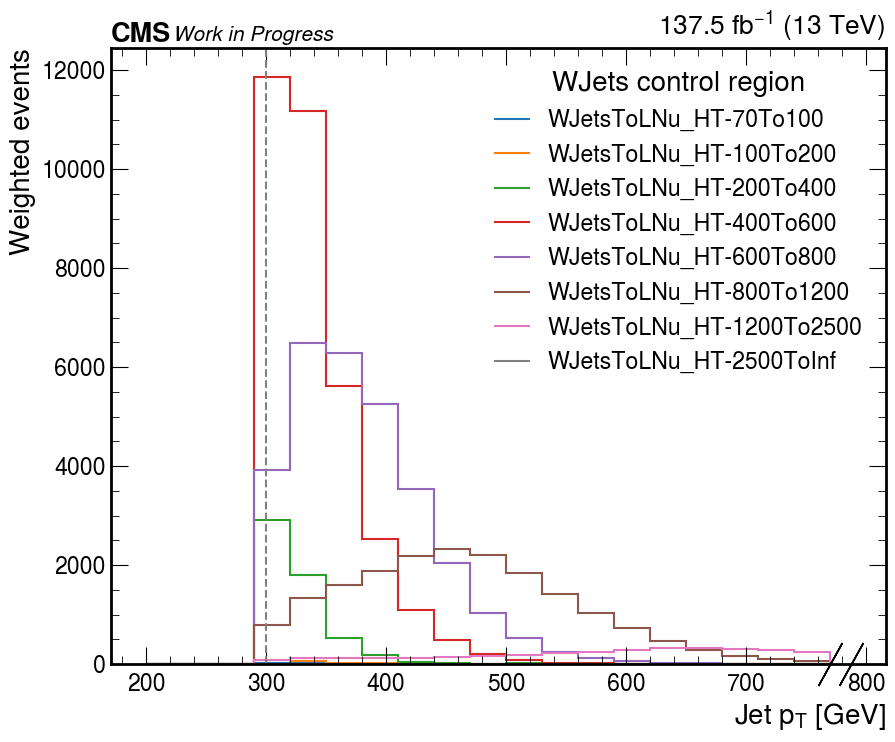

In [182]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

# High qcd weights

In [1855]:
samples_to_plot = list(events_dictqcd["signal_region"]["2017"]["ele"].keys())
samples_to_plot

['QCD_Pt_3200toInf',
 'QCD_Pt_1800to2400',
 'QCD_Pt_2400to3200',
 'QCD_Pt_1000to1400',
 'QCD_Pt_600to800',
 'QCD_Pt_300to470',
 'QCD_Pt_170to300',
 'QCD_Pt_800to1000',
 'QCD_Pt_470to600',
 'QCD_Pt_1400to1800']

In [1856]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "Pre-selection": f"fj_pt>0",       

#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97)",
    
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "Medium purity signal region + MET>X": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "WJets control region + MET>X": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(0, 500, 20)), name="var", label=r"Event weight", overflow=True)
    )      

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            df = events_dictqcd["signal_region"][year][ch][sample]
            df = df.query(sel)

            if "MET>X" in region:
                if ch=="ele":
                    df = df[df["met_pt"]>70]
                else:
                    df = df[df["met_pt"]>50]

            x = df[var]
            if len(x)==0:
                x = 0   
                
            if var=="event_weight":
                h.fill(
                    samples=sample, var=x,
                )

            else:
                h.fill(
                    samples=sample, var=x, weight=df["event_weight"],
                )

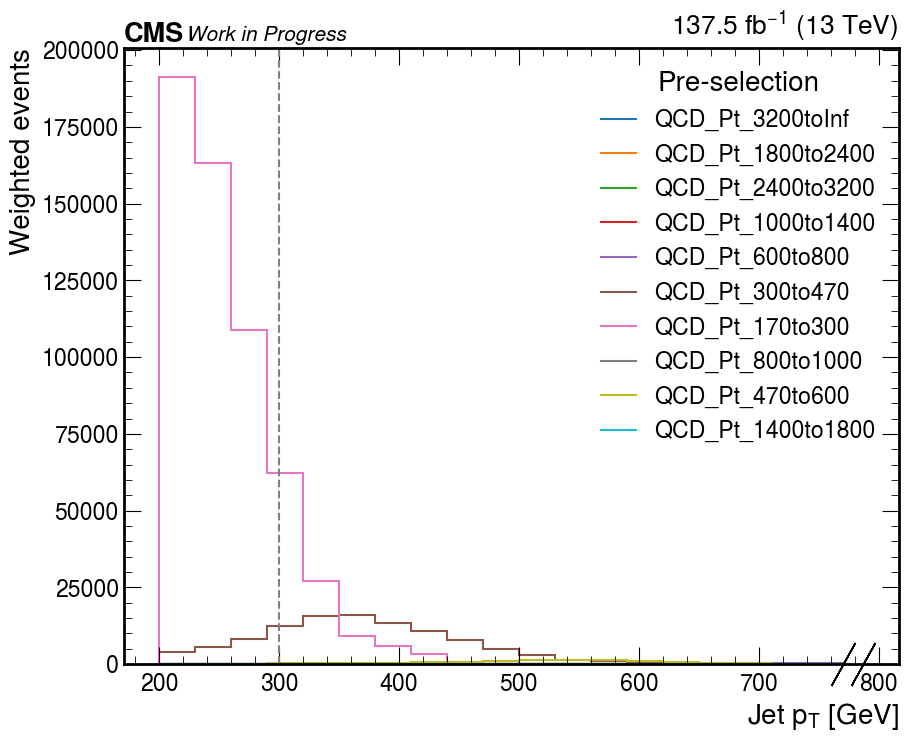

In [1857]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/qcd_high_weights_wjets_jetpt.pdf")     

# soverb

In [149]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [150]:
samples

['ggF',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson',
 'Data']

In [333]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
#     "Lep iso": f"fj_pt>0",
}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
#     "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
#                 if "High" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<140]
#                 if "Medium" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<200]
            
#             for category, category_sel in categories_sel.items():
#                 df = df.query(category_sel)            
            
#             if sample == "QCD":
#                 df = df[df["event_weight"]<50]
                
#             if ch=="ele":
#                 df = df[df["met_pt"]>70]
#             else:
#                 df = df[df["met_pt"]>50]
                
#             df = df[df["n_bjets_L"]==0]
#             df = df[df["lep_fj_dr"]>0.2]
            df = df[df["lep_met_mt"]>40]
    
#             df = df[(df["fj_pt"]/df["lep_pt"])<3]

#             df = df[np.abs(df["met_fj_dphi"])<2.5]

#             df = df[df["fj_ParT_mass"]<50]

#             df = df[df["fj_pt"]>250]
            ######################## composition start
            if sample in utils.signals:
                
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum()     
            ######################## composition end
            
            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
    
            if sample in utils.signals:                
                s += df["event_weight"].sum()
            else:
                b += df["event_weight"].sum()
            ######################## soverb end

In [334]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
# print("Category:", category)

print("------------------------")

if "purity" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (Run2):
------------------------
Signal: 475.17
- ttH: 16%
- VH: 17%
- VBF: 20%
- ggF: 47%
------------------------
Background: 497404.16
- Others: 2%
- QCD: 5%
- DYJets: 15%
- TTbar: 18%
- WJetsLNu: 59%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

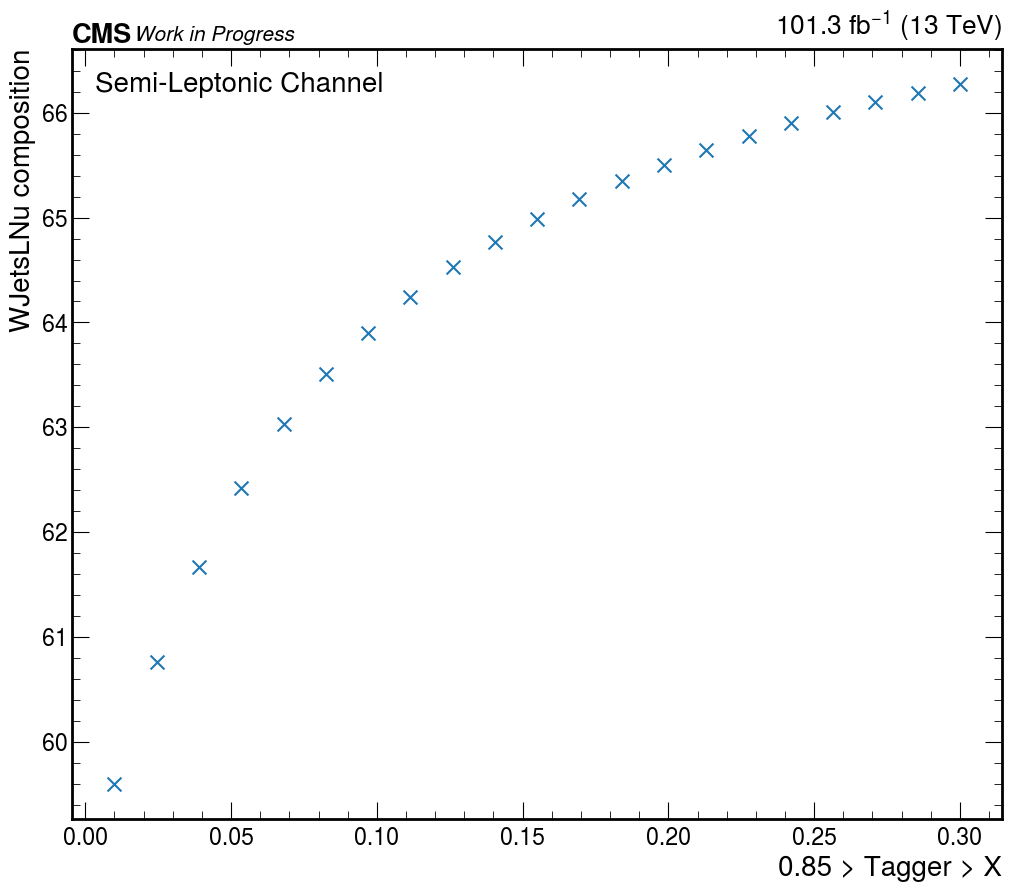

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

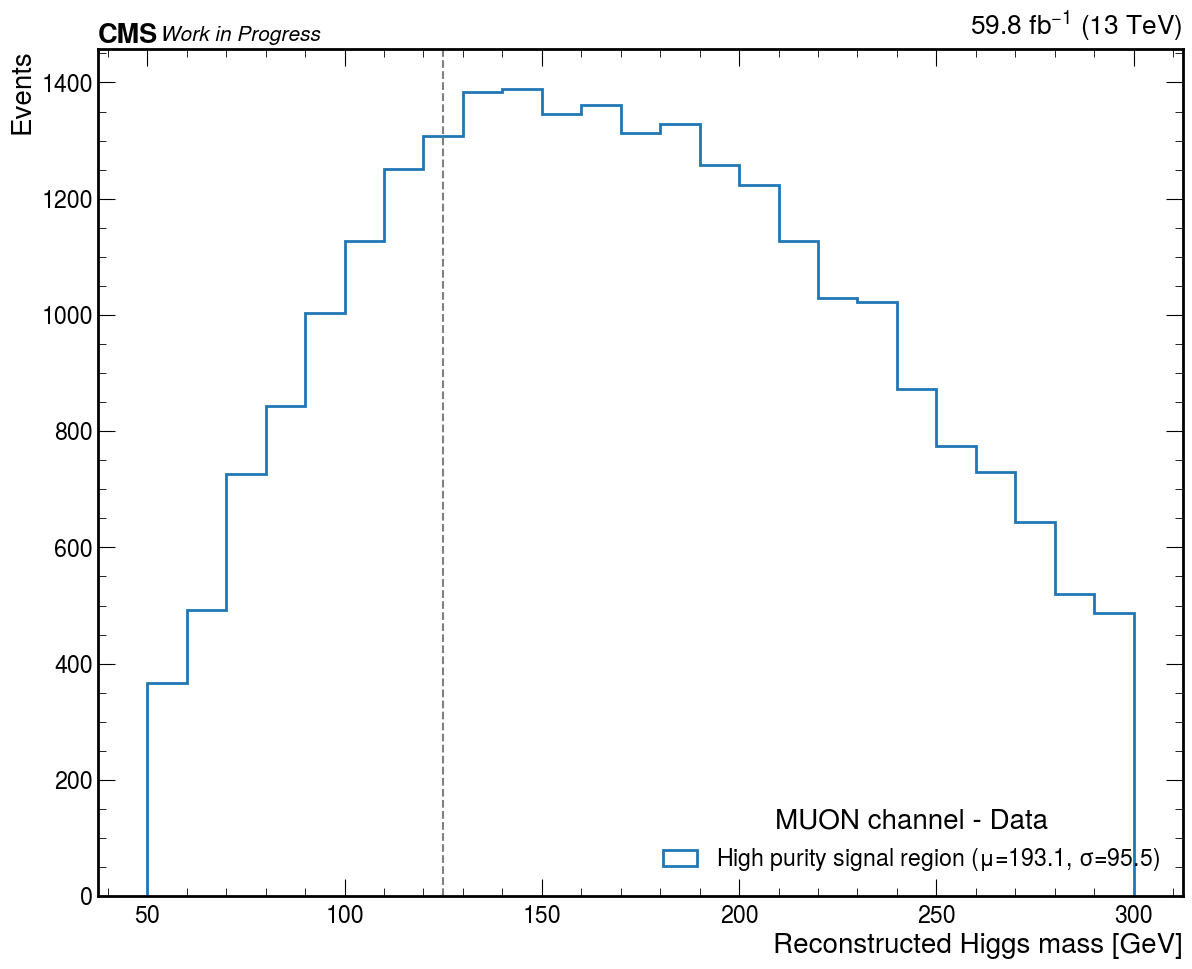

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [803]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [804]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
# channels = ["mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


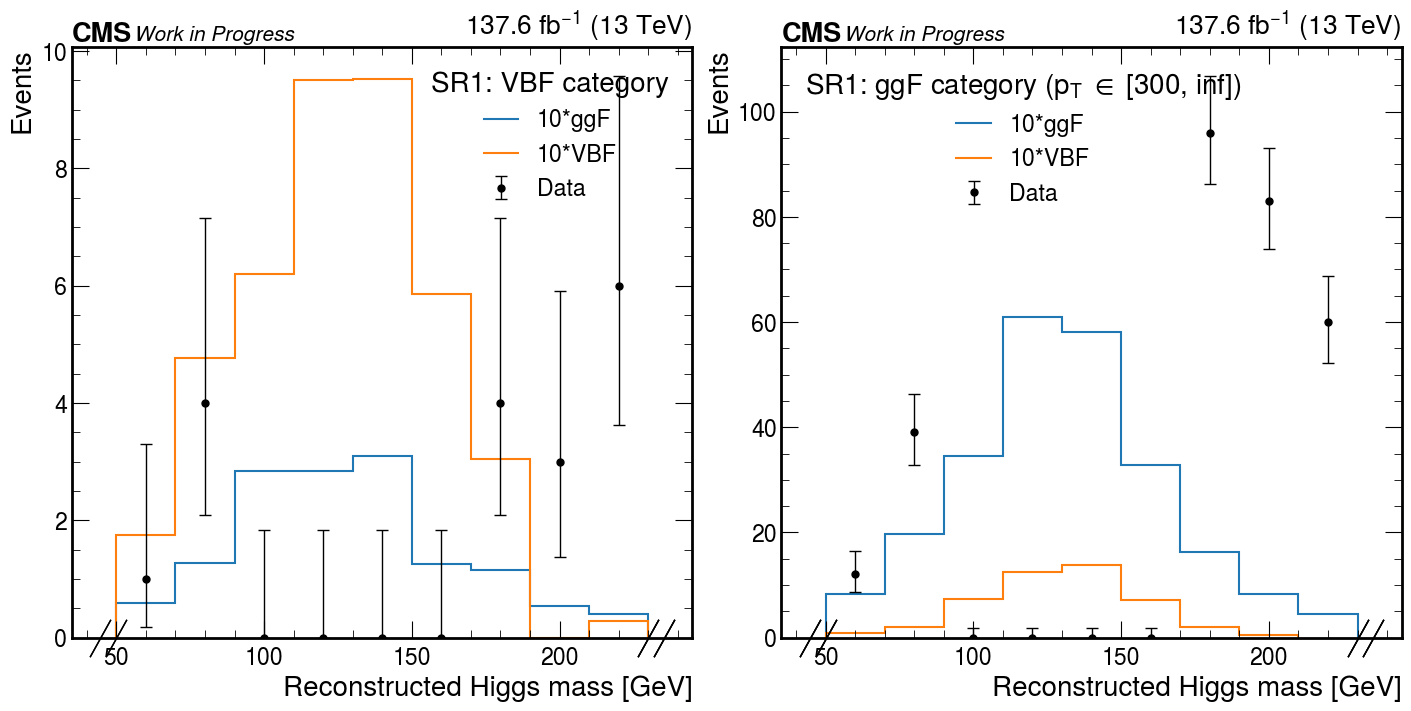

In [805]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
                

    axs[i].legend(title=f"SR1: {category}")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww3.pdf")

In [1099]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1": f"({tagger}>0.98) & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


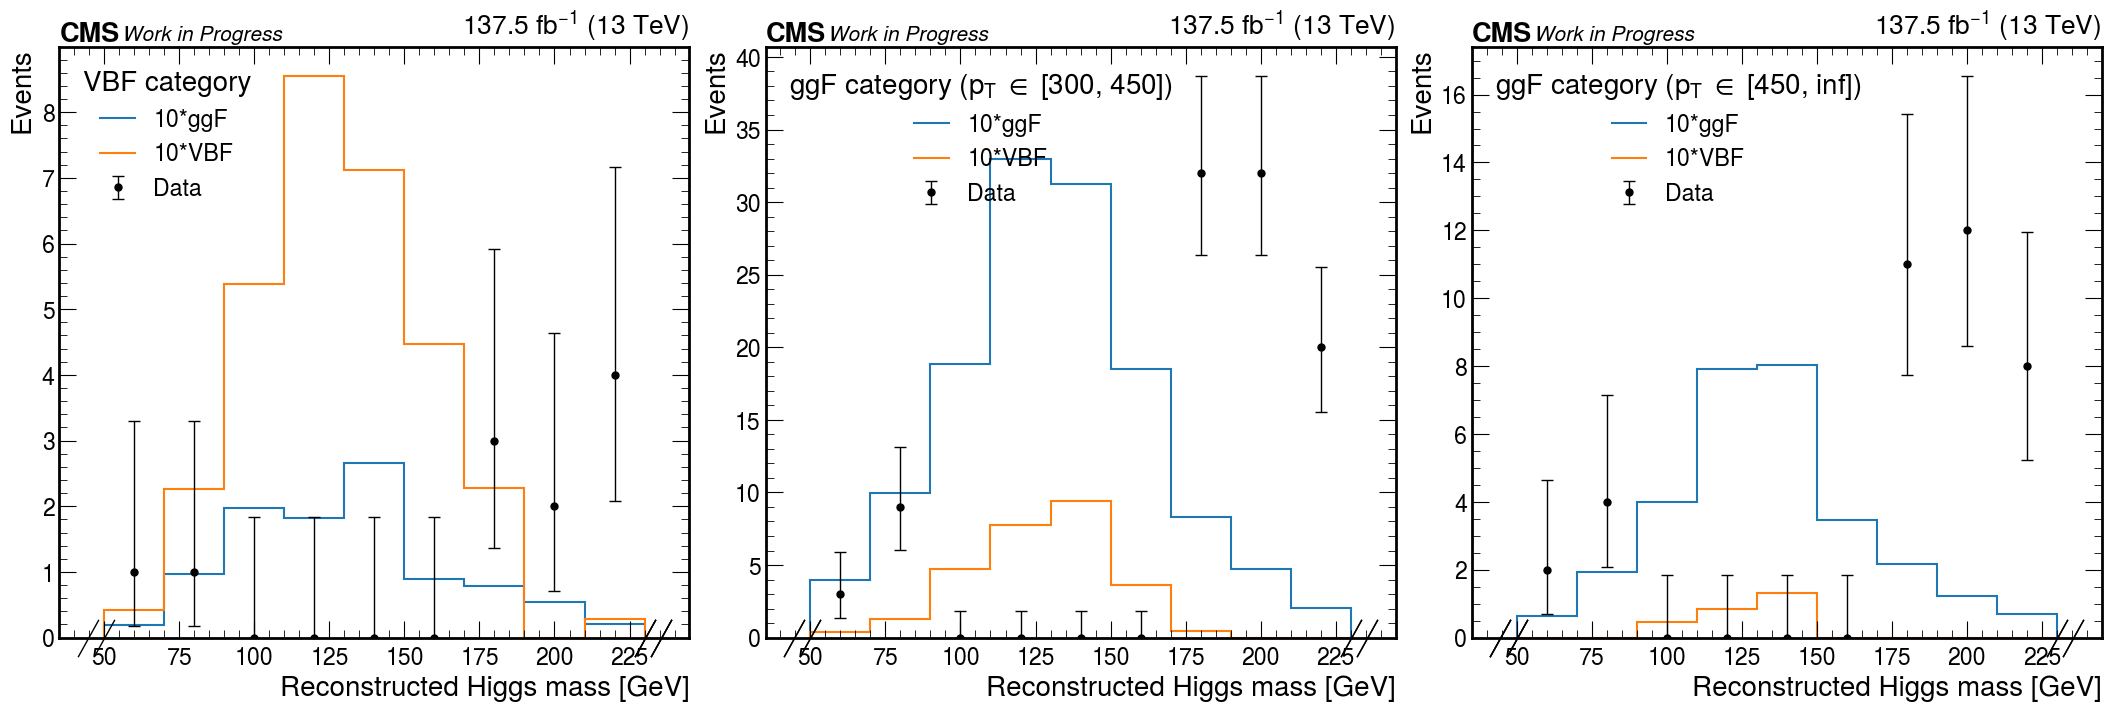

In [1100]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

In [25]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",   
    
    "SR1": f"(n_bjets_T==0)",
    
#     "SR1": f" & (n_bjets_T==0)",
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",

    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

# categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
# #     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
# #     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
# #     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
# }

categories_sel = {
    "SR1": {
        "VBF": f"({tagger}>0.97) & (mjj>1000) & (deta>3.5)",
        rf"ggF $p_T$ $\in$ [250, 300]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>250) & (fj_pt<300)",        
        rf"ggF $p_T$ $\in$ [300, 450]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
        rf"ggF $p_T$ $\in$ [450, Inf]": f"({tagger}>0.98) & (mjj<1000) & (deta<3.5) & (fj_pt>450)",
    },
    
    "SR2": {
    rf"all inclusive": "(mjj<1000) & (deta<3.5)",
    }
}
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        


samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1": 10,
    "SR2": 10,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():

                for category, category_sel in categories_sel[region].items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


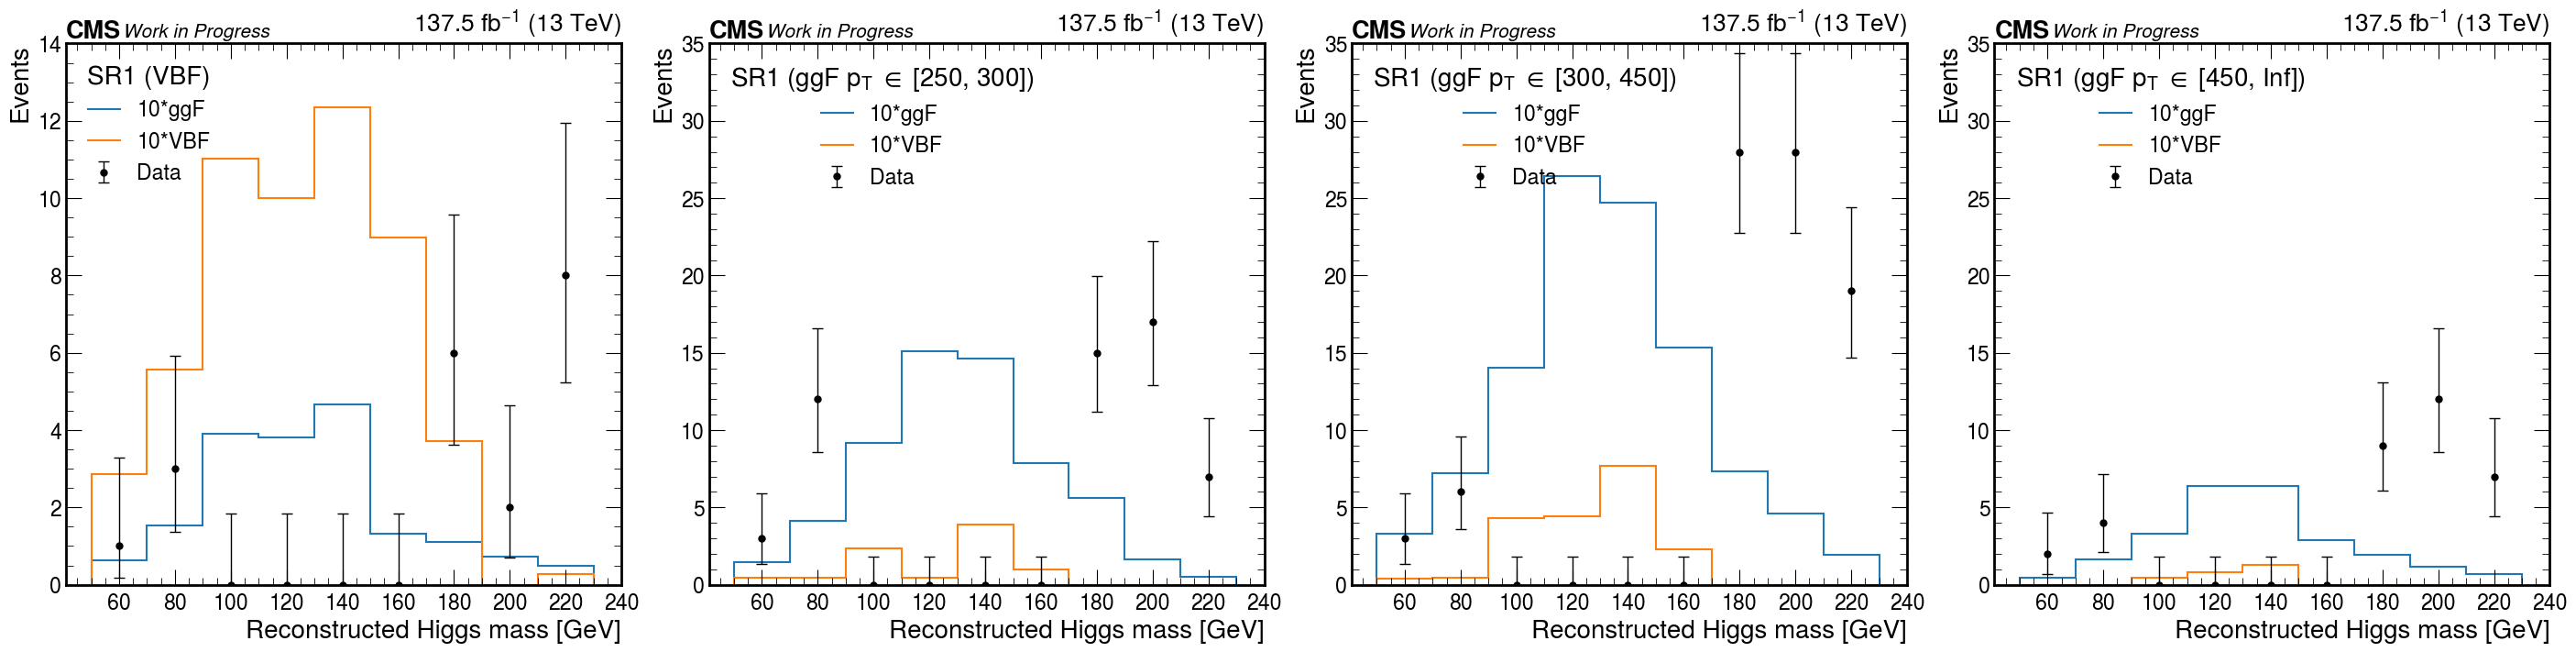

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(28,7), constrained_layout=True)

for region in regions_sel:
    for i, category in enumerate(categories_sel[region]):
        if region=="SR2":
            i=3
        for sample in samples:


            if sample == "Data":
                if blind:
                    hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    label=sample,
                    histtype="errorbar",
                    color="k",
                    capsize=4,   
                    flow="none"                    
                    
                )   

            else:
                if mult[region]==1:
                    lab = sample            
                else:
                    lab = f"{mult[region]}*{sample}"

                hep.histplot(
                    hists[{"samples": sample, "regions": region, "categories": category}],
                    ax=axs[i],
                    histtype="step",
                    label=lab,
                    flow="none"
                )    
#         if i==3:
#             axs[i].legend(title=f"{region}", loc="upper left")
#         else:
#             axs[i].legend(title=f"{region} ({category})", loc="upper left")

        axs[i].legend(title=f"{region} ({category})", loc="upper left")                

            
        if i==0:
            axs[i].set_ylim(0,14)
        if i==1:
            axs[i].set_ylim(0,35)
        if i==2:
            axs[i].set_ylim(0,35)            
        if i==3:
            axs[i].set_ylim(0,35)
            
            
        axs[i].set_ylabel(f"Events")
        axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
        axs[i].set_ylim(0)    
        hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
        hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
        
        axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    plt.savefig(f"/Users/fmokhtar/Desktop/AN/ww2.pdf")

# QCD

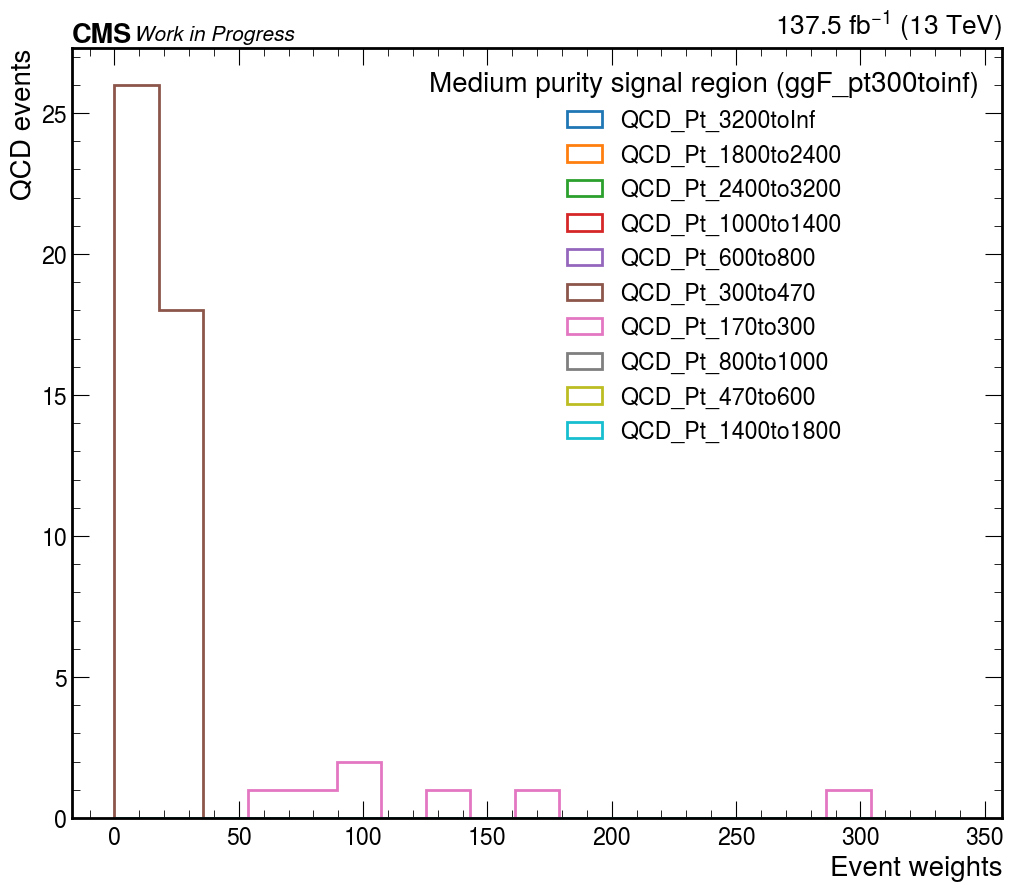

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [441]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()

    print(tot_err_MC)
    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    
    
    
    
    
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [442]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

KeyError: 'signal_region'

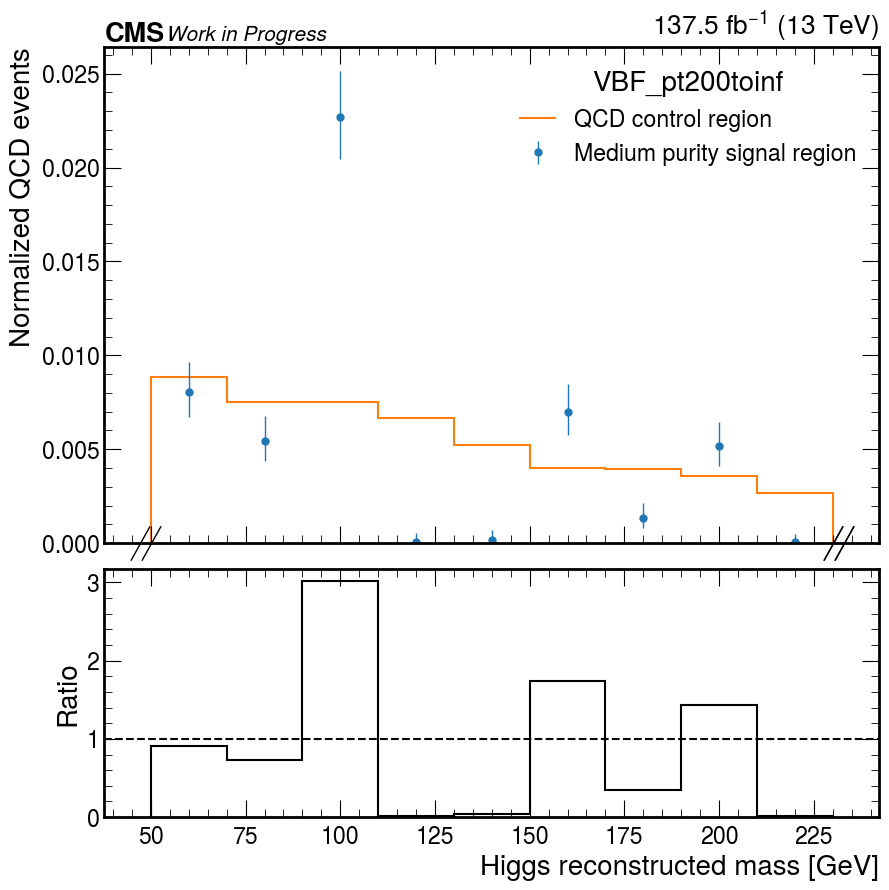

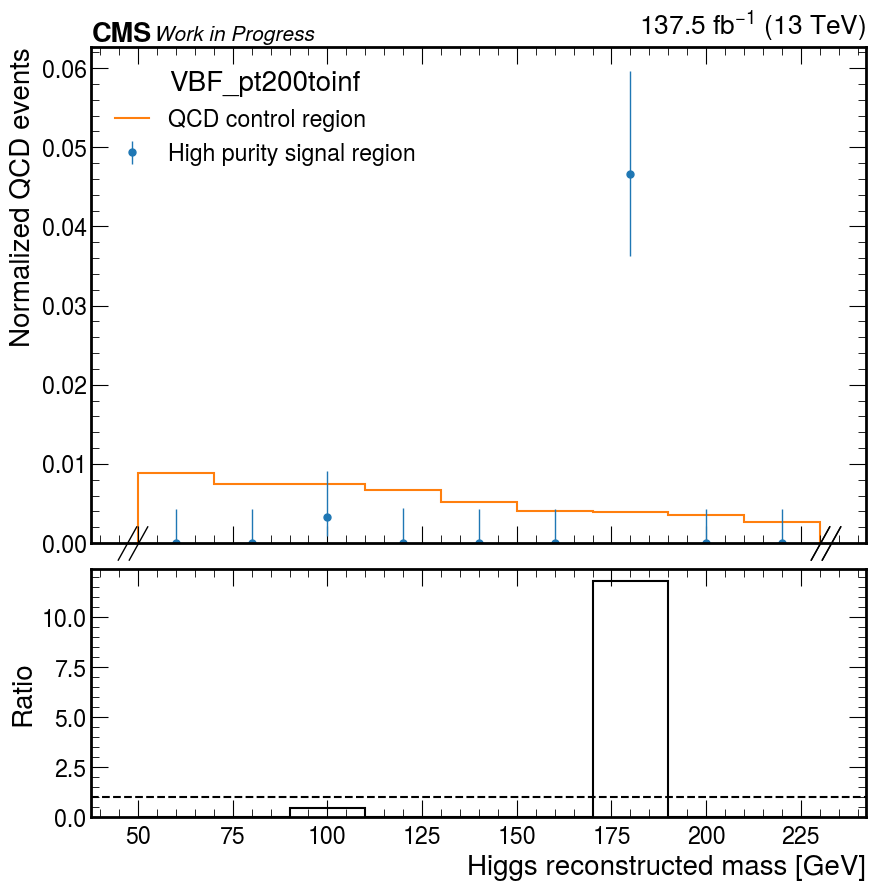

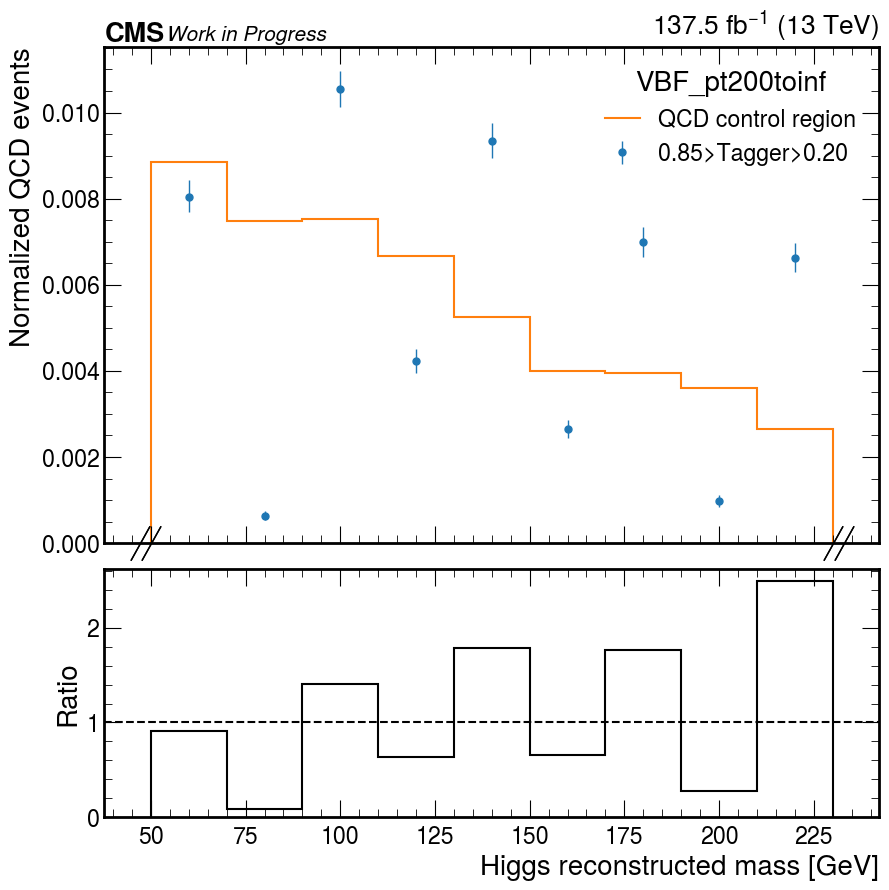

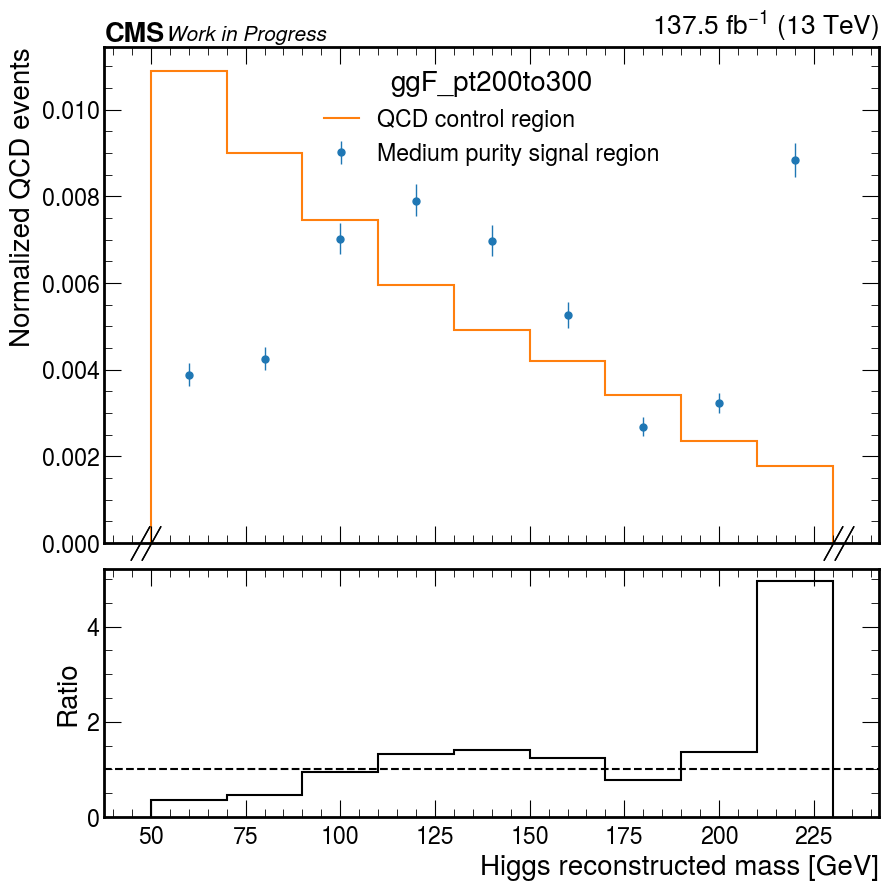

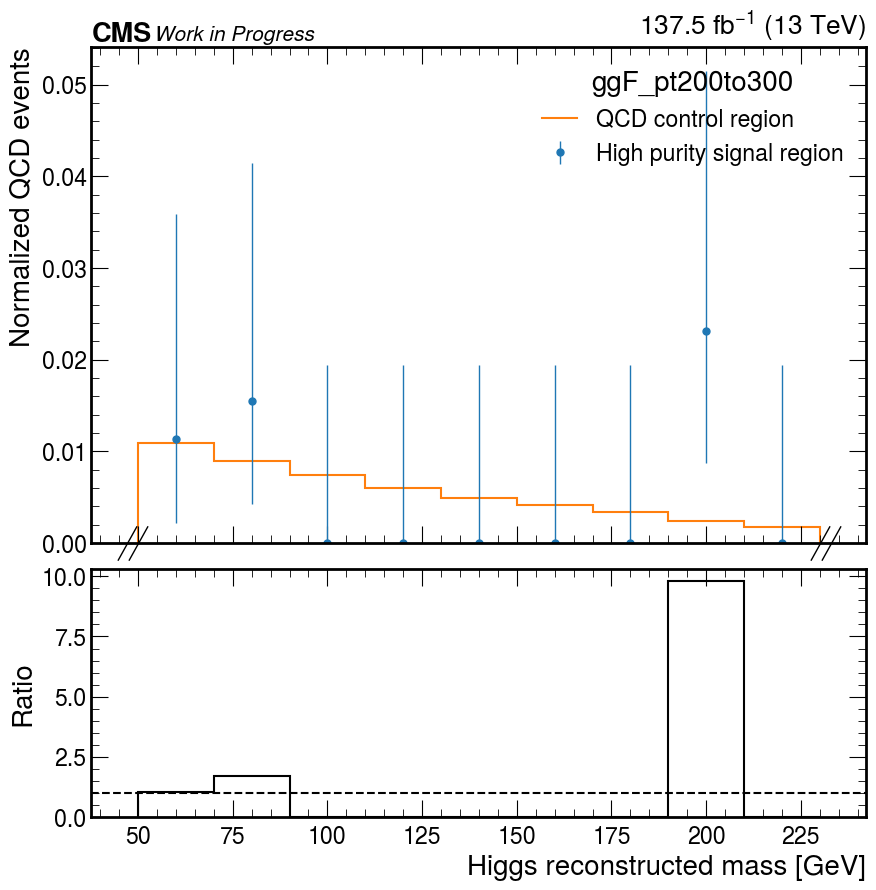

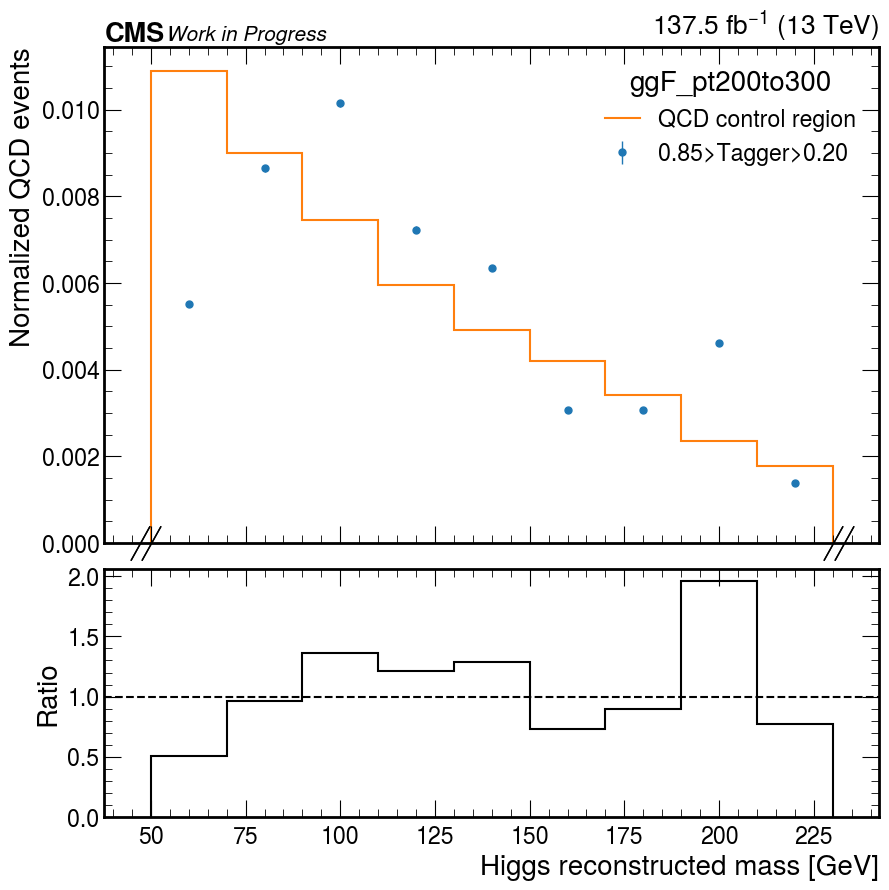

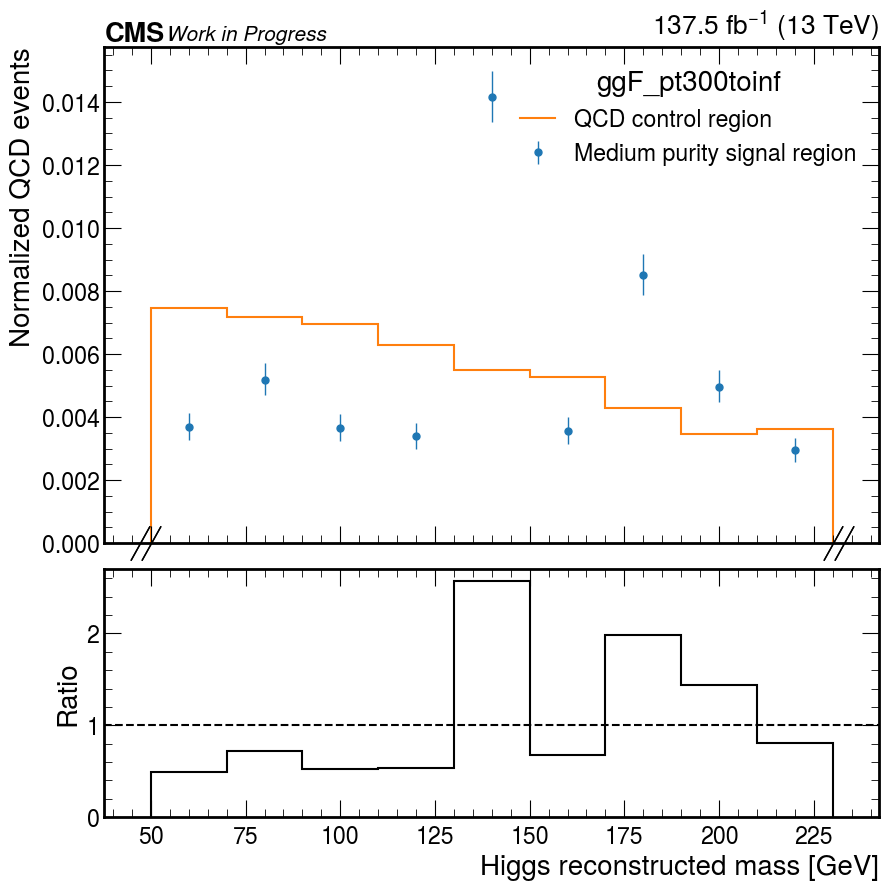

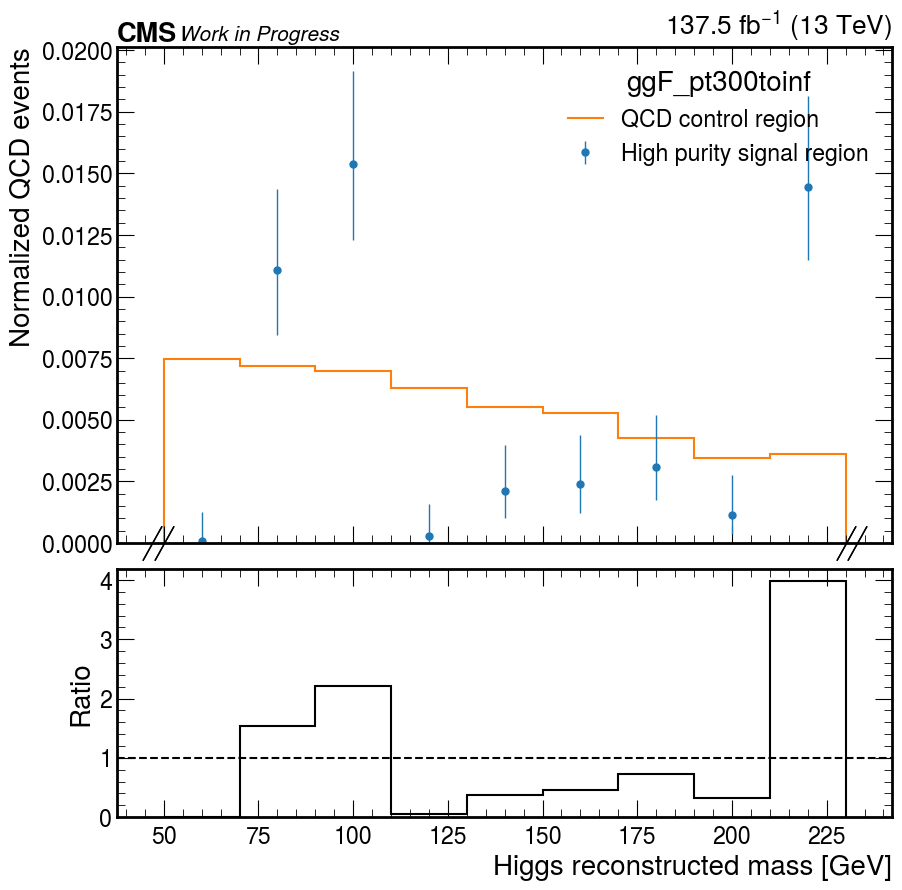

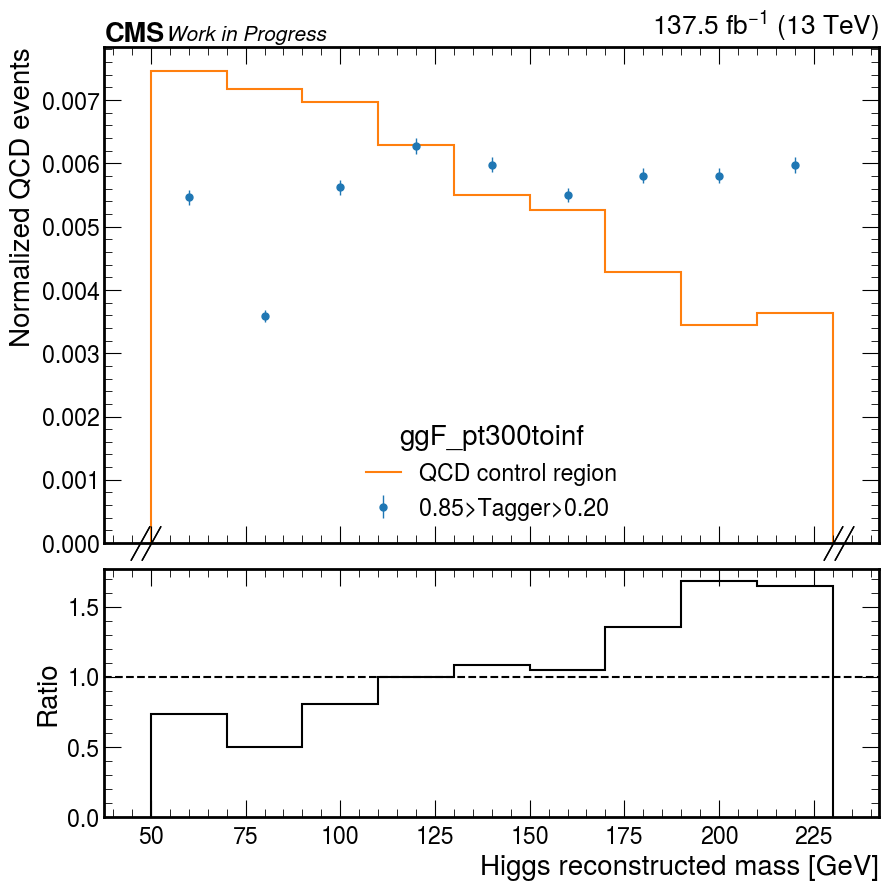

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

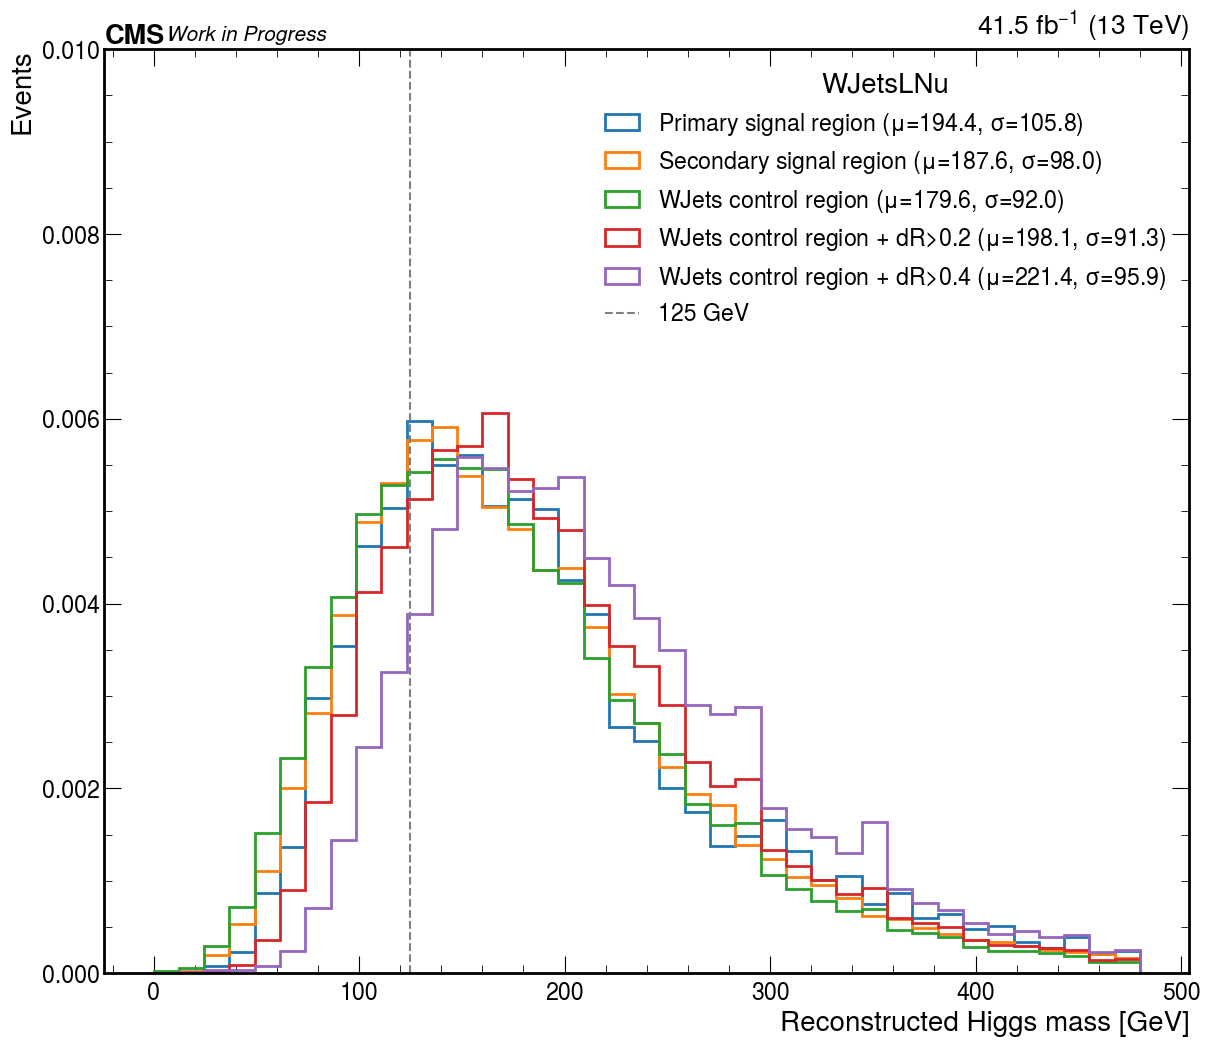

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  